In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF,PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import re
import string
import os
from tqdm import tqdm
import re
import spacy
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
tqdm.pandas()

# **Data Import and paths**

Mounting google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = "/content/drive/MyDrive/Datasets"

files = [f for f in os.listdir(data_path) if f.endswith(".csv")]
print("CSV files found:", files)

CSV files found: ['tribune.csv', 'pakistan_today.csv', 'dawn.csv', 'daily_times.csv', 'combined_dataset.csv', 'business_recorder.csv']


In [ ]:
# available years
years_found = set()
for file in files:
    file_path = os.path.join(data_path, file)
    print(f"Scanning {file}...")
    for chunk in pd.read_csv(file_path, chunksize=50000, encoding="latin-1", usecols=['date']):
        chunk['date'] = pd.to_datetime(chunk['date'], errors='coerce')
        years_found.update(chunk['date'].dt.year.dropna().unique())

years_found = sorted([int(y) for y in years_found if pd.notna(y)])
print("\nYears found in dataset:", years_found)

Scanning tribune.csv...
Scanning pakistan_today.csv...
Scanning dawn.csv...
Scanning daily_times.csv...
Scanning combined_dataset.csv...
Scanning business_recorder.csv...

Years found in dataset: [2020, 2021, 2022, 2023]


In [ ]:
file_name = 'combined_dataset.csv'
combined_file_path = os.path.join(data_path, file_name)

chunk_size = 50000

csv_chunks = pd.read_csv(combined_file_path, chunksize=chunk_size, encoding='latin-1')

first_chunk = next(csv_chunks)
print(f"Displaying the head of the first chunk from '{file_name}':")
display(first_chunk.head())

Displaying the head of the first chunk from 'combined_dataset.csv':


headline              date  \
0  CJP to hear Karak temple attack case on Tuesda...  12/31/2020 14:36   
1                  NAB secures 14-day remand of Asif  12/31/2020 15:30   
2                PMC response sought in license case  12/31/2020 16:37   
3  Saudi-led coalition strikes at Yemen capital a...  12/31/2020 16:47   
4  Asif, another PML-N leader asked to quit party...  12/31/2020 17:11   

                                                link          source  \
0  https://www.pakistantoday.com.pk/2020/12/31/14...  Pakistan Today   
1  https://www.pakistantoday.com.pk/2020/12/31/na...  Pakistan Today   
2  https://www.pakistantoday.com.pk/2020/12/31/pm...  Pakistan Today   
3  https://www.pakistantoday.com.pk/2020/12/31/sa...  Pakistan Today   
4  https://www.pakistantoday.com.pk/2020/12/31/as...  Pakistan Today   

  categories                                        description  \
0   national       ISLAMABAD: Chief Justice of Pakistan (CJP...   
1   national    LAHORE: An accountability in Lahore on Thurs...   
2   national   ISLAMABAD: The Islamabad High Court (IHC) has...   
3      world  ADEN: Saudi-led coalition warplanes struck tar...   
4   national  LAHORE: Former National Assembly (NA) speaker ...   

  mapped_categories  
0          National  
1          National  
2          National  
3             World  
4          National

# **EDA (Exploratory Data Analysis)**

### **Explore Dataset Structure and Compute Basic Statistics**

In [ ]:
csv_chunks = pd.read_csv(combined_file_path, chunksize=chunk_size, encoding='latin-1')
print("csv_chunks iterator reinitialized.")
total_rows = 0
column_data_types = {}
non_null_counts = {}
numerical_sums = {}
numerical_counts = {}
numerical_min = {}
numerical_max = {}

print("Aggregated statistics variables initialized.")
for i, chunk in enumerate(csv_chunks):
    total_rows += len(chunk)

    for col in chunk.columns:

        if col not in column_data_types:
            column_data_types[col] = str(chunk[col].dtype)

        # Update non-null counts
        non_null_counts[col] = non_null_counts.get(col, 0) + chunk[col].count()

        if pd.api.types.is_numeric_dtype(chunk[col]):
            numerical_sums[col] = numerical_sums.get(col, 0) + chunk[col].sum()
            numerical_counts[col] = numerical_counts.get(col, 0) + chunk[col].count()

            numerical_min[col] = min(numerical_min.get(col, np.inf), chunk[col].min())
            numerical_max[col] = max(numerical_max.get(col, -np.inf), chunk[col].max())

print("Chunk processing and aggregation complete.")

csv_chunks iterator reinitialized.
Aggregated statistics variables initialized.
Chunk processing and aggregation complete.


In [ ]:
print("\n--- Dataset Statistics ---")
print(f"Total Rows: {total_rows}")

print("\nColumn Data Types:")
for col, dtype in column_data_types.items():
    print(f"  {col}: {dtype}")

print("\nNon-Null Counts:")
for col, count in non_null_counts.items():
    print(f"  {col}: {count} ({(count/total_rows)*100:.2f}%) non-null")

print("\nNumerical Column Statistics:")
if not numerical_sums and not numerical_counts and not numerical_min and not numerical_max:
    print("  No numerical columns found or processed.")
else:
    for col in numerical_sums.keys():
        mean_val = numerical_sums[col] / numerical_counts[col] if numerical_counts[col] > 0 else 'N/A'
        print(f"  {col}:")
        print(f"    Sum: {numerical_sums[col]}")
        print(f"    Count (non-null): {numerical_counts[col]}")
        print(f"    Mean: {mean_val:.2f}")
        print(f"    Min: {numerical_min[col]}")
        print(f"    Max: {numerical_max[col]}")



--- Dataset Statistics ---
Total Rows: 288150

Column Data Types:
  headline: object
  date: object
  link: object
  source: object
  categories: object
  description: object
  mapped_categories: object

Non-Null Counts:
  headline: 288150 (100.00%) non-null
  date: 288150 (100.00%) non-null
  link: 288150 (100.00%) non-null
  source: 288150 (100.00%) non-null
  categories: 288150 (100.00%) non-null
  description: 288143 (100.00%) non-null
  mapped_categories: 288150 (100.00%) non-null

Numerical Column Statistics:
  No numerical columns found or processed.


In [ ]:
categorical_cols = [col for col, dtype in column_data_types.items() if dtype == 'object']

unique_values_dict = {col: set() for col in categorical_cols}

# Re-initialize csv_chunks iterator to start from the beginning
csv_chunks = pd.read_csv(combined_file_path, chunksize=chunk_size, encoding='latin-1')

print("Collecting unique values for object columns...")
for i, chunk in enumerate(csv_chunks):
    for col in categorical_cols:
        # Add unique values from the current chunk to the set for that column
        unique_values_dict[col].update(chunk[col].dropna().unique())

print("\nUnique values for object columns:")
for col, unique_vals in unique_values_dict.items():
    print(f"  {col} ({len(unique_vals)} unique values): {list(unique_vals)[:5]}... (showing first 5)")


Unique values for object columns:
  headline (270167 unique values): ['Rs450b spent on Eid this year', 'LHC orders police to recover Wazirabad attack suspectÃ\x83Â¢Ã\x82Â\x80Ã\x82Â\x99s kin', "Khamenei says UAE 'betrayed' Muslim world with Israel deal", 'ECC approves Rs 1.2 trillion package to address COVID-19 challenges', 'PM for fast-tracking establishment of markets along Afghan, Iran border areas']... (showing first 5)
  date (78153 unique values): ['12/1/2022 23:47', '4/13/2020 5:19', '10/27/2022 10:11', '7/18/2020', '10/13/2020 2:13']... (showing first 5)
  link (282125 unique values): ['https://tribune.com.pk/story/2258414/indonesia-reports-2473-new-coronavirus-cases-72-deaths', 'https://dailytimes.com.pk/536398/usman-buzdar-inaugurates-international-moot-on-dengue/', 'https://www.dawn.com/news/1678291/rain-in-twin-cities-may-disrupt-pakistan-australia-cricket-match', 'https://dailytimes.com.pk/1068072/rival-student-groups-clash-in-punjab-university/', 'https://www.brecorder.co

In [ ]:
source_counts = {}
source_description_lengths = {}
category_counts = {}
category_description_lengths = {}

print("Aggregating statistics for sources and categories...")

# Re-initialize csv_chunks iterator to ensure processing from the beginning
csv_chunks = pd.read_csv(combined_file_path, chunksize=chunk_size, encoding='latin-1')

for i, chunk in enumerate(csv_chunks):
    # Process 'source' column
    for index, row in chunk.iterrows():
        source = row['source']
        description_length = len(str(row['description'])) if pd.notna(row['description']) else 0

        source_counts[source] = source_counts.get(source, 0) + 1
        source_description_lengths[source] = source_description_lengths.get(source, 0) + description_length

        categories_str = row['mapped_categories']
        if pd.notna(categories_str):

            for category in categories_str.split(', '):
                category = category.strip()
                if category:
                    category_counts[category] = category_counts.get(category, 0) + 1
                    category_description_lengths[category] = category_description_lengths.get(category, 0) + description_length
print("Aggregation complete.")

Aggregating statistics for sources and categories...
Aggregation complete.


In [ ]:
print("\n--- Source Statistics ---")
for source, count in source_counts.items():
    avg_desc_len = source_description_lengths[source] / count if count > 0 else 0
    print(f"Source: {source}")
    print(f"  Number of articles: {count}")
    print(f"  Average description length: {avg_desc_len:.2f}\n")

print("\n--- Category Statistics ---")
for category, count in category_counts.items():
    avg_desc_len = category_description_lengths[category] / count if count > 0 else 0
    print(f"Category: {category}")
    print(f"  Number of articles: {count}")
    print(f"  Average description length: {avg_desc_len:.2f}\n")


--- Source Statistics ---
Source: Pakistan Today
  Number of articles: 27427
  Average description length: 2442.36

Source: Daily Times
  Number of articles: 82173
  Average description length: 2431.07

Source: Tribune
  Number of articles: 46285
  Average description length: 2699.42

Source: Dawn
  Number of articles: 35012
  Average description length: 3431.09

Source: Business Recorder
  Number of articles: 97253
  Average description length: 2038.53


--- Category Statistics ---
Category: National
  Number of articles: 188703
  Average description length: 2414.82

Category: World
  Number of articles: 99447
  Average description length: 2558.12



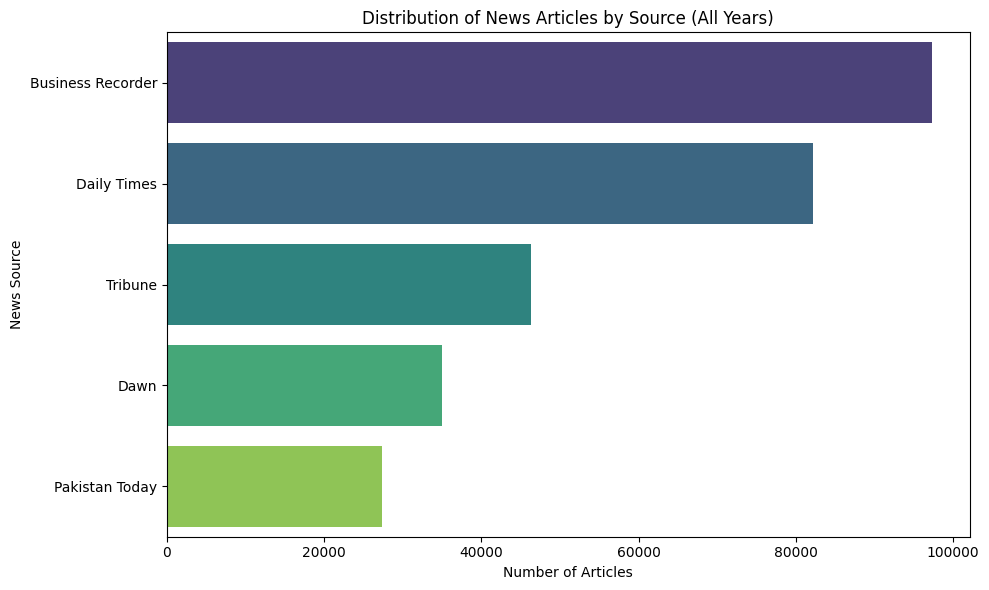

In [ ]:
# Visualize Distribution of News Articles by Source

source_df = pd.DataFrame(list(source_counts.items()), columns=['Source', 'Article Count'])
source_df = source_df.sort_values(by='Article Count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Article Count', y='Source', data=source_df, palette='viridis', hue='Source', legend=False)
plt.title('Distribution of News Articles by Source (All Years)')
plt.xlabel('Number of Articles')
plt.ylabel('News Source')
plt.tight_layout()
plt.show()


/tmp/ipython-input-2405699740.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Article Count', y='Mapped Category', data=category_df, palette='magma')


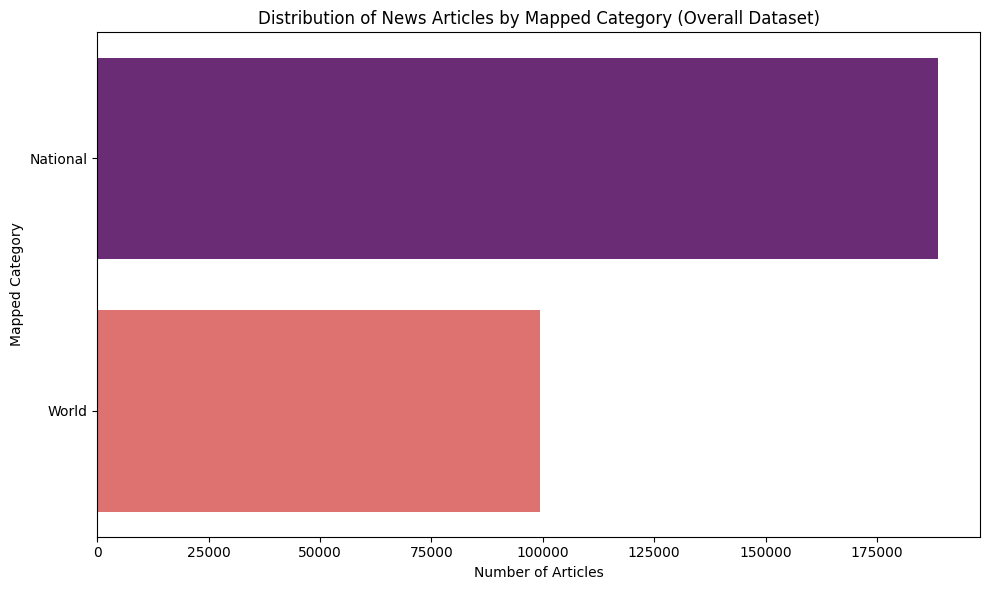

In [ ]:
# Visualize Distribution of News Articles by Mapped Category

category_df = pd.DataFrame(list(category_counts.items()), columns=['Mapped Category', 'Article Count'])
category_df = category_df.sort_values(by='Article Count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Article Count', y='Mapped Category', data=category_df, palette='magma')
plt.title('Distribution of News Articles by Mapped Category (Overall Dataset)')
plt.xlabel('Number of Articles')
plt.ylabel('Mapped Category')
plt.tight_layout()
plt.show()

In [ ]:
yearly_source_counts = {}

for year in years_found:
    print(f"Processing year: {year}")
    current_year_source_counts = {}

    # Re-initialize csv_chunks iterator for each year
    csv_chunks = pd.read_csv(combined_file_path, chunksize=chunk_size, encoding='latin-1')

    for i, chunk in enumerate(csv_chunks):
        # Convert 'date' column to datetime and handle errors
        chunk['date'] = pd.to_datetime(chunk['date'], errors='coerce')

        # Filter articles for the current year
        yearly_chunk = chunk[chunk['date'].dt.year == year]

        # Aggregate source counts for the current year
        for source in yearly_chunk['source'].dropna().unique():
            current_year_source_counts[source] = current_year_source_counts.get(source, 0) + yearly_chunk[yearly_chunk['source'] == source].shape[0]

    yearly_source_counts[year] = current_year_source_counts

print("Yearly source counts aggregation complete.")
for year, counts in yearly_source_counts.items():
    print(f"\nYear {year}:")
    for source, count in counts.items():
        print(f"  {source}: {count} articles")

Processing year: 2020
Processing year: 2021
Processing year: 2022
Processing year: 2023
Yearly source counts aggregation complete.

Year 2020:
  Pakistan Today: 31 articles
  Daily Times: 21242 articles
  Dawn: 11901 articles
  Business Recorder: 28388 articles

Year 2021:
  Pakistan Today: 6702 articles
  Daily Times: 22800 articles
  Business Recorder: 33281 articles

Year 2022:
  Pakistan Today: 13746 articles
  Daily Times: 25215 articles
  Tribune: 2225 articles
  Dawn: 16169 articles
  Business Recorder: 24537 articles

Year 2023:
  Pakistan Today: 2755 articles
  Daily Times: 3255 articles
  Tribune: 3660 articles
  Dawn: 2845 articles
  Business Recorder: 11047 articles


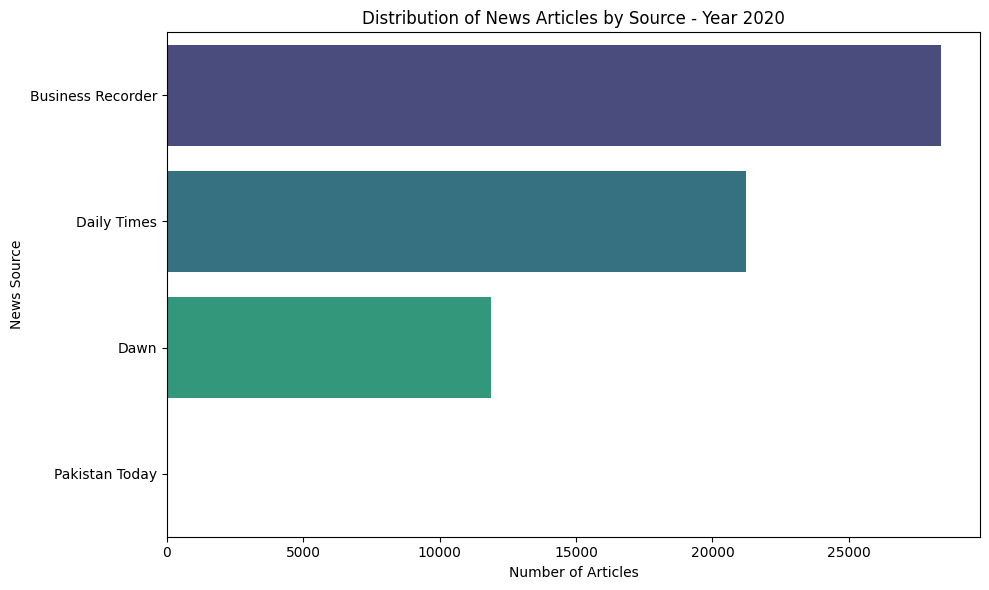

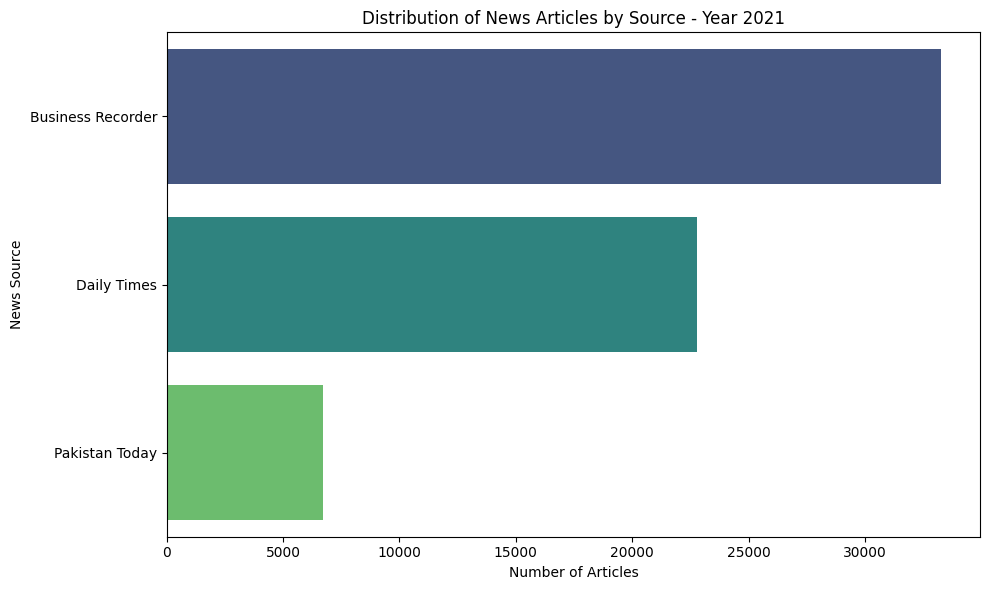

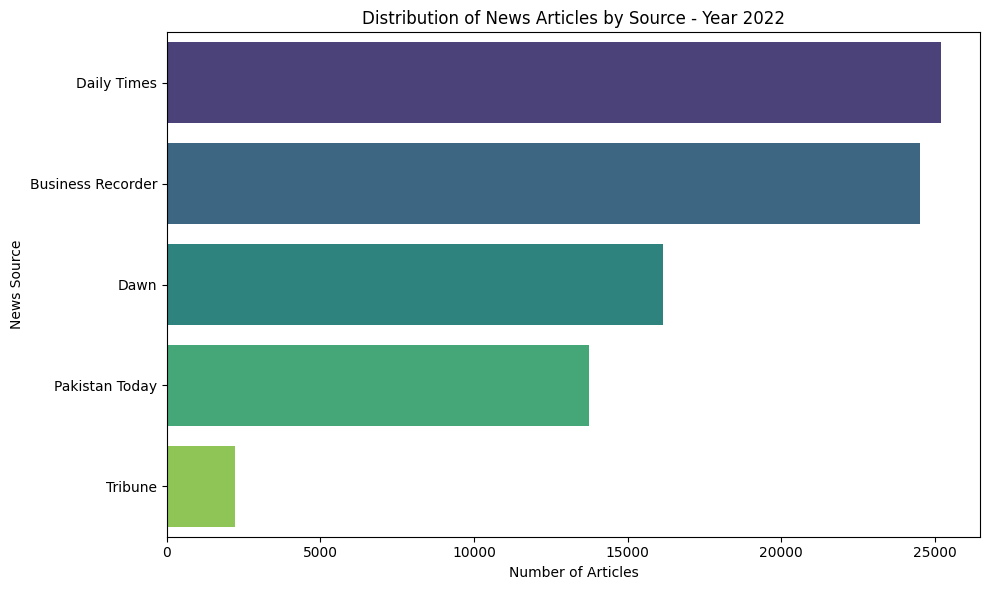

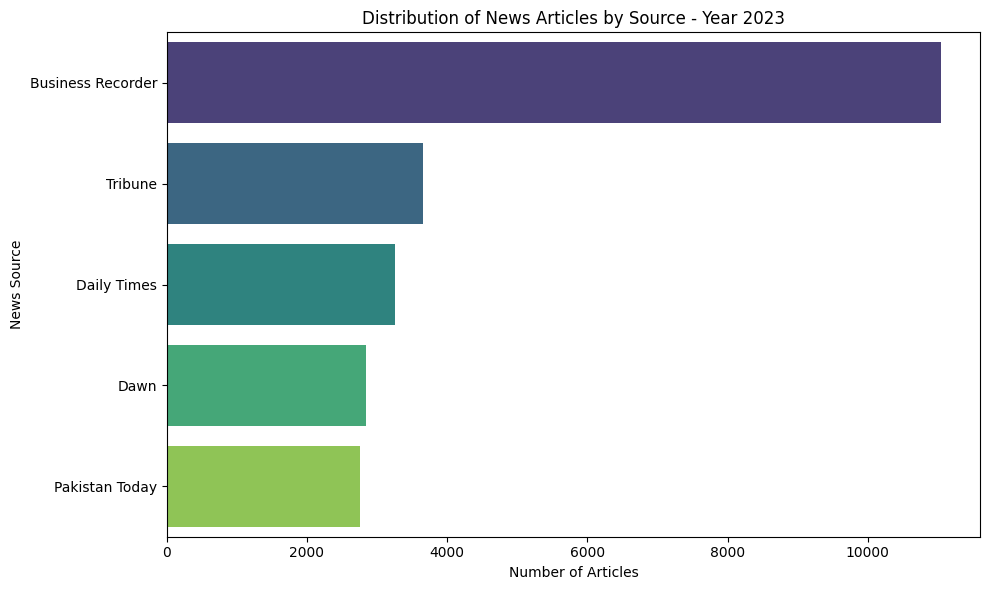

In [ ]:
for year, counts in yearly_source_counts.items():
    if not counts:
        print(f"No data for year {year}. Skipping plot.")
        continue

    # Create a DataFrame for the current year's source counts
    yearly_source_df = pd.DataFrame(list(counts.items()), columns=['Source', 'Article Count'])
    yearly_source_df = yearly_source_df.sort_values(by='Article Count', ascending=False)

    # Plot the distribution for the current year
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Article Count', y='Source', data=yearly_source_df, palette='viridis', hue='Source', legend=False)
    plt.title(f'Distribution of News Articles by Source - Year {year}')
    plt.xlabel('Number of Articles')
    plt.ylabel('News Source')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_data = []

for year, counts in yearly_source_counts.items():
    for source, count in counts.items():
        plot_data.append({
            'Year': year,
            'Source': source,
            'Article Count': count
        })

yearly_source_df_combined = pd.DataFrame(plot_data)
print("Combined yearly source DataFrame created.")
display(yearly_source_df_combined.head())

Combined yearly source DataFrame created.


Year             Source  Article Count
0  2020     Pakistan Today             31
1  2020        Daily Times          21242
2  2020               Dawn          11901
3  2020  Business Recorder          28388
4  2021     Pakistan Today           6702

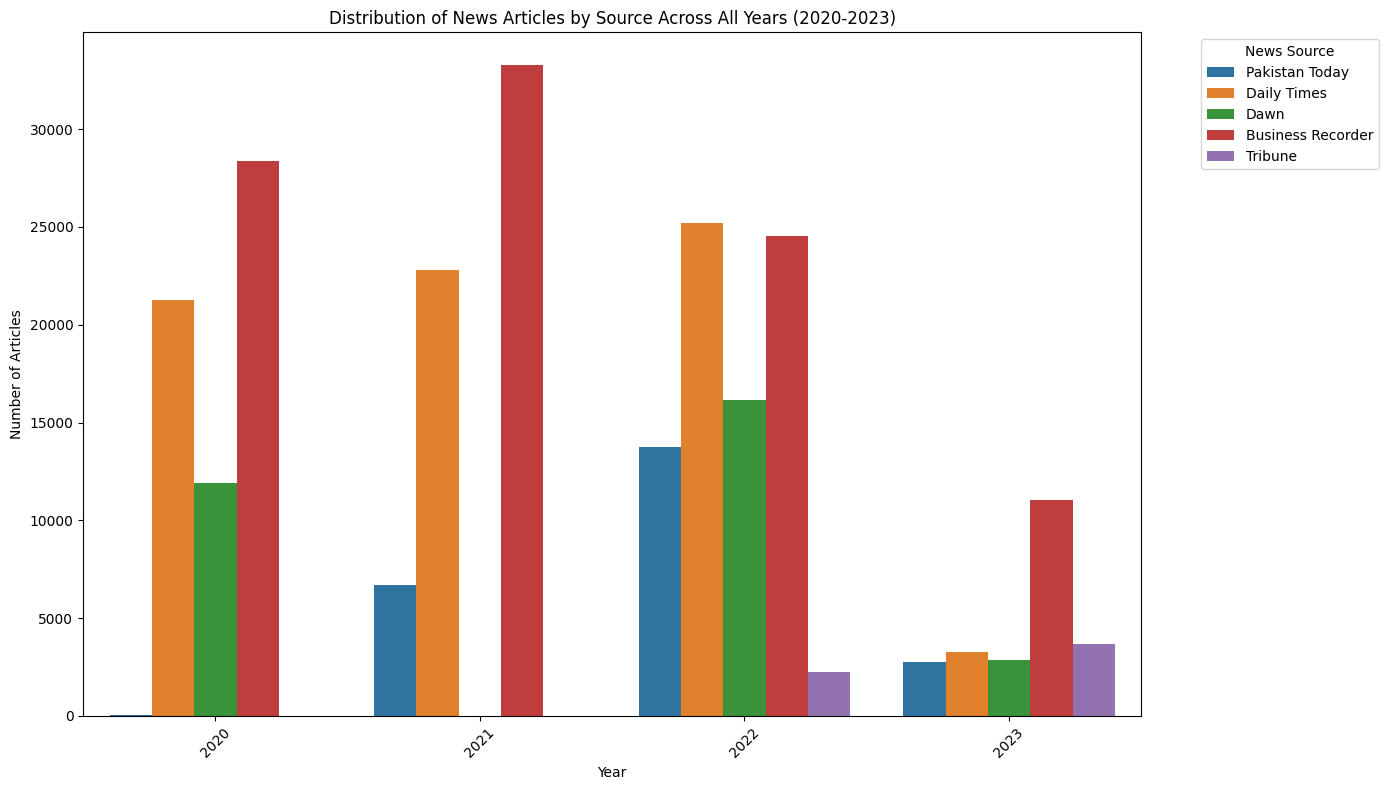

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(x='Year', y='Article Count', hue='Source', data=yearly_source_df_combined, palette='tab10')
plt.title('Distribution of News Articles by Source Across All Years (2020-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend(title='News Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## **Statistical Analysis**
**Compute mean, median, mode, variance, std, skewness for:**

* **Headline length (word count in headline)**

In [ ]:
all_headline_lengths = []

csv_chunks = pd.read_csv(combined_file_path, chunksize=chunk_size, encoding='latin-1')

print("Collecting headline lengths...")
for i, chunk in enumerate(csv_chunks):

    chunk_headline_lengths = chunk['headline'].astype(str).apply(lambda x: len(x.split()))
    all_headline_lengths.extend(chunk_headline_lengths.tolist())

print("Headline length collection complete. Calculating statistics...")

if all_headline_lengths:
    headline_lengths_series = pd.Series(all_headline_lengths)

    # Calculate statistics
    mean_length = headline_lengths_series.mean()
    median_length = headline_lengths_series.median()
    mode_length = headline_lengths_series.mode().tolist() # mode can return multiple values
    variance_length = headline_lengths_series.var()
    std_dev_length = headline_lengths_series.std()
    skewness_length = headline_lengths_series.skew()

    print("\n--- Headline Length Statistics (Word Count) ---")
    print(f"Mean: {mean_length:.2f}")
    print(f"Median: {median_length:.2f}")
    print(f"Mode: {mode_length}")
    print(f"Variance: {variance_length:.2f}")
    print(f"Standard Deviation: {std_dev_length:.2f}")
    print(f"Skewness: {skewness_length:.2f}")
else:
    print("No headline lengths found to compute statistics.")

Headline length collection complete. Calculating statistics...

--- Headline Length Statistics (Word Count) ---
Mean: 9.12
Median: 9.00
Mode: [9]
Variance: 5.85
Standard Deviation: 2.42
Skewness: 0.39


### **Description length (word count per article)**

In [ ]:
all_description_lengths = []

csv_chunks = pd.read_csv(combined_file_path, chunksize=chunk_size, encoding='latin-1')

print("Collecting description lengths...")
for i, chunk in enumerate(csv_chunks):

    chunk_description_lengths = chunk['description'].astype(str).apply(lambda x: len(x.split()) if str(x) != 'nan' else 0)
    all_description_lengths.extend(chunk_description_lengths.tolist())

print("Description length collection complete. Calculating statistics...")

if all_description_lengths:
    description_lengths_series = pd.Series(all_description_lengths)

    # Calculate statistics
    mean_length = description_lengths_series.mean()
    median_length = description_lengths_series.median()
    mode_length = description_lengths_series.mode().tolist() # mode can return multiple values
    variance_length = description_lengths_series.var()
    std_dev_length = description_lengths_series.std()
    skewness_length = description_lengths_series.skew()

    print("\n--- Description Length Statistics (Word Count) ---")
    print(f"Mean: {mean_length:.2f}")
    print(f"Median: {median_length:.2f}")
    print(f"Mode: {mode_length}")
    print(f"Variance: {variance_length:.2f}")
    print(f"Standard Deviation: {std_dev_length:.2f}")
    print(f"Skewness: {skewness_length:.2f}")
else:
    print("No description lengths found to compute statistics.")

Description length collection complete. Calculating statistics...

--- Description Length Statistics (Word Count) ---
Mean: 372.25
Median: 312.00
Mode: [108]
Variance: 64894.55
Standard Deviation: 254.74
Skewness: 3.14


### **Compute sentiment polarity (positive, neutral, negative from TextBlob)**

In [ ]:
from textblob import TextBlob
sentiment_counts = {'positive': 0, 'neutral': 0, 'negative': 0}

csv_chunks = pd.read_csv(combined_file_path, chunksize=chunk_size, encoding='latin-1')

print("Analyzing sentiment for descriptions...")
for i, chunk in enumerate(csv_chunks):
    for description in chunk['description'].dropna():
        analysis = TextBlob(description)
        if analysis.sentiment.polarity > 0: # Positive sentiment
            sentiment_counts['positive'] += 1
        elif analysis.sentiment.polarity == 0: # Neutral sentiment
            sentiment_counts['neutral'] += 1
        else: # Negative sentiment
            sentiment_counts['negative'] += 1

print("Sentiment analysis complete.")
print("\n--- Sentiment Polarity Distribution ---")
total_articles_with_description = sum(sentiment_counts.values())
for sentiment, count in sentiment_counts.items():
    percentage = (count / total_articles_with_description) * 100 if total_articles_with_description > 0 else 0
    print(f"  {sentiment.capitalize()}: {count} ({percentage:.2f}%)")


Analyzing sentiment for descriptions...
Sentiment analysis complete.

--- Sentiment Polarity Distribution ---
  Positive: 214537 (74.46%)
  Neutral: 4120 (1.43%)
  Negative: 69486 (24.12%)


### **Detect outliers (unusual long articles and extreme sentiment scores).**

In [ ]:
sentiment_by_source = {}

print("Analyzing sentiment by source...")
csv_chunks = pd.read_csv(combined_file_path, chunksize=chunk_size, encoding='latin-1')

for i, chunk in enumerate(csv_chunks):
    for index, row in chunk.iterrows():
        source = row['source']
        description = str(row['description'])

        if pd.notna(description) and description != 'nan':
            analysis = TextBlob(description)
            sentiment_type = ''
            if analysis.sentiment.polarity > 0:
                sentiment_type = 'positive'
            elif analysis.sentiment.polarity == 0:
                sentiment_type = 'neutral'
            else:
                sentiment_type = 'negative'

            if source not in sentiment_by_source:
                sentiment_by_source[source] = {'positive': 0, 'neutral': 0, 'negative': 0, 'total': 0}

            sentiment_by_source[source][sentiment_type] += 1
            sentiment_by_source[source]['total'] += 1

print("Sentiment analysis by source complete.")

print("\n--- Average Sentiment Polarity by News Source ---")
for source, sentiments in sentiment_by_source.items():
    total = sentiments['total']
    if total > 0:
        positive_percent = (sentiments['positive'] / total) * 100
        neutral_percent = (sentiments['neutral'] / total) * 100
        negative_percent = (sentiments['negative'] / total) * 100
        print(f"Source: {source}")
        print(f"  Positive: {sentiments['positive']} ({positive_percent:.2f}%)")
        print(f"  Neutral: {sentiments['neutral']} ({neutral_percent:.2f}%)")
        print(f"  Negative: {sentiments['negative']} ({negative_percent:.2f}%)\n")
    else:
        print(f"Source: {source} (No descriptions analyzed)\n")

Analyzing sentiment by source...
Sentiment analysis by source complete.

--- Average Sentiment Polarity by News Source ---
Source: Pakistan Today
  Positive: 19982 (72.86%)
  Neutral: 345 (1.26%)
  Negative: 7100 (25.89%)

Source: Daily Times
  Positive: 62269 (75.78%)
  Neutral: 800 (0.97%)
  Negative: 19101 (23.25%)

Source: Tribune
  Positive: 34709 (74.99%)
  Neutral: 257 (0.56%)
  Negative: 11318 (24.45%)

Source: Dawn
  Positive: 26176 (74.77%)
  Neutral: 77 (0.22%)
  Negative: 8756 (25.01%)

Source: Business Recorder
  Positive: 71401 (73.42%)
  Neutral: 2641 (2.72%)
  Negative: 23211 (23.87%)



In [ ]:
article_data = []

# Re-initialize csv_chunks iterator to ensure processing from the beginning
csv_chunks = pd.read_csv(combined_file_path, chunksize=chunk_size, encoding='latin-1')

print("Calculating description word counts...")
for i, chunk in enumerate(csv_chunks):
    for index, row in chunk.iterrows():
        description = str(row['description'])

        if pd.isna(row['description']):
            word_count = 0
        else:
            word_count = len(description.split())

        article_data.append({
            'description': description,
            'word_count': word_count
        })

print("Description word count calculation complete. Creating DataFrame...")

df_articles = pd.DataFrame(article_data)

print("\n--- Descriptive Statistics for Description Word Count ---")
print(df_articles['word_count'].describe())

# Calculate IQR for outlier detection
Q1 = df_articles['word_count'].quantile(0.25)
Q3 = df_articles['word_count'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

long_articles = df_articles[df_articles['word_count'] > upper_bound]

print(f"\nNumber of unusually long articles (outliers): {len(long_articles)}")
print("\nExamples of unusually long articles (first 5 descriptions):")
for desc in long_articles['description'].head(5):
    print(f"- {desc[:200]}...\n") # Print first 200 characters of description

Calculating description word counts...
Description word count calculation complete. Creating DataFrame...

--- Descriptive Statistics for Description Word Count ---
count    288150.000000
mean        372.246295
std         254.744086
min           0.000000
25%         202.000000
50%         312.000000
75%         481.000000
max        5705.000000
Name: word_count, dtype: float64

Number of unusually long articles (outliers): 9601

Examples of unusually long articles (first 5 descriptions):
- ÃÂ¢ÃÂÃÂJUI-F chief says PDM will announce the date and time of long march venue later Pakistan Democratic Movement (PDM) President Maulana Fazlur Rehman has said that the alliance will take part ...

- WASHINGTON: Evan Liberty was reading in the top bunk of his cell one evening late last month when a prison supervisor delivered news he had hoped for. ÃÂ¢ÃÂÃÂHe says, ÃÂ¢ÃÂÃÂAre you ready fo...

- ÃÂ¢ÃÂÃÂMaryam Nawaz says unless Punjab stands up, things will not change BAHAWALPUR:

In [ ]:
# Re-initialize article_data to store sentiment polarity along with descriptions
article_data = []

# Re-initialize csv_chunks iterator to ensure processing from the beginning
csv_chunks = pd.read_csv(combined_file_path, chunksize=chunk_size, encoding='latin-1')

print("Calculating sentiment polarity for descriptions...")
for i, chunk in enumerate(csv_chunks):
    for index, row in chunk.iterrows():
        description = str(row['description'])
        polarity = 0.0

        if pd.notna(row['description']) and description.strip() != '' and description != 'nan':
            analysis = TextBlob(description)
            polarity = analysis.sentiment.polarity

        article_data.append({
            'description': description,
            'sentiment_polarity': polarity
        })

print("Sentiment polarity calculation complete. Creating DataFrame...")

df_sentiment = pd.DataFrame(article_data)

print("\n--- Descriptive Statistics for Sentiment Polarity ---")
print(df_sentiment['sentiment_polarity'].describe())

# Define thresholds for extreme sentiment
extremely_positive_threshold = 0.8
extremely_negative_threshold = -0.8

extremely_positive_articles = df_sentiment[df_sentiment['sentiment_polarity'] > extremely_positive_threshold]
extremely_negative_articles = df_sentiment[df_sentiment['sentiment_polarity'] < extremely_negative_threshold]

print(f"\nNumber of extremely positive articles (polarity > {extremely_positive_threshold}): {len(extremely_positive_articles)}")
print("Examples of extremely positive articles (first 5 descriptions):")
for desc in extremely_positive_articles['description'].head(5):
    print(f"- {desc[:200]}...\n")

print(f"Number of extremely negative articles (polarity < {extremely_negative_threshold}): {len(extremely_negative_articles)}")
print("Examples of extremely negative articles (first 5 descriptions):")
for desc in extremely_negative_articles['description'].head(5):
    print(f"- {desc[:200]}...\n")

Calculating sentiment polarity for descriptions...
Sentiment polarity calculation complete. Creating DataFrame...

--- Descriptive Statistics for Sentiment Polarity ---
count    288150.000000
mean          0.053620
std           0.091641
min          -1.000000
25%           0.000000
50%           0.051593
75%           0.104818
max           1.000000
Name: sentiment_polarity, dtype: float64

Number of extremely positive articles (polarity > 0.8): 9
Examples of extremely positive articles (first 5 descriptions):
- LAHORE: Prime Minister Shehbaz Sharif on Saturday inquired after the health of Pakistan Democratic Movement (PDM) chairman and Jamiat Ulema-e-Islam-Fazl (JUI-F) chief Maulana Fazlur Rehman. The JUI-F ...

- KARACHI: Sindh Minister for Labour and Information, Saeed Ghani has invited those leaving Pakistan Tehreek-e-Insaf (PTI) to join Pakistan Peoples Party (PPP).Talking to media in Karachi on Friday, he ...

-    ISLAMABAD: Minister for Information and Broadcasting Chaudhry Fa

## **Outliers in sentiment scores (using Z-score)**

In [ ]:
# Calculate Z-scores for sentiment polarity
mean_polarity = df_sentiment['sentiment_polarity'].mean()
std_polarity = df_sentiment['sentiment_polarity'].std()

# Avoid division by zero if standard deviation is 0
if std_polarity == 0:
    print("Standard deviation of sentiment polarity is zero. No Z-score outliers can be determined.")
else:
    df_sentiment['z_score_polarity'] = (df_sentiment['sentiment_polarity'] - mean_polarity) / std_polarity

    print("\n--- Descriptive Statistics for Sentiment Polarity Z-scores ---")
    print(df_sentiment['z_score_polarity'].describe())

    # Define a threshold for outliers
    z_score_threshold = 3

    # Identify articles with extreme Z-scores
    outlier_positive_sentiment = df_sentiment[df_sentiment['z_score_polarity'] > z_score_threshold]
    outlier_negative_sentiment = df_sentiment[df_sentiment['z_score_polarity'] < -z_score_threshold]

    print(f"\nNumber of positive sentiment outliers (Z-score > {z_score_threshold}): {len(outlier_positive_sentiment)}")
    print("Examples of positive sentiment outliers (first 5 descriptions):")
    for desc in outlier_positive_sentiment['description'].head(5):
        print(f"- {desc[:200]}...\n")

    print(f"Number of negative sentiment outliers (Z-score < -{z_score_threshold}): {len(outlier_negative_sentiment)}")
    print("Examples of negative sentiment outliers (first 5 descriptions):")
    for desc in outlier_negative_sentiment['description'].head(5):
        print(f"- {desc[:200]}...\n")


--- Descriptive Statistics for Sentiment Polarity Z-scores ---
count    2.881500e+05
mean    -5.962493e-17
std      1.000000e+00
min     -1.149730e+01
25%     -5.851081e-01
50%     -2.211393e-02
75%      5.586901e-01
max      1.032708e+01
Name: z_score_polarity, dtype: float64

Number of positive sentiment outliers (Z-score > 3): 1880
Examples of positive sentiment outliers (first 5 descriptions):
- Pakistan PeopleÃÂ¢ÃÂÃÂs Party (PPP) Chairman Bilawal Bhutto-Zardari quelled any questions about dissent within the ranks of the 11-party anti-government alliance and declared that a win for the P...

- ISLAMABAD: President Dr Arif Alvi has said that transparent elections will promote and strengthen democracy in the country. The president said this while talking to Sindh Governor Imran Ismail and Pak...

- The Law Society, an organisation working for the rule of law and capacity building of the legal fraternity, is all set to host a series of lectures under the project titled ÃÂ¢ÃÂÃ

## **Box plot for sentiment scores**

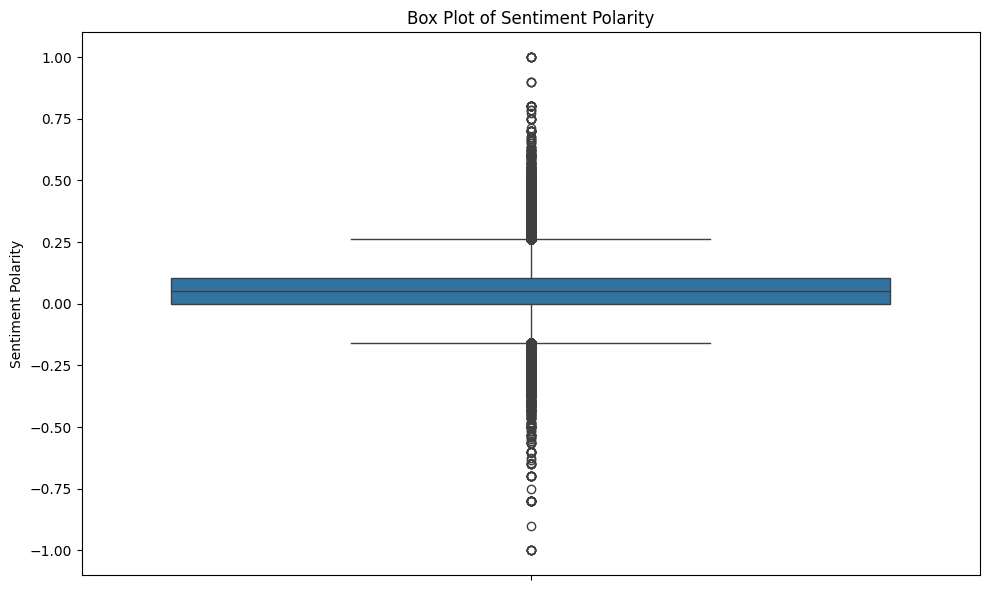

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_sentiment['sentiment_polarity'])
plt.title('Box Plot of Sentiment Polarity')
plt.ylabel('Sentiment Polarity')
plt.tight_layout()
plt.show()

## **Visualize article length distribution: Compute number of words in headline and description,  and plot histogram**

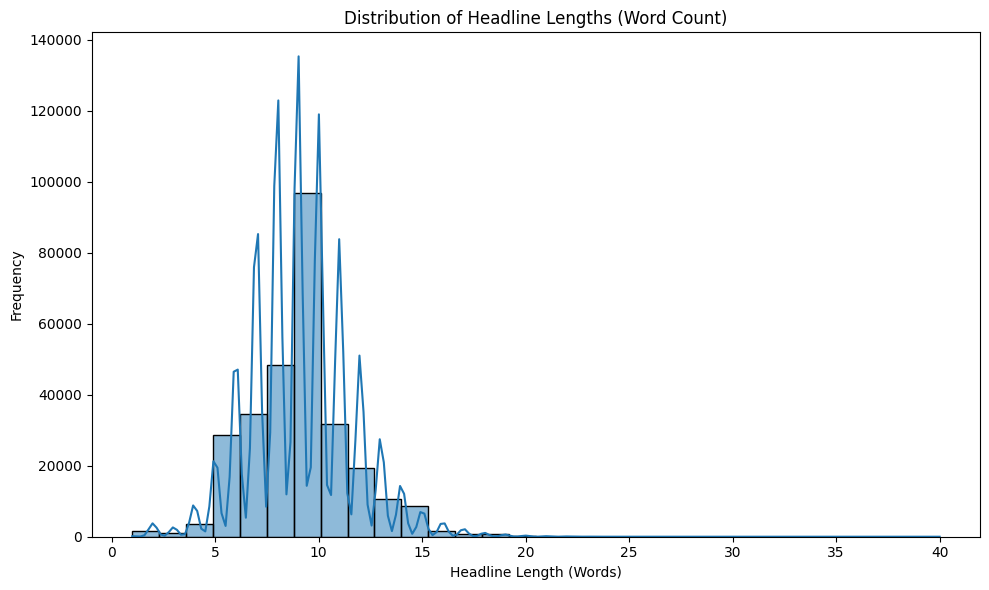

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(headline_lengths_series, bins=30, kde=True)
plt.title('Distribution of Headline Lengths (Word Count)')
plt.xlabel('Headline Length (Words)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

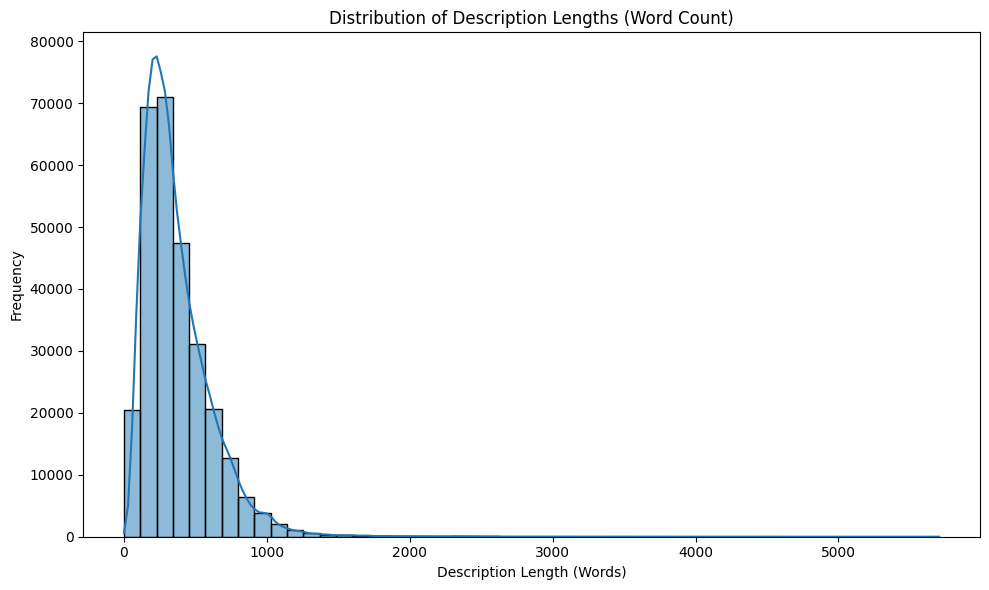

In [ ]:

plt.figure(figsize=(10, 6))
sns.histplot(df_articles['word_count'], bins=50, kde=True)
plt.title('Distribution of Description Lengths (Word Count)')
plt.xlabel('Description Length (Words)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## **Word Clouds Plots: Separate text into positive vs negative headlines.Build two word clouds.**

In [ ]:
from textblob import TextBlob

headline_sentiment_data = []

# Re-initialize csv_chunks iterator to ensure processing from the beginning
csv_chunks = pd.read_csv(combined_file_path, chunksize=chunk_size, encoding='latin-1')

print("Calculating sentiment polarity for headlines...")
for i, chunk in enumerate(csv_chunks):
    for index, row in chunk.iterrows():
        headline = str(row['headline'])
        polarity = 0.0

        if pd.notna(row['headline']) and headline.strip() != '' and headline != 'nan':
            analysis = TextBlob(headline)
            polarity = analysis.sentiment.polarity

        headline_sentiment_data.append({
            'headline': headline,
            'sentiment_polarity': polarity
        })

print("Sentiment polarity calculation for headlines complete. Creating DataFrame...")

df_headline_sentiments = pd.DataFrame(headline_sentiment_data)

print("\n--- Headline Sentiment DataFrame (First 5 Rows) ---")
display(df_headline_sentiments.head())

Calculating sentiment polarity for headlines...
Sentiment polarity calculation for headlines complete. Creating DataFrame...

--- Headline Sentiment DataFrame (First 5 Rows) ---


headline  sentiment_polarity
0  CJP to hear Karak temple attack case on Tuesda...                 0.0
1                  NAB secures 14-day remand of Asif                 0.0
2                PMC response sought in license case                 0.0
3  Saudi-led coalition strikes at Yemen capital a...                 0.0
4  Asif, another PML-N leader asked to quit party...                 0.0

In [ ]:
positive_headlines = df_headline_sentiments[df_headline_sentiments['sentiment_polarity'] > 0]
negative_headlines = df_headline_sentiments[df_headline_sentiments['sentiment_polarity'] < 0]

print(f"Number of positive headlines: {len(positive_headlines)}")
print(f"Number of negative headlines: {len(negative_headlines)}")

print("\n--- Sample Positive Headlines (First 5) ---")
display(positive_headlines.head())

print("\n--- Sample Negative Headlines (First 5) ---")
display(negative_headlines.head())

Number of positive headlines: 55899
Number of negative headlines: 37882

--- Sample Positive Headlines (First 5) ---


headline  sentiment_polarity
7   Karachi to close restaurants early, celebrate ...               0.150
10  US ÃÂ¢ÃÂÃÂgratefulÃÂ¢ÃÂÃÂ to Pakista...               0.500
11  Maryam holds PM Imran responsible for KashmirÃ...               0.200
12  NAB gets more time to file reference against f...               0.250
14  China approves first homegrown vaccine said to...               0.425


--- Sample Negative Headlines (First 5) ---


headline  sentiment_polarity
8   Federal ministers defend NAB after criticism o...           -0.050000
13  Families claim Kashmiri youths killed in encou...           -0.200000
29  Opposition knocked down due to undemocratic ta...           -0.140278
37  FIA arrests religious teacher for blackmailing...           -0.025000
48          Afghan journalist shot dead in car ambush           -0.200000

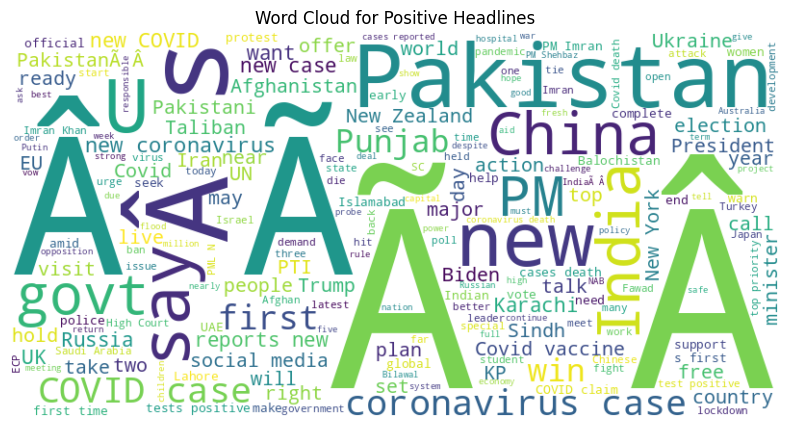

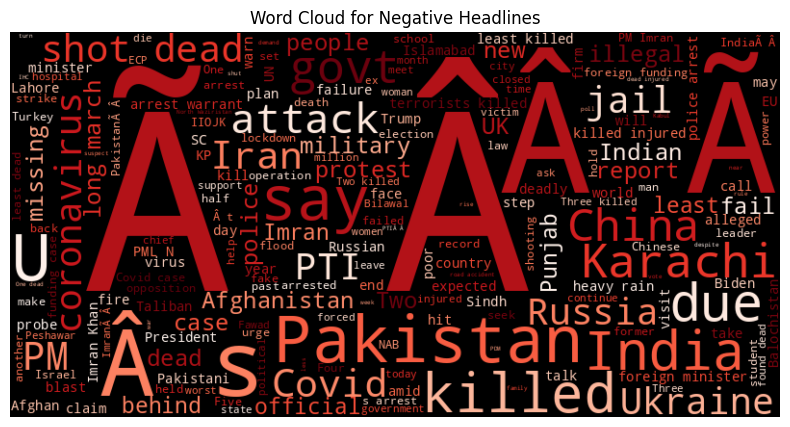

In [ ]:
from wordcloud import WordCloud

# Generate word cloud for positive headlines
positive_text = ' '.join(positive_headlines['headline'].dropna())
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Headlines')
plt.show()

# Generate word cloud for negative headlines
negative_text = ' '.join(negative_headlines['headline'].dropna())
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Headlines')
plt.show()

## **Publisher Bias:Group by source → average sentiment per publisher. Plot as horizontal bar chart.**

In [ ]:
source_sentiment_data = []

csv_chunks = pd.read_csv(combined_file_path, chunksize=chunk_size, encoding='latin-1')

print("Collecting sentiment polarity for descriptions grouped by source...")
for i, chunk in enumerate(csv_chunks):
    for index, row in chunk.iterrows():
        source = row['source']
        description = str(row['description'])
        polarity = 0.0

        # Calculate sentiment polarity if description is valid
        if pd.notna(row['description']) and description.strip() != '' and description != 'nan':
            analysis = TextBlob(description)
            polarity = analysis.sentiment.polarity

        source_sentiment_data.append({
            'source': source,
            'sentiment_polarity': polarity
        })

print("Sentiment polarity collection by source complete. Creating DataFrame...")

df_source_sentiment = pd.DataFrame(source_sentiment_data)

print("\n--- DataFrame for Source Sentiments (First 5 Rows) ---")
display(df_source_sentiment.head())

Sentiment polarity collection by source complete. Creating DataFrame...

--- DataFrame for Source Sentiments (First 5 Rows) ---


source  sentiment_polarity
0  Pakistan Today           -0.073036
1  Pakistan Today           -0.017241
2  Pakistan Today            0.053333
3  Pakistan Today           -0.003498
4  Pakistan Today           -0.016788

In [ ]:
average_sentiment_by_source = df_source_sentiment.groupby('source')['sentiment_polarity'].mean().reset_index()

print("Average sentiment polarity by source:")
display(average_sentiment_by_source)

Average sentiment polarity by source:


source  sentiment_polarity
0  Business Recorder            0.054405
1        Daily Times            0.057958
2               Dawn            0.048712
3     Pakistan Today            0.050327
4            Tribune            0.049930

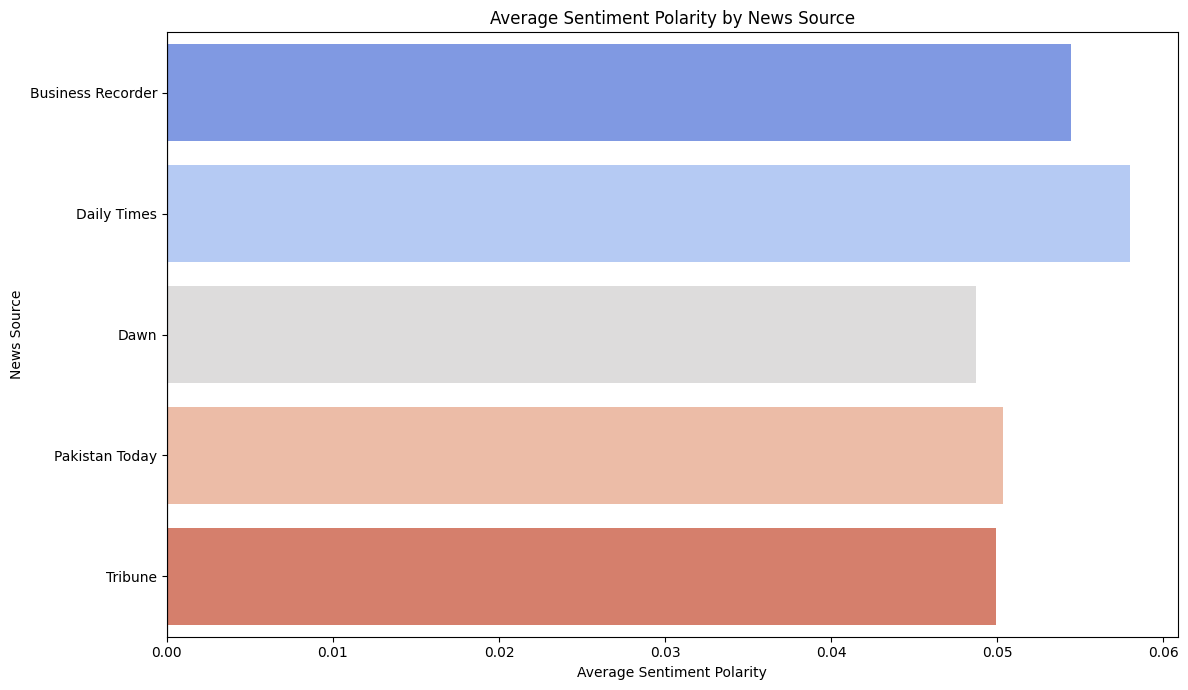

In [ ]:

plt.figure(figsize=(12, 7))
sns.barplot(x='sentiment_polarity', y='source', data=average_sentiment_by_source, palette='coolwarm', hue='source', legend=False)
plt.title('Average Sentiment Polarity by News Source')
plt.xlabel('Average Sentiment Polarity')
plt.ylabel('News Source')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

## **Visualization:**

**Boxplot of sentiment by category**


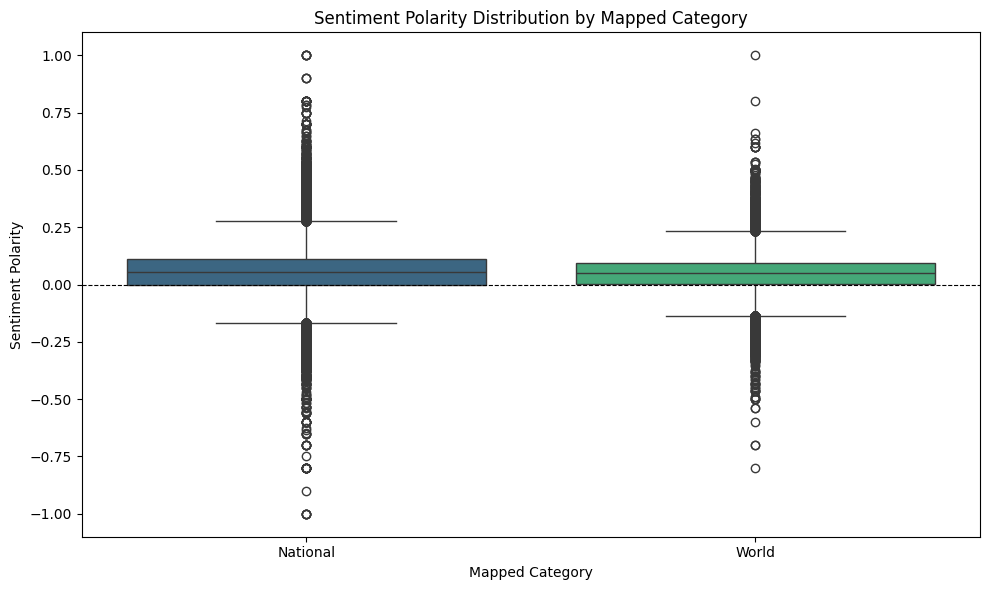

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='mapped_category', y='sentiment_polarity', data=df_category_sentiment, palette='viridis', hue='mapped_category', legend=False)
plt.title('Sentiment Polarity Distribution by Mapped Category')
plt.xlabel('Mapped Category')
plt.ylabel('Sentiment Polarity')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

# **Topic Modeling**

## **Preprocesssing**

In [ ]:
nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
lemm = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
# Lemmatization
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if token.is_alpha and not token.is_stop])

class FlexiblePreprocessor:
    def __init__(
        self,
        clean=True,
        trim=True,
        lemmatize=True,
        use_spacy=False,
        max_keep=300,
        threshold=500
    ):
        self.clean = clean
        self.trim = trim
        self.lemmatize = lemmatize
        self.use_spacy = use_spacy
        self.max_keep = max_keep
        self.threshold = threshold

    def process(self, text):
        if not isinstance(text, str):
            return ""

        if self.clean:
            text = clean_text(text)

        if self.trim:
            text = trim_description(
                text,
                max_keep=self.max_keep,
                threshold=self.threshold
            )

        if self.lemmatize:
            if self.use_spacy:
                text = lemmatize_text(text)     # spaCy
            else:
                text = fast_lemmatize(text)     # WordNet (FAST)

        return text
def clean_text(text):
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def trim_description(text, max_keep=300, threshold=500):
    words = text.split()
    if len(words) > threshold:
        return " ".join(words[:max_keep])
    return text

def fast_lemmatize(text):
    if not text:
        return ""
    return " ".join(
        lemm.lemmatize(word)
        for word in text.split()
        if word not in stop_words
    )

preprocess_config = {
    "clean": True,
    "trim": True,
    "lemmatize": True,
    "use_spacy": False,   # switch to True if you want spaCy
    "max_keep": 300,
    "threshold": 500
}

preprocessor = FlexiblePreprocessor(**preprocess_config)

national_articles = []
world_articles = []

csv_chunks = pd.read_csv(
    combined_file_path,
    chunksize=3000,
    encoding='latin-1'
)

for chunk in tqdm(csv_chunks):
    chunk['description'] = chunk['description'].fillna("")

    chunk['processed_text'] = chunk['description'].apply(
        preprocessor.process
    )

    national_articles.extend(
        chunk[chunk['mapped_categories'] == 'National']['processed_text'].tolist()
    )

    world_articles.extend(
        chunk[chunk['mapped_categories'] == 'World']['processed_text'].tolist()
    )

print(f"National articles: {len(national_articles)}")
print(f"World articles: {len(world_articles)}")

tfidf_config = {
    "max_features": 50000,
    "min_df": 5,
    "max_df": 0.8,
    "ngram_range": (1, 2)
}

tfidf_vectorizer = TfidfVectorizer(**tfidf_config)

tfidf_national = tfidf_vectorizer.fit_transform(national_articles)
tfidf_world = tfidf_vectorizer.fit_transform(world_articles)


97it [06:56,  4.30s/it]


National articles: 188703
World articles: 99447


In [ ]:
preprocess_config["lemmatize"] = False
preprocessor = FlexiblePreprocessor(**preprocess_config)


In [ ]:
preprocess_config["trim"] = False


In [ ]:
preprocess_config["use_spacy"] = True


In [ ]:
!pip install gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 32.6 MB/s eta 0:00:00


In [ ]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import numpy as np

#  Tokenize for Word2Vec
def tokenize_for_w2v(text):
    return simple_preprocess(text)  # Gensim’s simple tokenizer

# Tokenize your processed articles
national_tokens = [tokenize_for_w2v(text) for text in national_articles]
world_tokens = [tokenize_for_w2v(text) for text in world_articles]

# Train Word2Vec models
w2v_national_model = Word2Vec(
    sentences=national_tokens,
    vector_size=100,   # embedding dimension
    window=5,
    min_count=2,
    workers=4,
    sg=0,              # cbow
    epochs=10
)

w2v_world_model = Word2Vec(
    sentences=world_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=0,
    epochs=10
)

#  Convert documents to averaged Word2Vec embeddings
def average_word_vectors(tokens_list, model, vector_size=100):
    """
    tokens_list: list of tokenized documents
    model: trained Word2Vec model
    Returns: numpy array of shape (n_docs, vector_size)
    """
    features = []
    for tokens in tokens_list:
        valid_vectors = [model.wv[word] for word in tokens if word in model.wv]
        if valid_vectors:
            features.append(np.mean(valid_vectors, axis=0))
        else:
            features.append(np.zeros(vector_size))
    return np.array(features)

X_national_w2v = average_word_vectors(national_tokens, w2v_national_model, vector_size=100)
X_world_w2v = average_word_vectors(world_tokens, w2v_world_model, vector_size=100)


## **Model Implementation**

In [ ]:
from sklearn.decomposition import NMF

n_topics = 50

def run_nmf(tfidf_matrix, n_topics=50):
    nmf_model = NMF(
        n_components=n_topics,
        random_state=42,
        init='nndsvda',
        max_iter=500
    )
    W = nmf_model.fit_transform(tfidf_matrix)
    H = nmf_model.components_
    return nmf_model, W, H

print("Fitting NMF for National...")
nmf_national, W_national, H_national = run_nmf(tfidf_national, n_topics)

print("Fitting NMF for World...")
nmf_world, W_world, H_world = run_nmf(tfidf_world, n_topics)


Fitting NMF for National...
Fitting NMF for World...


In [ ]:
from sklearn.cluster import KMeans

def run_kmeans(X, n_clusters=50):
    model = KMeans(
        n_clusters=n_clusters,
        random_state=42,
        n_init=10
    )
    labels = model.fit_predict(X)
    return model, labels


In [ ]:
print("Clustering National (Word2Vec)...")
kmeans_nat, labels_nat = run_kmeans(X_national_w2v, n_clusters=50)


Clustering National (Word2Vec)...


In [ ]:
print("Clustering world (Word2Vec)...")
kmeans_world, labels_world = run_kmeans(X_world_w2v, n_clusters=50)


Clustering world (Word2Vec)...


**PRINT TOP WORDS PER TOPIC**

In [ ]:
def print_top_words(model, feature_names, n_top_words=15):
    for topic_idx, topic in enumerate(model.components_):
        top_ids = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_ids]
        print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

print("\n--- NATIONAL TOPICS ---")
print_top_words(nmf_national, tfidf_vectorizer.get_feature_names_out())

print("\n--- WORLD TOPICS ---")
print_top_words(nmf_world, tfidf_vectorizer.get_feature_names_out())



--- NATIONAL TOPICS ---
Topic 1: seen one, government insisted, would involve, country seek, portugal, moscow kremlin, advised, set ablaze, palace said, additional, monitoring group, took control, country home, afghan economy, million bpd
Topic 2: creating new, prey, imposed strict, holy quran, prime minister, holocaust, blocked road, killed russian, pandemic added, high altitude, flight south, jalisco, crisis management, itinerary, monday told
Topic 3: opec member, open business, opec oil, udupi, kong china, two military, two president, thousand dead, ugly, thousand demonstrator, kushner, uganda, thousand civilian, rosen, levelled
Topic 4: india long, last chance, india national, month political, settlement west, reproductive, recount, recounting, freelance, lavrov said, chef, reached agreement, protest sparked, protest outside, frenzied
Topic 5: la, information technology, lady jill, inflation rose, justification, justified, operating, say china, inacio lula, ignore, iea, operating 

In [ ]:
print("National articles:", len(national_articles))
print("W_national rows:", W_national.shape[0])

print("World articles:", len(world_articles))
print("W_world rows:", W_world.shape[0])


National articles: 188703
W_national rows: 188703
World articles: 99447
W_world rows: 99447


**ASSIGN A DOMINANT TOPIC TO EACH ARTICLE**

In [ ]:
national_dominant_topics = np.argmax(W_national, axis=1)
world_dominant_topics = np.argmax(W_world, axis=1)
# Create DataFrames
df_national_topics = pd.DataFrame({ 'article': national_articles, 'dominant_topic': national_dominant_topics })
df_world_topics = pd.DataFrame({ 'article': world_articles, 'dominant_topic': world_dominant_topics })

In [ ]:
df_national_topics = pd.DataFrame({
    "article": national_articles,
    "dominant_topic": national_dominant_topics
})

df_world_topics = pd.DataFrame({
    "article": world_articles,
    "dominant_topic": world_dominant_topics
})

print("National Topics Sample:")
print(df_national_topics.head())

print("\nWorld Topics Sample:")
print(df_world_topics.head())


National Topics Sample:
                                             article  dominant_topic
0  islamabad chief justice pakistan cjp gulzar ah...              30
1  lahore accountability lahore thursday granted ...              24
2  islamabad islamabad high court ihc issued noti...               1
3  lahore former national assembly na speaker aya...              24
4  islamabad accountability court islamabad wedne...              24

World Topics Sample:
                                             article  dominant_topic
0  aden saudi led coalition warplane struck targe...              43
1  chinese health regulator said thursday given c...               6
2  taipei beijing two u warship sailed sensitive ...              42
3  sydney sydney harbour bridge acropolis firewor...              48
4  islamabad young pakistani girl emma alam th wo...              25


###**Automatic topic labels**

In [ ]:
national_topic_labels = {
    1: "Pakistan Politics & Economy",
    2: "Religion, Global Events & Crisis",
    3: "OPEC, Energy & International Affairs",
    4: "India-Related Political News",
    5: "Technology & Economy",
    6: "Military & Security Operations",
    7: "Preservation & Humanitarian News",
    8: "Health, Quarantine & Cooperation",
    9: "Elections & Pollution Issues",
    10: "China-Related News & Policy",
    11: "Tribunals, Judiciary & Security",
    12: "Norway & Protests",
    13: "France & Europe News",
    14: "China-Kong & International Conflict",
    15: "Forecasts, Investments & Global Affairs",
    16: "Asia Regional Conflicts & Security",
    17: "Political Recounts & State Affairs",
    18: "Regulatory & International Cooperation",
    19: "War Allegations & Human Rights",
    20: "Military & Government Operations",
    21: "Sports & Diplomacy",
    22: "Vaccines & Healthcare Updates",
    23: "Police, Preservation & Nepal Events",
    24: "Military & Government Statements",
    25: "Research, Security & International Terrorism",
    26: "Government Aid & Local Affairs",
    27: "Foreign Aid & Energy Issues",
    28: "China Economy & Government Support",
    29: "Diplomacy & Security Measures",
    30: "UN & International Oversight",
    31: "Russia-Related Military News",
    32: "Putin & Russian Government",
    33: "British Royal Family & Events",
    34: "Ukraine-Russia Conflict",
    35: "Health & COVID-19 Updates",
    36: "France & Macron Administration",
    37: "UAE & Middle East Diplomacy",
    38: "COVID Variants & Global Health",
    39: "Biden Administration & USA Politics",
    40: "Women, Education & Rights",
    41: "Sudan & Military Conflicts",
    42: "Social Media Platforms & Technology",
    43: "Taiwan-China Relations & Military",
    44: "Syria-Iraq Attacks & Militancy",
    45: "Finance, IMF & Economy",
    46: "Oil, Energy & Global Market",
    47: "Migrant & Refugee Crisis",
    48: "Azerbaijan-Armenia Conflict",
    49: "New Zealand & Australia News",
    50: "Space Exploration & Technology"
}
world_topic_labels = {
    1: "NATO & Military Alliances",
    2: "COVID-19 & Global Health",
    3: "Afghanistan & Taliban",
    4: "Trump & US Politics",
    5: "Police & Protests",
    6: "Iran & Nuclear Deal",
    7: "COVID Vaccination Updates",
    8: "China & Foreign Policy",
    9: "Israel-Palestine Conflict",
    10: "North & South Korea Relations",
    11: "India Politics & Modi Administration",
    12: "Nuclear Weapons & Agreements",
    13: "Saudi Arabia & Middle East",
    14: "UK Politics & Boris Johnson",
    15: "Natural Disasters & Rescue Operations",
    16: "Global Deaths & COVID Statistics",
    17: "Economy, Inflation & Jobs",
    18: "EU & European Union Affairs",
    19: "Turkey & Regional Politics",
    20: "Japan Politics & Foreign Relations",
    21: "Sri Lanka Economic Crisis",
    22: "Pakistan & Regional Affairs",
    23: "Aviation & Flight Incidents",
    24: "Elections & Political Polls",
    25: "Myanmar & Political Unrest",
    26: "Hong Kong & Security Law",
    27: "Climate Change & Global Warming",
    28: "UN & Human Rights",
    29: "Kashmir & India-Pakistan Disputes",
    30: "Courts & Justice Systems",
    31: "Russia-Ukraine Conflict",
    32: "Putin & Russia Leadership",
    33: "British Royal Family & Monarchy",
    34: "Ukraine War & Military Updates",
    35: "COVID Cases & Health Statistics",
    36: "Macron & French Politics",
    37: "UAE & Middle East Relations",
    38: "COVID Variants & Global Spread",
    39: "Biden Administration & US Affairs",
    40: "Women & Education Rights",
    41: "Sudan & Civil Conflicts",
    42: "Social Media Platforms",
    43: "Taiwan & China Military Relations",
    44: "Syria & Iraq Attacks",
    45: "Global Economy & IMF",
    46: "Oil, Energy & Global Market",
    47: "Migrants & Refugees",
    48: "Azerbaijan-Armenia Conflict",
    49: "New Zealand & Australia News",
    50: "Space Exploration & Technology"
}


In [ ]:
# National
df_national_topics['topic_label'] = df_national_topics['dominant_topic'].map(national_topic_labels)

# World
df_world_topics['topic_label'] = df_world_topics['dominant_topic'].map(world_topic_labels)


### **Topic Keywords Dictionary**

In [ ]:
national_topic_keywords = {
    1: ['seen one', 'government insisted', 'would involve', 'country seek', 'portugal'],
    2: ['creating new', 'prey', 'imposed strict', 'holy quran', 'prime minister'],
    3: ['opec member', 'open business', 'opec oil', 'udupri', 'kong china'],
    4: ['india long', 'last chance', 'india national', 'month political', 'settlement west'],
    5: ['la', 'information technology', 'lady jill', 'inflation rose', 'justification'],
    6: ['proxy', 'talk said', 'pulled back', 'attack iraq', 'ordered closure'],
    7: ['preservation', 'warmly', 'allow country', 'german health', 'discussed'],
    8: ['engaging', 'emerged december', 'commit', 'enhance cooperation', 'qualified'],
    9: ['ahead presidential', 'agreement said', 'toll rising', 'pollution control', 'path'],
    10: ['resorting', 'chinese ministry', 'chinese academy', 'clue', 'campaigner'],
    11: ['tribunal', 'source income', 'sortie', 'found three', 'jew temple'],
    12: ['norwegian', 'protesting', 'state institution', 'mercury', 'nothing said'],
    13: ['fox', 'france european', 'ri', 'monitoring group', 'starmer'],
    14: ['stop war', 'kong china', 'straddling', 'government insisted', 'standard said'],
    15: ['forecast year', 'said following', 'agnes callamard', 'portugal', 'forecaster said'],
    16: ['creating new', 'case likely', 'belligerent', 'across asia', 'high altitude'],
    17: ['monitoring group', 'recounting', 'recount', 'month political', 'state sponsored'],
    18: ['regulatory authority', 'dinner', 'scheduling', 'cooperation said', 'world richest'],
    19: ['forced take', 'pro kremlin', 'alleged war', 'police commander', 'allen'],
    20: ['repression', 'plane helicopter', 'locked', 'transferred hospital', 'internet'],
    21: ['skirt', 'emirate', 'tennis', 'employee said', 'township'],
    22: ['astrazeneca', 'cocktail', 'get infected', 'benghazi', 'jew temple'],
    23: ['police used', 'preservation', 'standard said', 'jesus', 'occasionally'],
    24: ['country according', 'manages', 'sunday three', 'cuomo said', 'synagogue'],
    25: ['new research', 'achievement', 'called member', 'country exclude', 'noisy'],
    26: ['house say', 'help government', 'police used', 'military source', 'earlier'],
    27: ['bosnia', 'mohib', 'year help', 'preservation', 'including foreign'],
    28: ['put forward', 'chinese telecom', 'captain', 'archive', 'drug trafficking'],
    29: ['christophe', 'circulated social', 'cut diplomatic', 'path', 'cia'],
    30: ['path', 'came amid', 'un geneva', 'inspect', 'sombre'],
    31: ['killed russian', 'creating new', 'key sticking', 'three week', 'three woman'],
    32: ['reconciliation', 'government called', 'predicted', 'gunman', 'make landfall'],
    33: ['west city', 'dead four', 'scene', 'day police', 'inquiry'],
    34: ['right violation', 'white party', 'multiple', 'transport link', 'fair share'],
    35: ['international criminal', 'indian capital', 'said source', 'food medicine', 'house say'],
    36: ['world dangerous', 'say china', 'get country', 'go far', 'chinese telecom'],
    37: ['walked', 'waking', 'eas', 'cuomo said', 'novelist'],
    38: ['case likely', 'said pointing', 'declined', 'country according', 'human development'],
    39: ['tough sanction', 'first formal', 'saturated', 'two key', 'significant'],
    40: ['community take', 'border state', 'million tonne', 'annual trade', 'spaceship'],
    41: ['within km', 'foreign resident', 'former soviet', 'thailand reported', 'mohamad'],
    42: ['single family', 'ascent', 'single person', 'hazmat', 'brazen'],
    43: ['five time', 'million bpd', 'islamic rooted', 'air bridge', 'key demand'],
    44: ['video posted', 'tennis', 'eastern based', 'china also', 'washington'],
    45: ['real total', 'annexing', 'assisted', 'assisting', 'eastern france'],
    46: ['rank file', 'plane helicopter', 'border russia', 'zabiullah', 'boost trade'],
    47: ['climate science', 'climate talk', 'china call', 'would appeal', 'union sanction'],
    48: ['rajiv gandhi', 'generosity', 'concern country', 'environmental activist', 'europe hardest'],
    49: ['northwestern', 'people israel', 'northern tigray', 'align', 'member congress'],
    50: ['authority state', 'supportive', 'palace said', 'nominating', 'spread delta']
}
world_topic_keywords = {
    1: ['nato', 'stoltenberg', 'alliance', 'finland', 'sweden'],
    2: ['virus', 'health', 'coronavirus', 'covid', 'patient'],
    3: ['taliban', 'afghan', 'afghanistan', 'kabul', 'government'],
    4: ['trump', 'donald', 'donald trump', 'president', 'republican'],
    5: ['police', 'officer', 'protest', 'police said', 'protester'],
    6: ['iran', 'iranian', 'tehran', 'sanction', 'islamic republic'],
    7: ['vaccine', 'dos', 'covid vaccine', 'astrazeneca', 'pfizer'],
    8: ['china', 'chinese', 'beijing', 'xi', 'wang'],
    9: ['palestinian', 'israeli', 'israel', 'gaza', 'west bank'],
    10: ['korea', 'north', 'north korea', 'korean', 'south'],
    11: ['india', 'indian', 'modi', 'delhi', 'new delhi'],
    12: ['nuclear', 'deal', 'iaea', 'plant', 'talk'],
    13: ['saudi', 'arabia', 'saudi arabia', 'riyadh', 'yemen'],
    14: ['johnson', 'britain', 'london', 'british', 'uk'],
    15: ['people', 'rain', 'fire', 'quake', 'earthquake'],
    16: ['death case', 'death', 'case', 'new death', 'country'],
    17: ['rate', 'percent', 'inflation', 'economy', 'year'],
    18: ['eu', 'european', 'brussels', 'european union', 'union'],
    19: ['turkey', 'erdogan', 'turkish', 'ankara', 'tayyip'],
    20: ['minister', 'prime', 'prime minister', 'japan', 'foreign'],
    21: ['sri', 'lanka', 'sri lanka', 'rajapaksa', 'colombo'],
    22: ['pakistan', 'pakistani', 'islamabad', 'afghanistan', 'khan'],
    23: ['flight', 'airline', 'airport', 'passenger', 'plane'],
    24: ['election', 'party', 'vote', 'poll', 'opposition'],
    25: ['myanmar', 'kyi', 'suu', 'suu kyi', 'junta'],
    26: ['hong', 'kong', 'hong kong', 'law', 'security law'],
    27: ['climate', 'climate change', 'change', 'emission', 'temperature'],
    28: ['un', 'united', 'council', 'united nation', 'nation'],
    29: ['kashmir', 'indian', 'kashmiri', 'jammu', 'jammu kashmir'],
    30: ['court', 'judge', 'justice', 'trial', 'prison'],
    31: ['russian', 'ukrainian', 'kyiv', 'force', 'russian force'],
    32: ['putin', 'russia', 'russian', 'moscow', 'vladimir'],
    33: ['queen', 'royal', 'prince', 'elizabeth', 'harry'],
    34: ['ukraine', 'russia', 'war', 'invasion', 'kyiv'],
    35: ['case', 'death', 'infection', 'reported', 'new'],
    36: ['macron', 'french', 'france', 'paris', 'emmanuel'],
    37: ['uae', 'arab', 'emirate', 'israel', 'dubai'],
    38: ['variant', 'omicron', 'africa', 'covid', 'south africa'],
    39: ['biden', 'joe', 'joe biden', 'house', 'president'],
    40: ['woman', 'school', 'girl', 'student', 'right'],
    41: ['sudan', 'khartoum', 'army', 'force', 'sudanese'],
    42: ['twitter', 'musk', 'company', 'medium', 'social'],
    43: ['taiwan', 'island', 'china', 'taipei', 'military'],
    44: ['attack', 'killed', 'syria', 'iraq', 'strike'],
    45: ['billion', 'bank', 'debt', 'fund', 'imf'],
    46: ['oil', 'price', 'energy', 'gas', 'supply'],
    47: ['migrant', 'border', 'refugee', 'boat', 'mexico'],
    48: ['azerbaijan', 'armenia', 'armenian', 'karabakh', 'nagorno'],
    49: ['zealand', 'new zealand', 'australia', 'ardern', 'new'],
    50: ['space', 'rocket', 'mission', 'launch', 'nasa']
}


In [ ]:
def generate_topic_labels(topic_keywords, top_n=3):
    """
    Automatically generate topic labels from keywords.

    Args:
        topic_keywords (dict): Dictionary of {topic_id: [list of keywords]}.
        top_n (int): Number of top keywords to include in the label.

    Returns:
        dict: {topic_id: auto-generated label}.
    """
    topic_labels = {}
    for topic_id, keywords in topic_keywords.items():
        # Take the first top_n keywords
        label_keywords = keywords[:top_n]
        # Join them with commas and capitalize the first word
        label = ", ".join(label_keywords).capitalize()
        topic_labels[topic_id] = label
    return topic_labels


In [ ]:
auto_national_labels = generate_topic_labels(national_topic_keywords, top_n=3)
df_national_topics['auto_label'] = df_national_topics['dominant_topic'].map(auto_national_labels)

auto_world_labels = generate_topic_labels(world_topic_keywords, top_n=3)
df_world_topics['auto_label'] = df_world_topics['dominant_topic'].map(auto_world_labels)


### **Combine Label**

In [ ]:
# Combine manual and automatic labels
df_national_topics['combined_label'] = df_national_topics.apply(
    lambda row: row['topic_label'] if pd.notna(row['topic_label'])
                else row['auto_label'], axis=1
)

df_national_topics['combined_label_with_keywords'] = df_national_topics.apply(
    lambda row: f"{row['topic_label']} ({row['auto_label']})"
                if pd.notna(row['topic_label']) else row['auto_label'], axis=1
)

df_world_topics['combined_label'] = df_world_topics.apply(
    lambda row: row['topic_label'] if pd.notna(row['topic_label'])
                else row['auto_label'], axis=1
)

df_world_topics['combined_label_with_keywords'] = df_world_topics.apply(
    lambda row: f"{row['topic_label']} ({row['auto_label']})"
                if pd.notna(row['topic_label']) else row['auto_label'], axis=1
)


### **Usage**


In [ ]:
#  Function to Display Article Info

def show_article_info(df, idx=0):
    article = df.iloc[idx]
    print(f"Article Index: {idx}")
    print(f"Original Text: {article['article'][:300]}...")  # print first 300 chars
    print(f"Dominant Topic ID: {article['dominant_topic']}")
    print(f"Manual Label: {article['topic_label']}")
    print(f"Auto Label: {article['auto_label']}")
    print(f"Combined Label: {article['combined_label']}")
    print(f"Combined Label with Keywords: {article['combined_label_with_keywords']}")
    print("\n" + "-"*50 + "\n")

# Example usage:
show_article_info(df_national_topics, idx=0)
show_article_info(df_world_topics, idx=0)


Article Index: 0
Original Text: islamabad chief justice pakistan cjp gulzar ahmed hear suo motu case burning hindu temple karak january next year cjp issuing notice also directed chairman minority right commission inspector general police chief secretary khyber pakhtunkhwa kp submit report incident january separately cjp also met ...
Dominant Topic ID: 30
Manual Label: UN & International Oversight
Auto Label: Path, came amid, un geneva
Combined Label: UN & International Oversight
Combined Label with Keywords: UN & International Oversight (Path, came amid, un geneva)

--------------------------------------------------

Article Index: 0
Original Text: aden saudi led coalition warplane struck target yemen houthi held capital sanaa thursday retaliation attack southern port city aden previous day took place official government backed riyadh arrived coalition accused houthi movement fighting six year staging attack aden airport second one presidentia...
Dominant Topic ID: 43
Manual Label: Ta

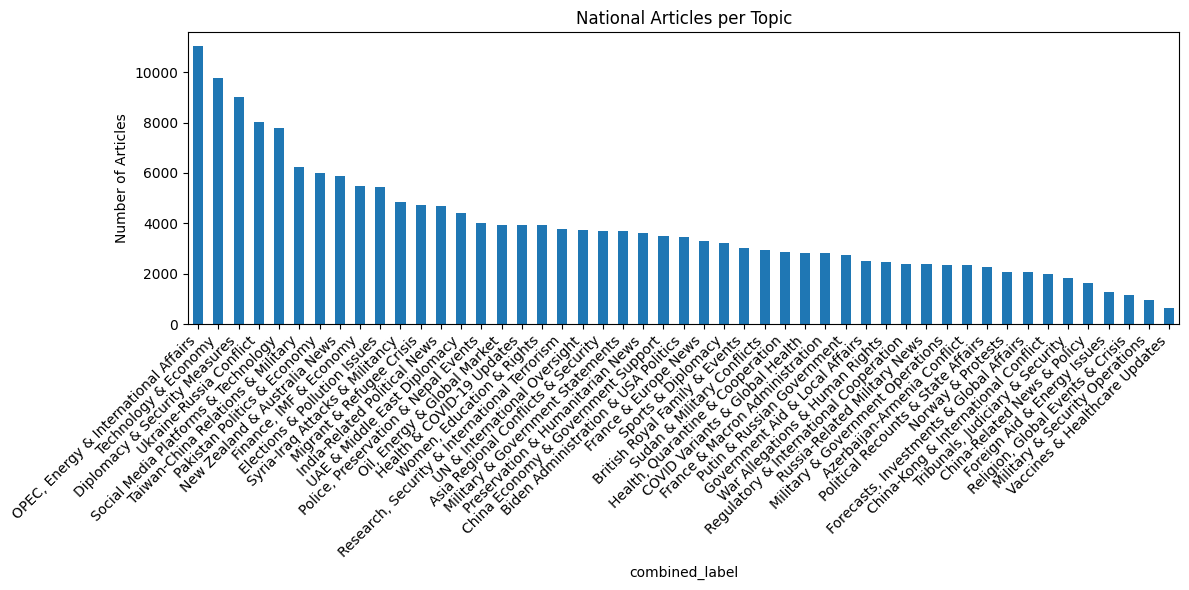

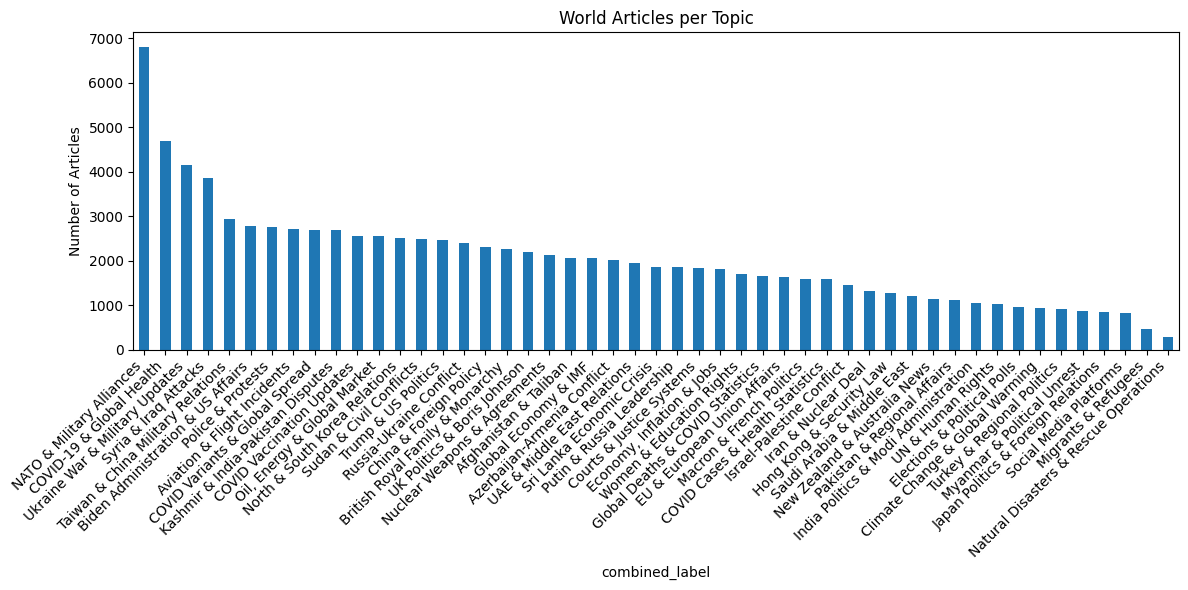

In [ ]:
# Count Articles per Topic

def plot_topic_counts(df, label_col='combined_label', title="Topic Distribution"):
    topic_counts = df[label_col].value_counts()
    plt.figure(figsize=(12,6))
    topic_counts.plot(kind='bar')
    plt.title(title)
    plt.ylabel("Number of Articles")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage:
plot_topic_counts(df_national_topics, title="National Articles per Topic")
plot_topic_counts(df_world_topics, title="World Articles per Topic")

In [ ]:
#  Filter Articles by Topic

def get_articles_by_topic(df, topic_name, label_col='combined_label'):
    return df[df[label_col] == topic_name]['article'].tolist()

# Example usage:
pakistan_articles = get_articles_by_topic(df_national_topics, "Pakistan Politics & Economy")
print(f"Number of articles in 'Pakistan Politics & Economy': {len(pakistan_articles)}")
print("Sample article:\n", pakistan_articles[0][:500], "...")

Number of articles in 'Pakistan Politics & Economy': 6009
Sample article:
 islamabad islamabad high court ihc issued notice pakistan medical commission pmc case pertaining cancellation doctor practice license bench led newly appointed justice babar sattar heard petition seeking restraining order cancellation license hearing plaintiff informed court client license revoked two year ago claimed botched operation said medical tribunal formed look matter inquiry remained inactive justice sattar observed court could issue stay order without hearing pmc version issued notice  ...


## **Summary Table**

In [ ]:
# Function to get top keywords per topic from NMF H matrix
def get_top_keywords(model, feature_names, n_top_words=10):
    topic_keywords = {}
    for topic_idx, topic in enumerate(model.components_):
        top_ids = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_ids]
        topic_keywords[topic_idx + 1] = top_words
    return topic_keywords

# National Topics Summary
national_top_keywords = get_top_keywords(nmf_national, tfidf_vectorizer.get_feature_names_out(), n_top_words=10)

summary_national = df_national_topics.groupby('dominant_topic').agg(
    article_count=('article', 'count')
).reset_index()

summary_national['topic_label'] = summary_national['dominant_topic'].map(national_topic_labels)
summary_national['auto_label'] = summary_national['dominant_topic'].map(auto_national_labels)
summary_national['top_keywords'] = summary_national['dominant_topic'].map(national_top_keywords)

summary_national = summary_national.sort_values('dominant_topic')

print("National Topics Summary Table:")
display(summary_national)

# World Topics Summary
world_top_keywords = get_top_keywords(nmf_world, tfidf_vectorizer.get_feature_names_out(), n_top_words=10)

summary_world = df_world_topics.groupby('dominant_topic').agg(
    article_count=('article', 'count')
).reset_index()

summary_world['topic_label'] = summary_world['dominant_topic'].map(world_topic_labels)
summary_world['auto_label'] = summary_world['dominant_topic'].map(auto_world_labels)
summary_world['top_keywords'] = summary_world['dominant_topic'].map(world_top_keywords)

summary_world = summary_world.sort_values('dominant_topic')

print("World Topics Summary Table:")
display(summary_world)


National Topics Summary Table:


dominant_topic  article_count  \
0                0             87   
1                1           6009   
2                2           1152   
3                3          11036   
4                4           4684   
5                5           9771   
6                6            945   
7                7           3630   
8                8           2870   
9                9           5432   
10              10           1625   
11              11           1841   
12              12           2077   
13              13           3285   
14              14           1988   
15              15           2070   
16              16           3697   
17              17           2252   
18              18           2386   
19              19           2460   
20              20           2351   
21              21           3227   
22              22            623   
23              23           3995   
24              24           3690   
25              25           3771   
26              26           2510   
27              27           1282   
28              28           3488   
29              29           9025   
30              30           3743   
31              31           2383   
32              32           2742   
33              33           3022   
34              34           8020   
35              35           3926   
36              36           2803   
37              37           4411   
38              38           2832   
39              39           3442   
40              40           3920   
41              41           2944   
42              42           7787   
43              43           6247   
44              44           4863   
45              45           5472   
46              46           3934   
47              47           4732   
48              48           2345   
49              49           5876   

                                     topic_label  \
0                                            NaN   
1                    Pakistan Politics & Economy   
2               Religion, Global Events & Crisis   
3           OPEC, Energy & International Affairs   
4                   India-Related Political News   
5                           Technology & Economy   
6                 Military & Security Operations   
7               Preservation & Humanitarian News   
8               Health, Quarantine & Cooperation   
9                   Elections & Pollution Issues   
10                   China-Related News & Policy   
11               Tribunals, Judiciary & Security   
12                             Norway & Protests   
13                          France & Europe News   
14           China-Kong & International Conflict   
15       Forecasts, Investments & Global Affairs   
16            Asia Regional Conflicts & Security   
17            Political Recounts & State Affairs   
18        Regulatory & International Cooperation   
19                War Allegations & Human Rights   
20              Military & Government Operations   
21                            Sports & Diplomacy   
22                 Vaccines & Healthcare Updates   
23           Police, Preservation & Nepal Events   
24              Military & Government Statements   
25  Research, Security & International Terrorism   
26                Government Aid & Local Affairs   
27                   Foreign Aid & Energy Issues   
28            China Economy & Government Support   
29                 Diplomacy & Security Measures   
30                  UN & International Oversight   
31                  Russia-Related Military News   
32                    Putin & Russian Government   
33                 British Royal Family & Events   
34                       Ukraine-Russia Conflict   
35                     Health & COVID-19 Updates   
36                France & Macron Administration   
37                   UAE & Middle East Diplomacy   
38                COVID Variants & Global Health   
39           Biden Administration & 

World Topics Summary Table:


dominant_topic  article_count                            topic_label  \
0                0            157                                    NaN   
1                1           6795              NATO & Military Alliances   
2                2           4700               COVID-19 & Global Health   
3                3           2065                  Afghanistan & Taliban   
4                4           2456                    Trump & US Politics   
5                5           2755                      Police & Protests   
6                6           1323                    Iran & Nuclear Deal   
7                7           2554              COVID Vaccination Updates   
8                8           2303                 China & Foreign Policy   
9                9           1456              Israel-Palestine Conflict   
10              10           2512          North & South Korea Relations   
11              11           1041   India Politics & Modi Administration   
12              12           2130           Nuclear Weapons & Agreements   
13              13           1212             Saudi Arabia & Middle East   
14              14           2207            UK Politics & Boris Johnson   
15              15            284  Natural Disasters & Rescue Operations   
16              16           1660       Global Deaths & COVID Statistics   
17              17           1806              Economy, Inflation & Jobs   
18              18           1637            EU & European Union Affairs   
19              19            924             Turkey & Regional Politics   
20              20            850     Japan Politics & Foreign Relations   
21              21           1854              Sri Lanka Economic Crisis   
22              22           1118            Pakistan & Regional Affairs   
23              23           2706            Aviation & Flight Incidents   
24              24            968            Elections & Political Polls   
25              25            871             Myanmar & Political Unrest   
26              26           1272               Hong Kong & Security Law   
27              27            939        Climate Change & Global Warming   
28              28           1033                      UN & Human Rights   
29              29           2695      Kashmir & India-Pakistan Disputes   
30              30           1831               Courts & Justice Systems   
31              31           2404                Russia-Ukraine Conflict   
32              32           1852              Putin & Russia Leadership   
33              33           2263        British Royal Family & Monarchy   
34              34           4163         Ukraine War & Military Updates   
35              35           1581        COVID Cases & Health Statistics   
36              36           1584               Macron & French Politics   
37              37           1947            UAE & Middle East Relations   
38              38           2699         COVID Variants & Global Spread   
39              39           2783      Biden Administration & US Affairs   
40              40           1707               Women & Education Rights   
41              41           2500                Sudan & Civil Conflicts   
42              42            826                 Social Media Platforms   
43              43           2936      Taiwan & China Military Relations   
44              44           3870                   Syria & Iraq Attacks   
45              45           2053                   Global Economy & IMF   
46              46           2550            Oil, Energy & Global Market   
47              47            456                    Migrants & Refugees   
48              48           2015            Azerbaijan-Armenia Conflict   
49              49           1144           New Zealand & Australia News   

                         auto_label  \
0                               NaN   
1       Nato, stoltenberg, alliance   
2        V

## **Visualization**

**Word Clouds per Topic**

In [ ]:
from wordcloud import WordCloud

def plot_wordclouds(df, title_prefix="Topic"):
    for topic_id in sorted(df['dominant_topic'].unique()):
        text = " ".join(df[df['dominant_topic']==topic_id]['article'])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10,5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"{title_prefix} {topic_id}: {df[df['dominant_topic']==topic_id]['auto_label'].values[0]}")
        plt.show()

# National Word Clouds
plot_wordclouds(df_national_topics, "National Topic")

# World Word Clouds
plot_wordclouds(df_world_topics, "World Topic")


**Top Keywords per Topic (Graph)**

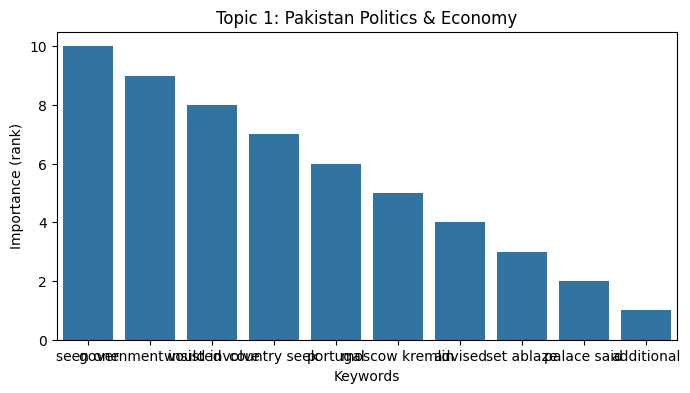

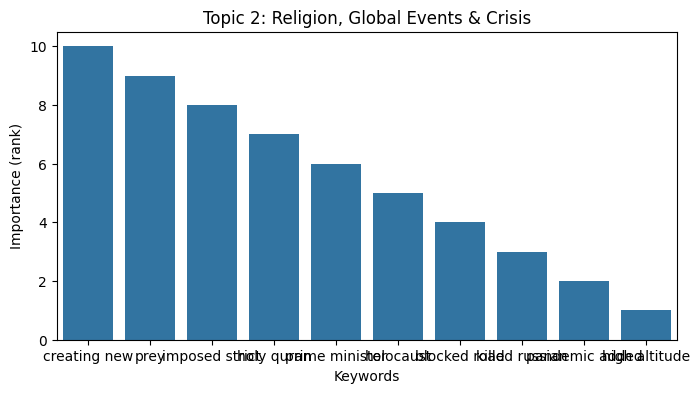

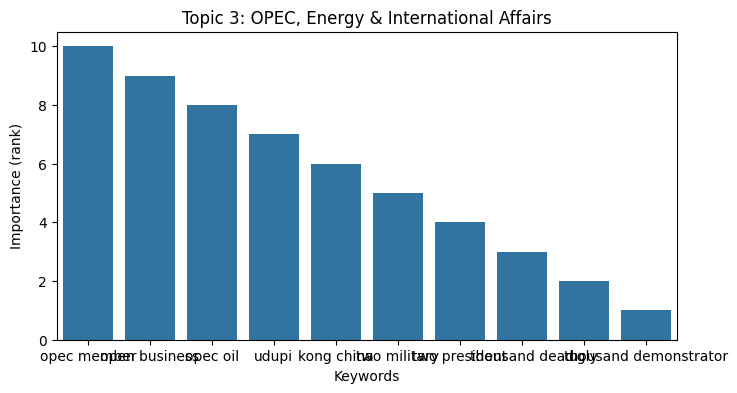

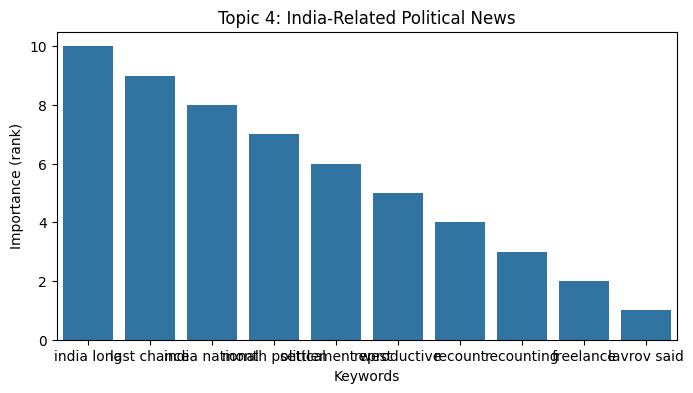

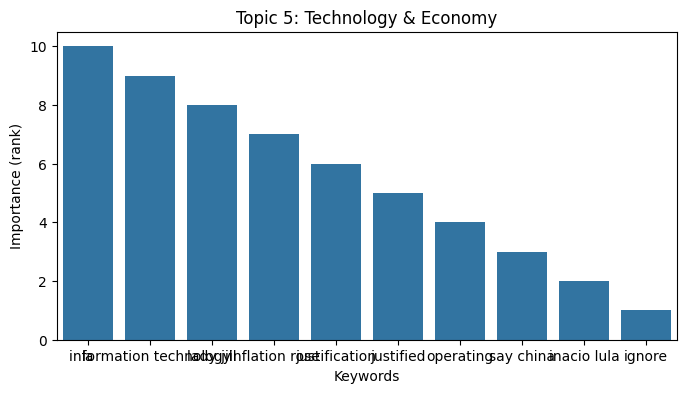

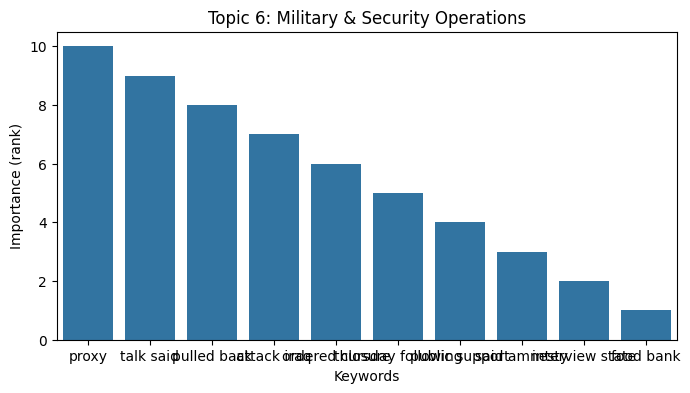

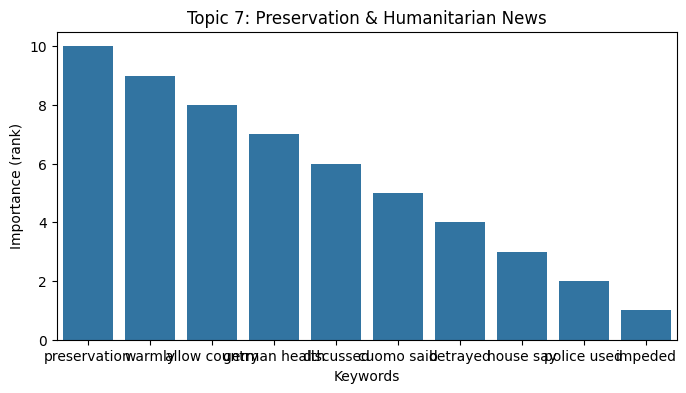

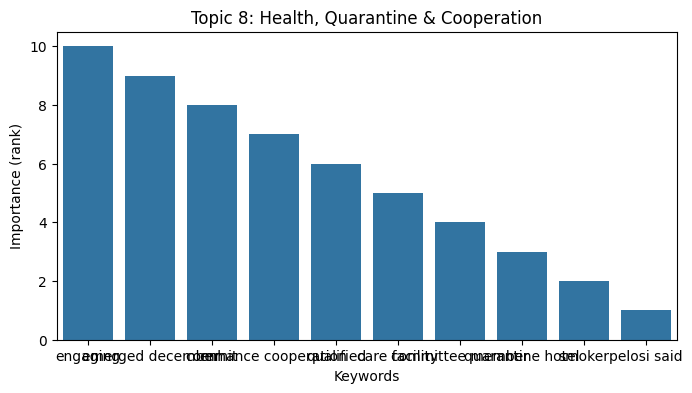

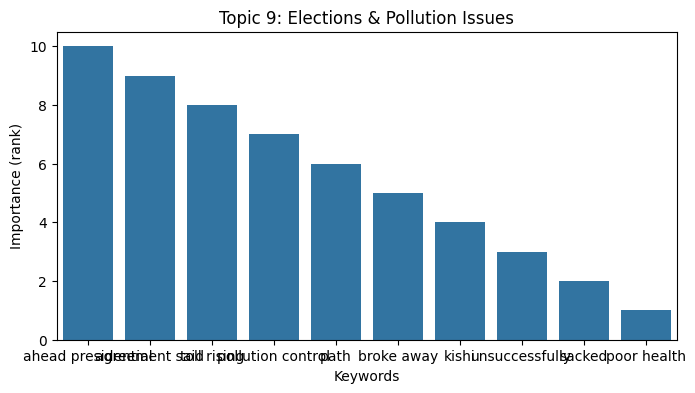

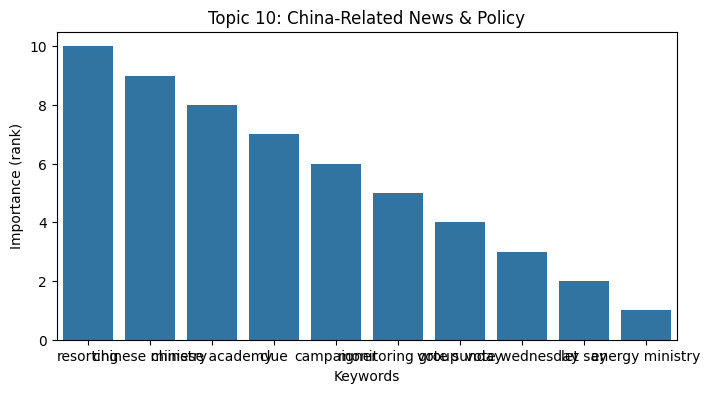

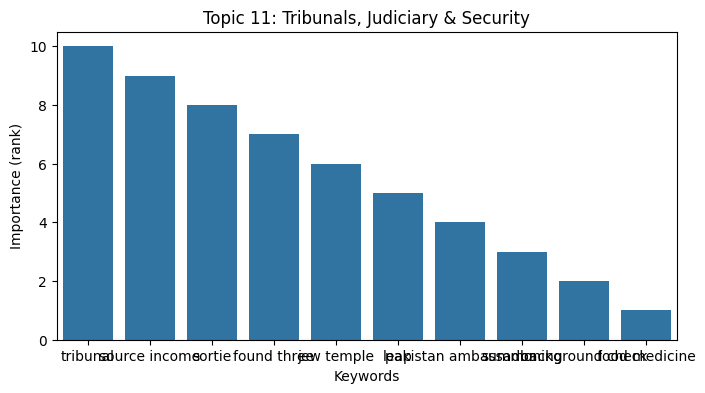

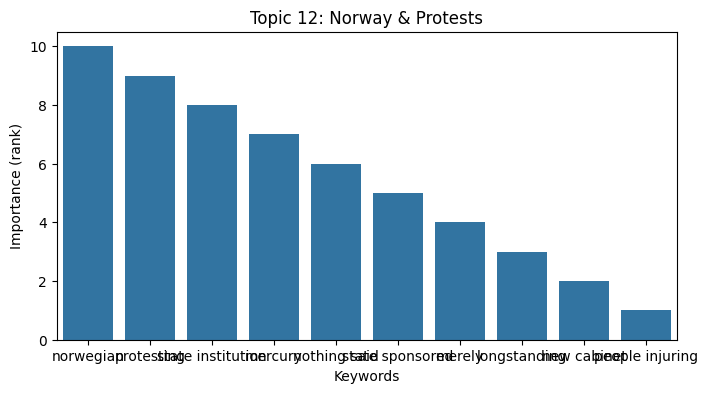

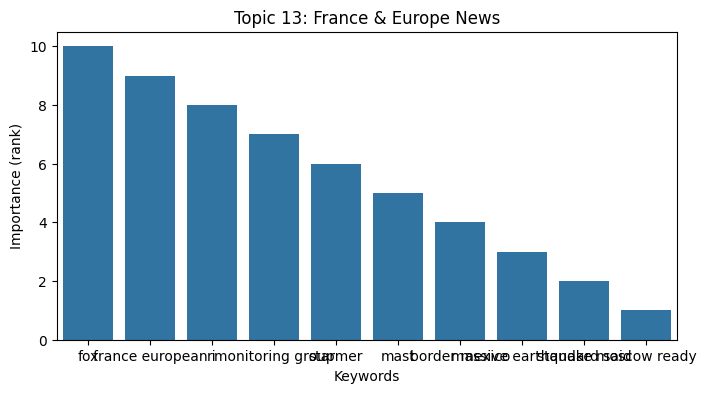

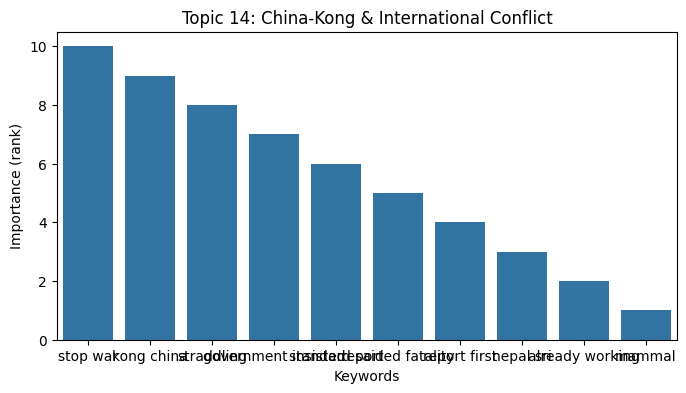

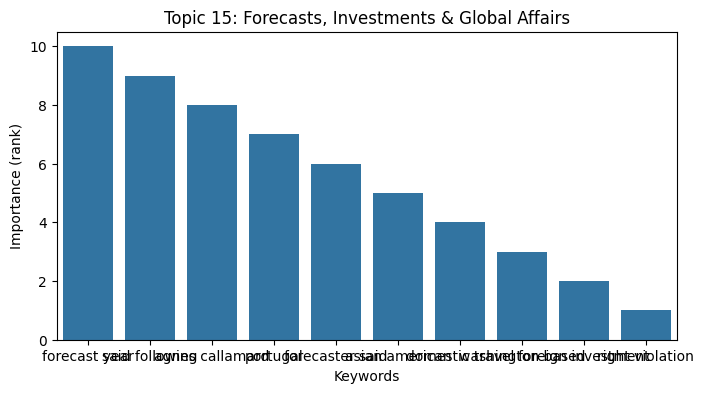

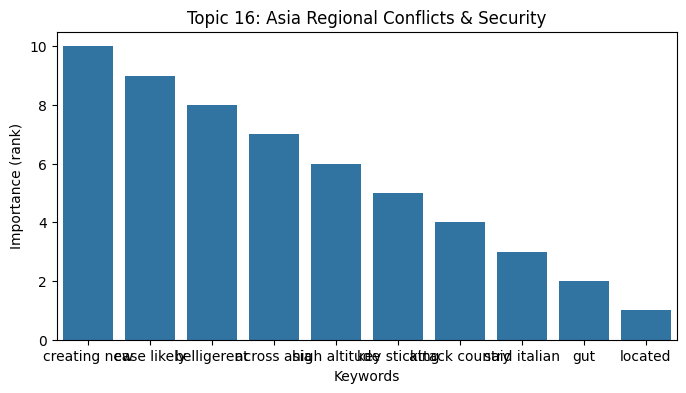

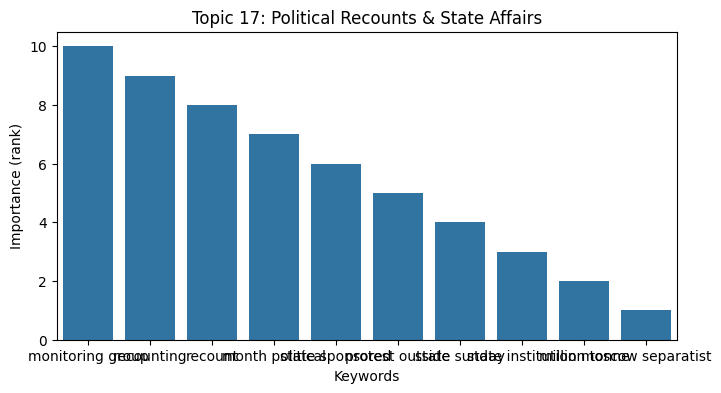

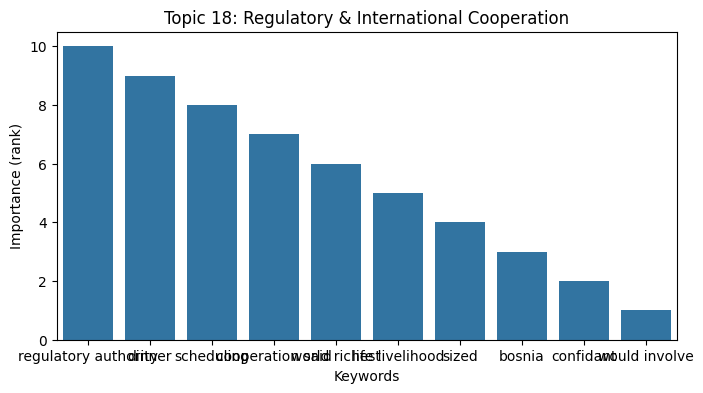

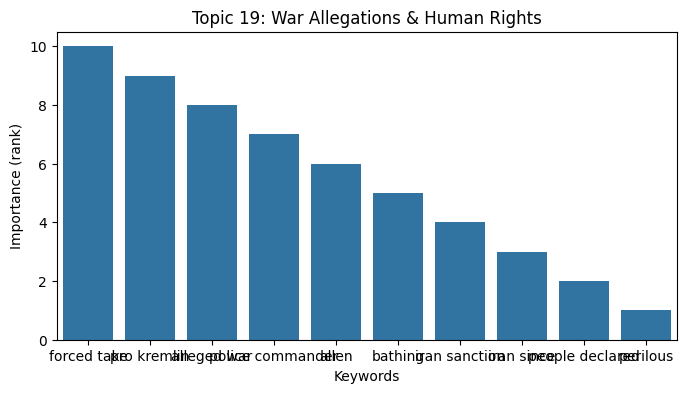

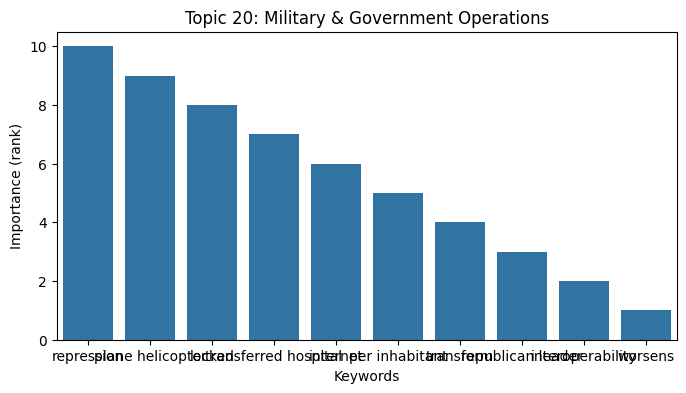

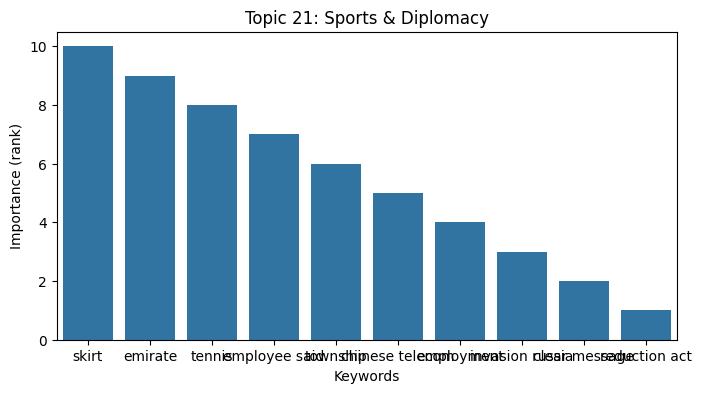

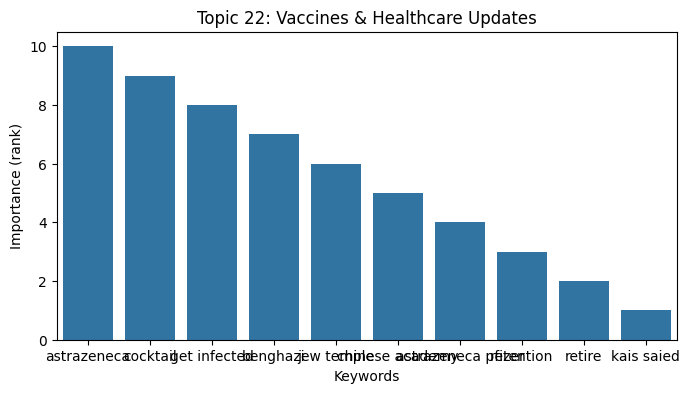

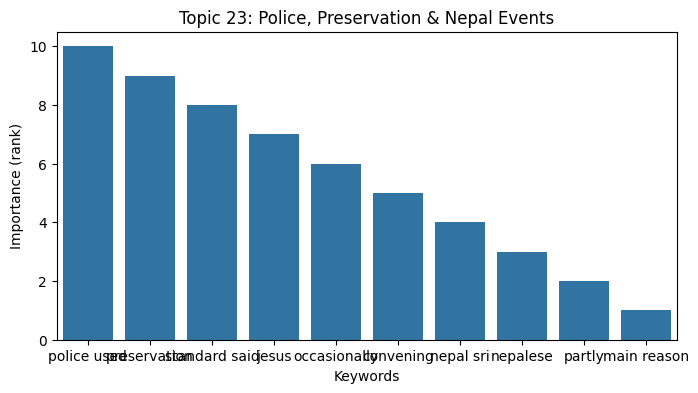

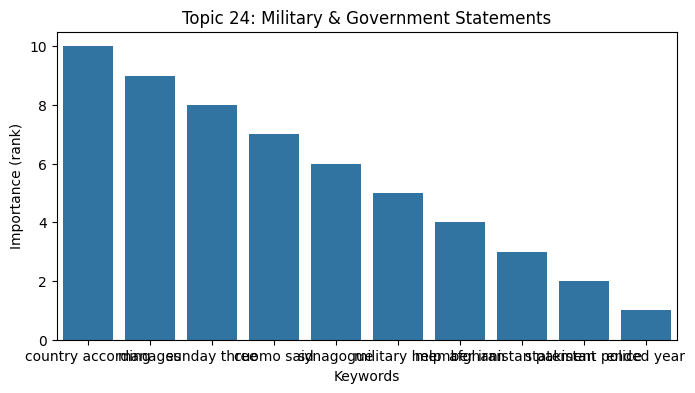

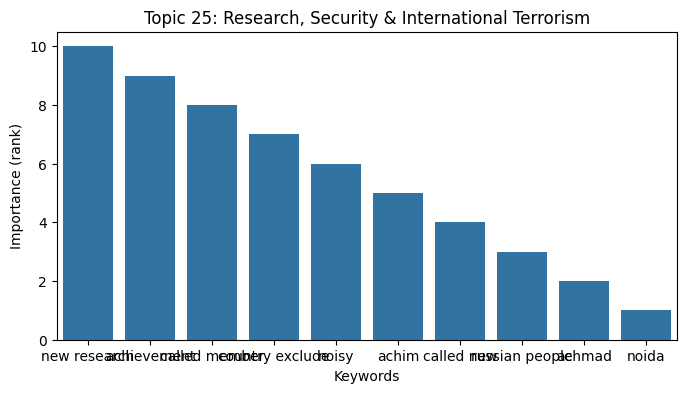

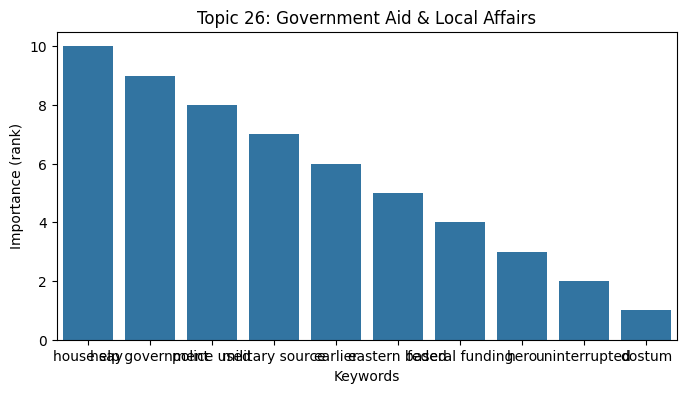

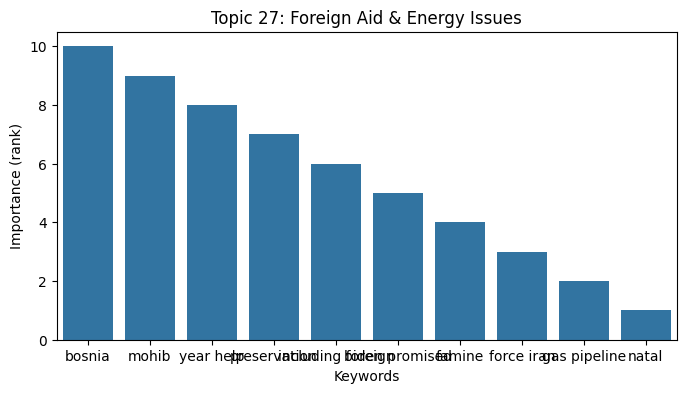

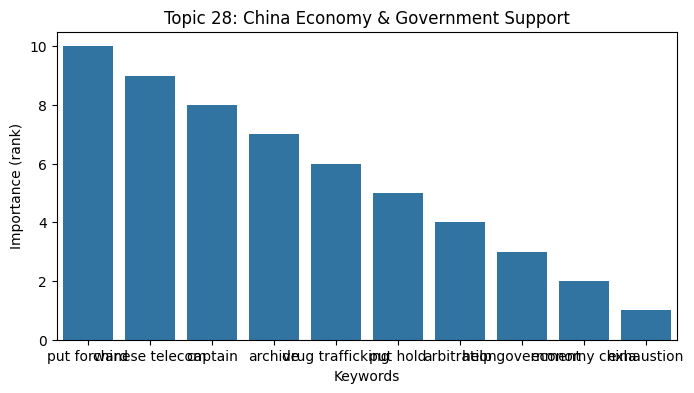

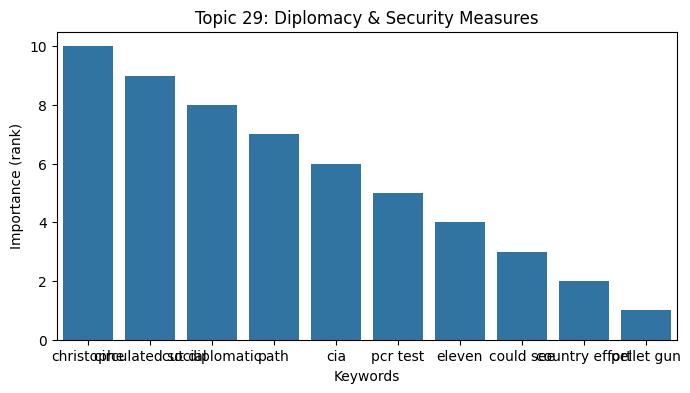

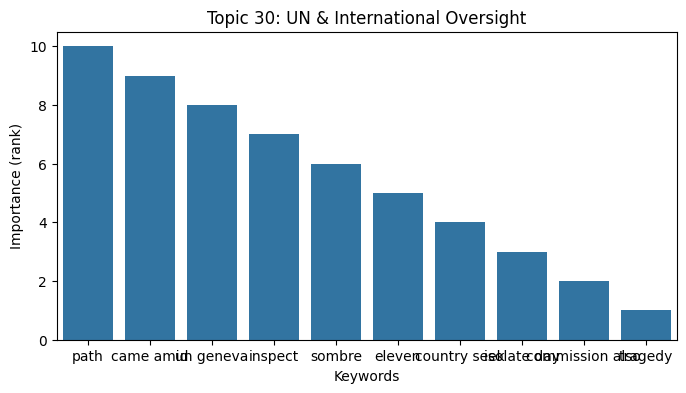

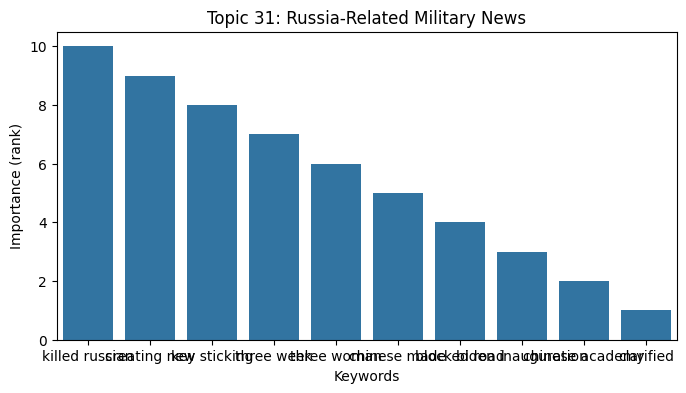

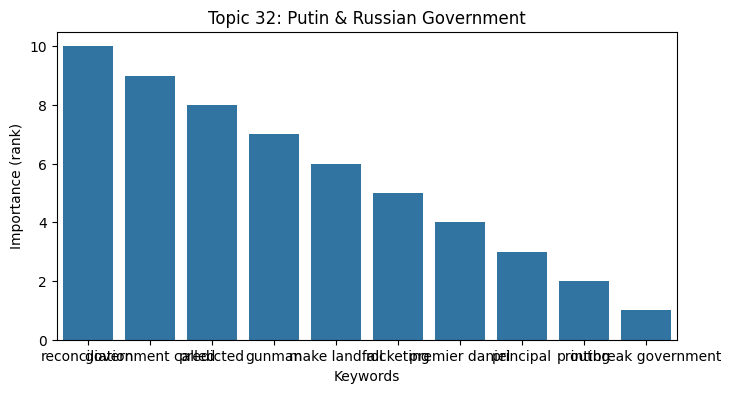

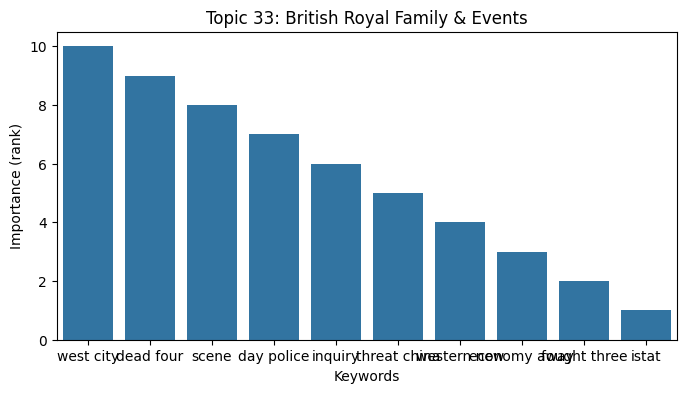

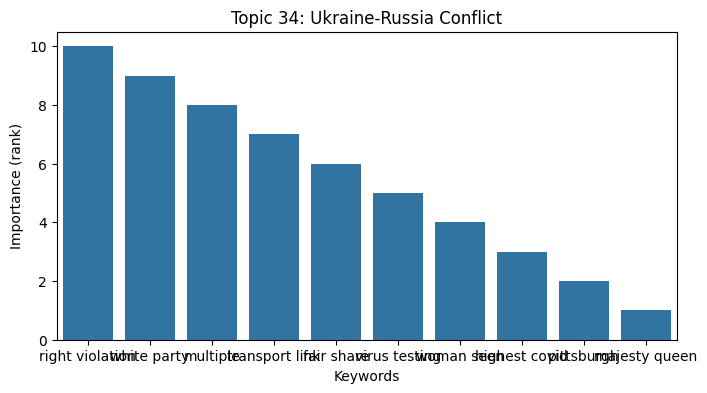

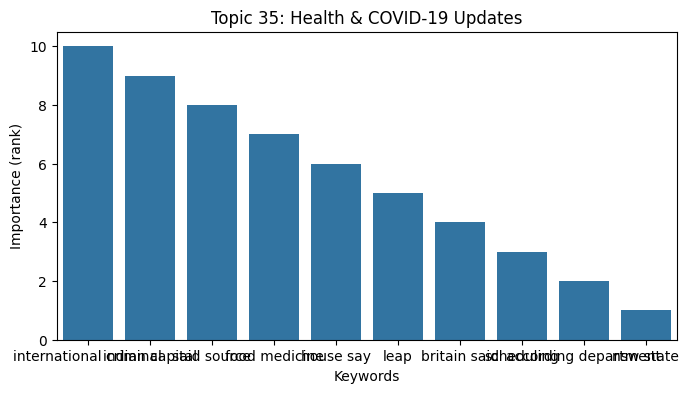

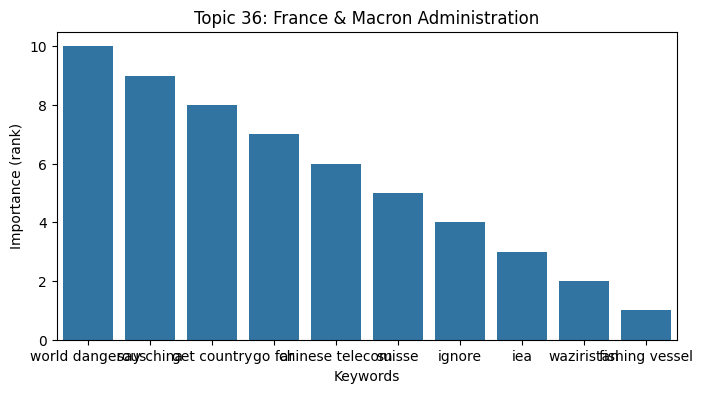

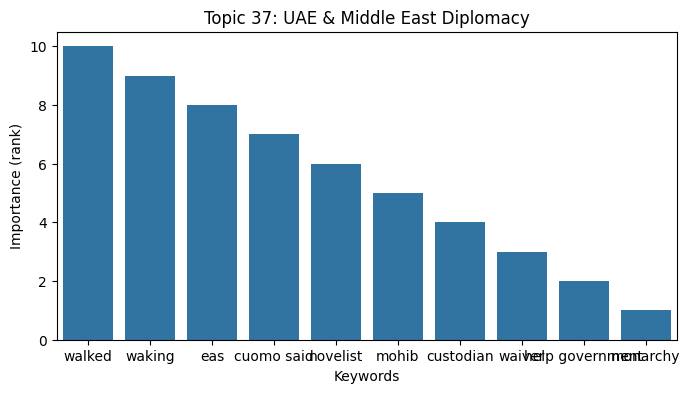

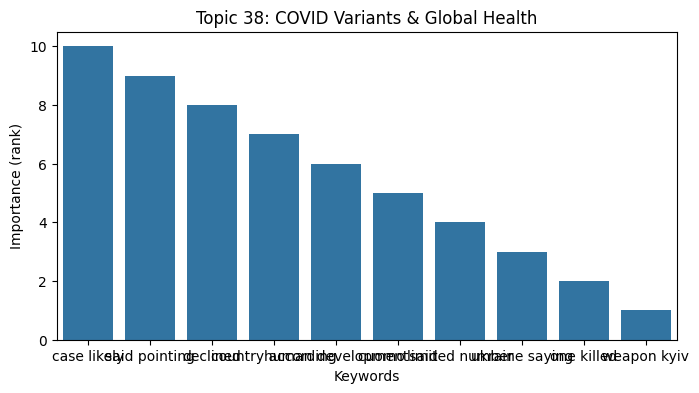

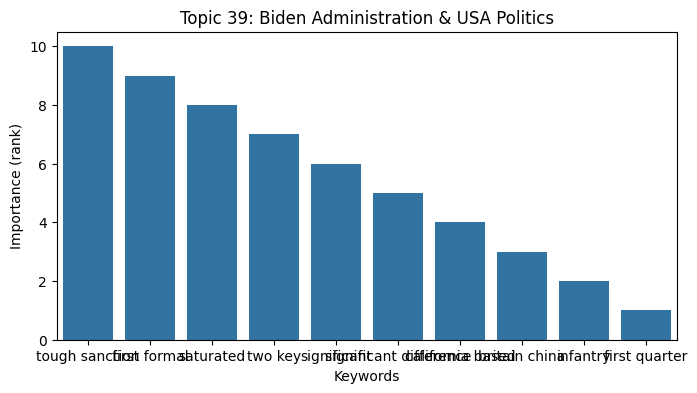

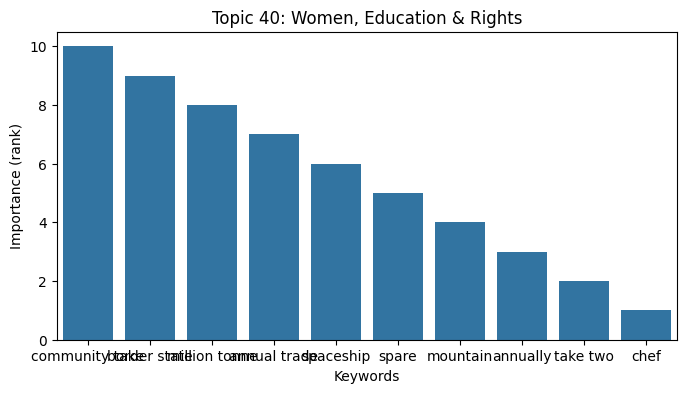

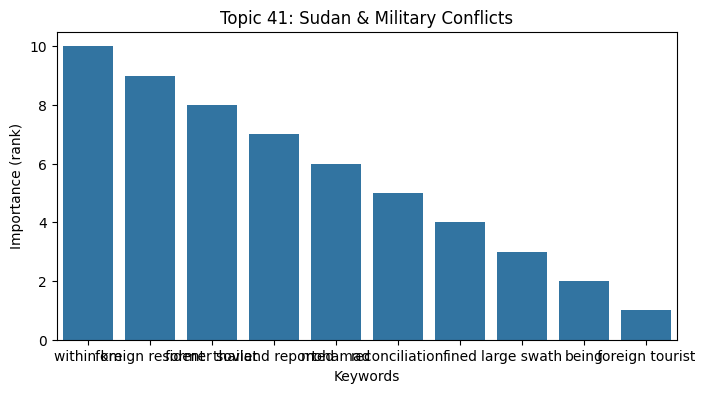

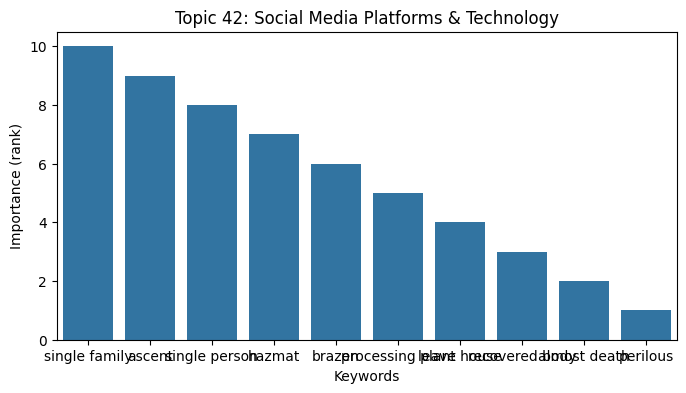

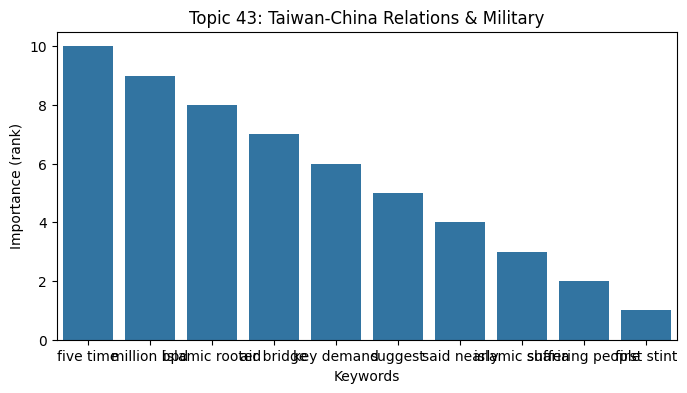

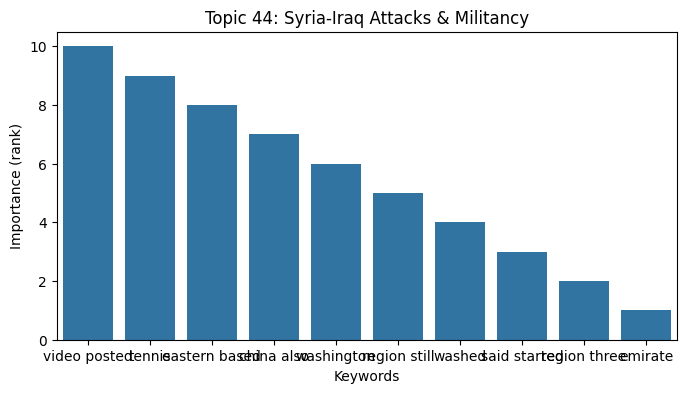

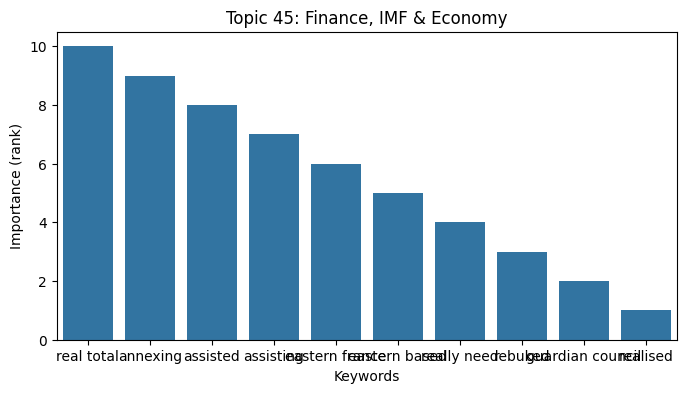

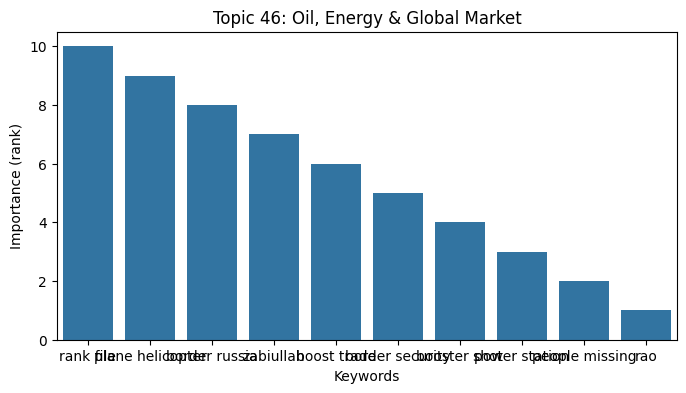

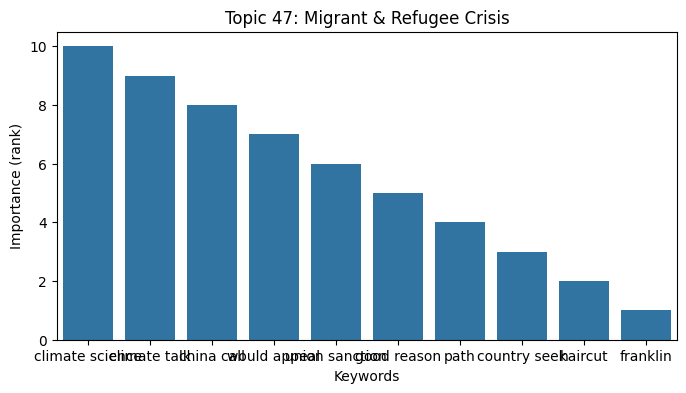

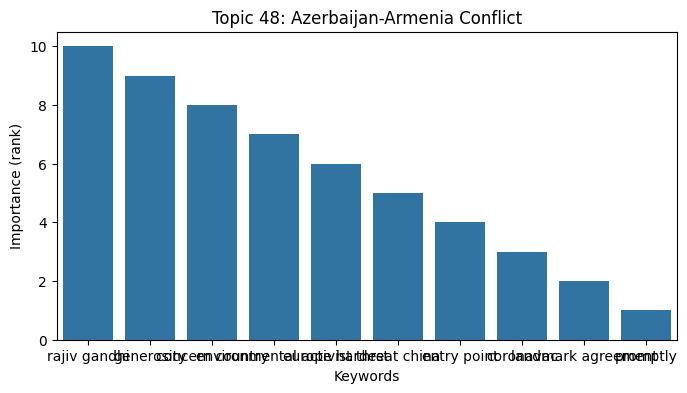

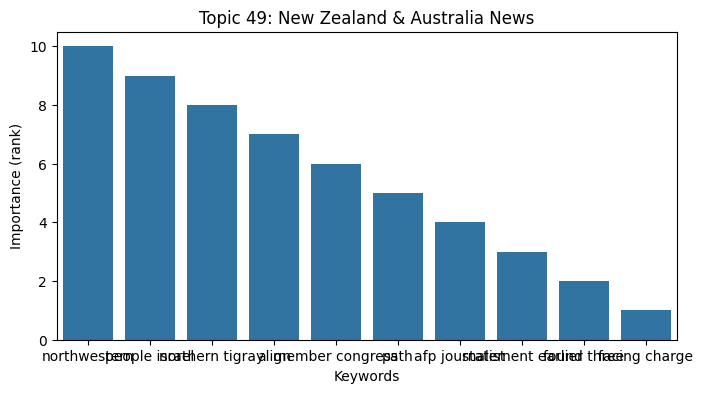

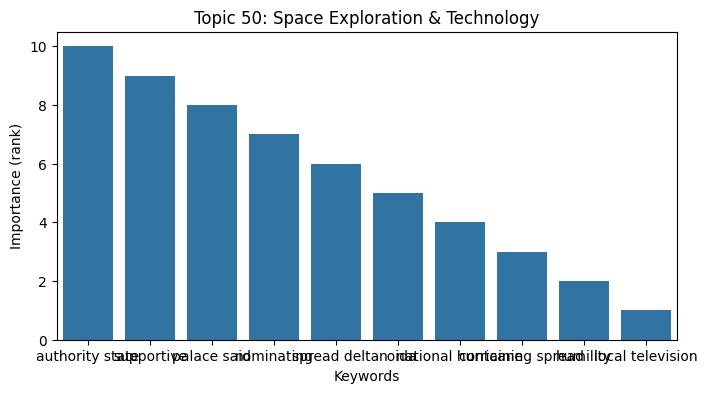

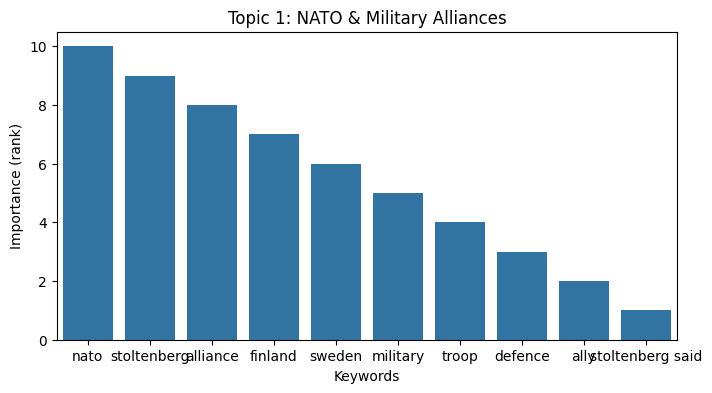

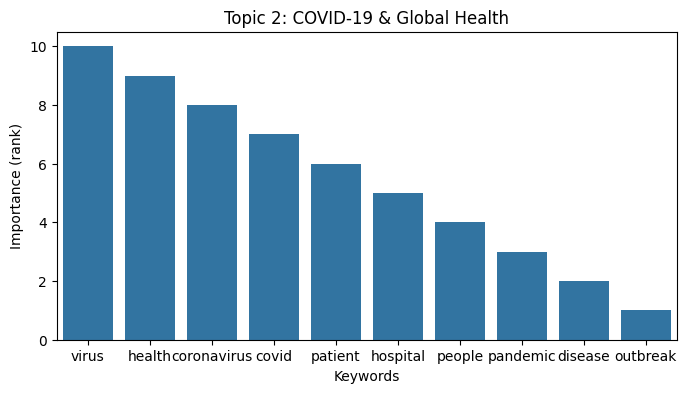

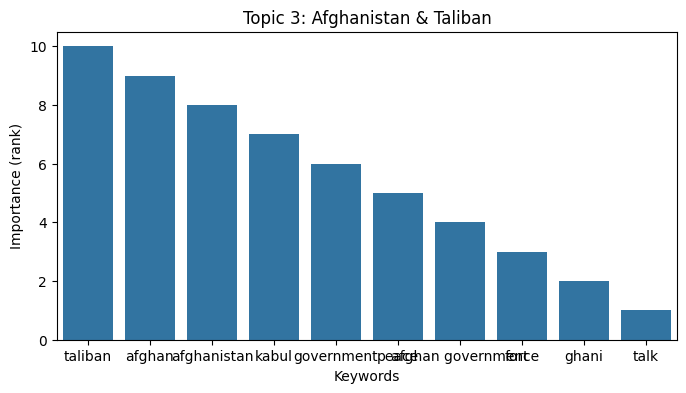

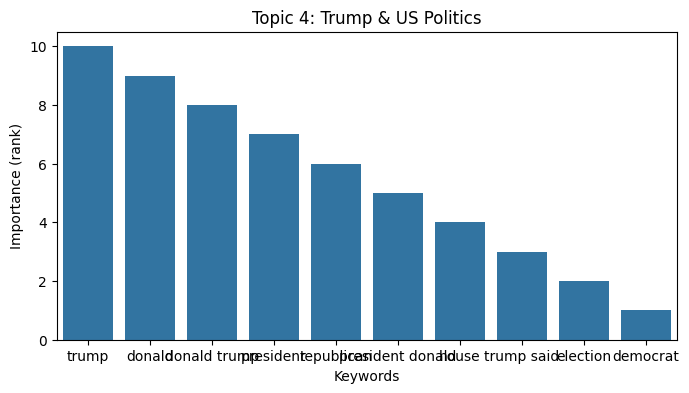

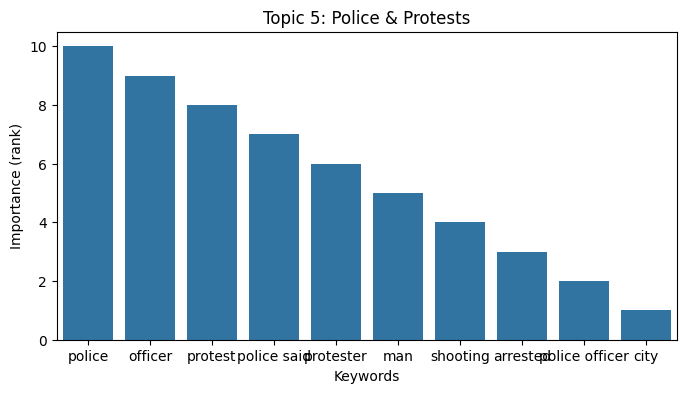

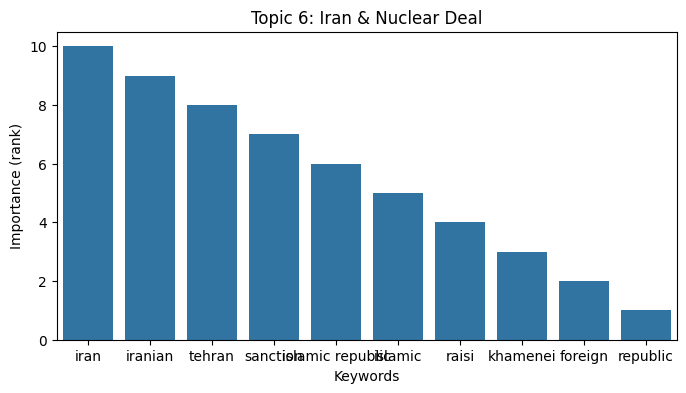

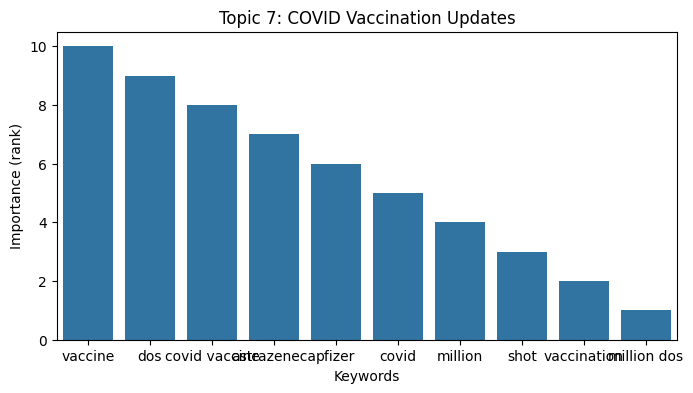

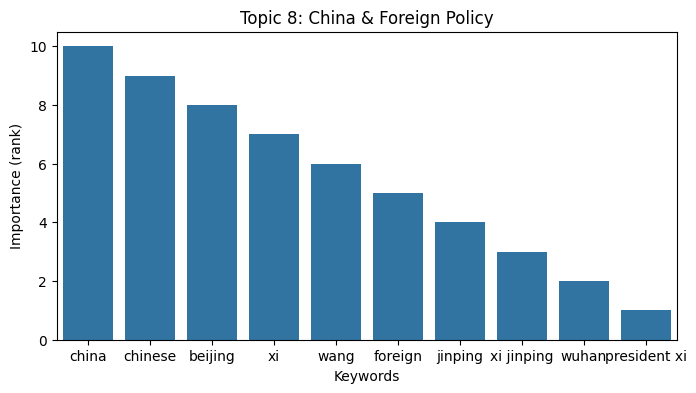

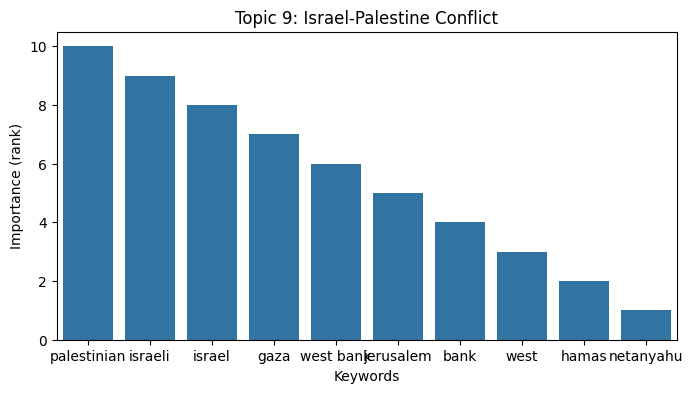

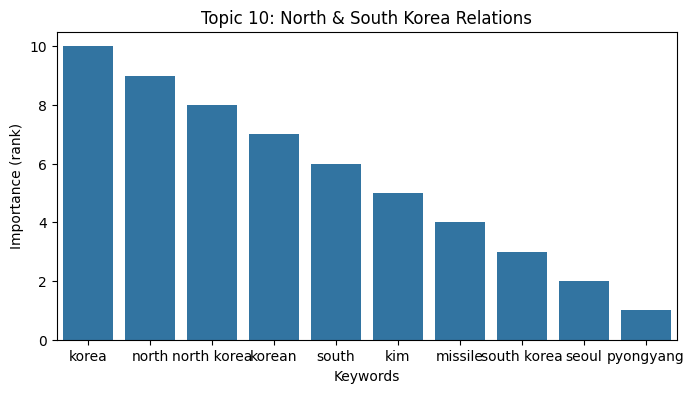

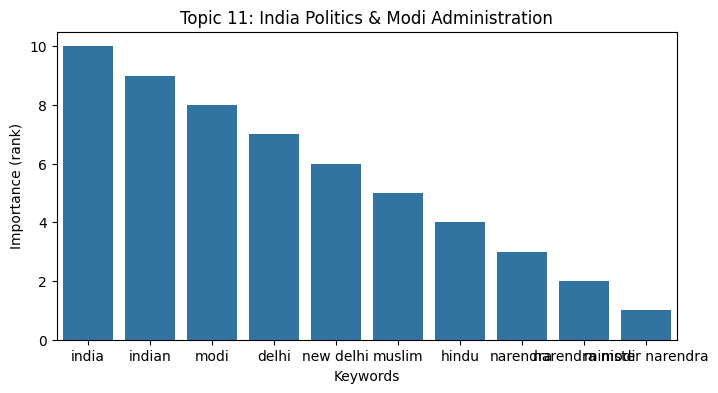

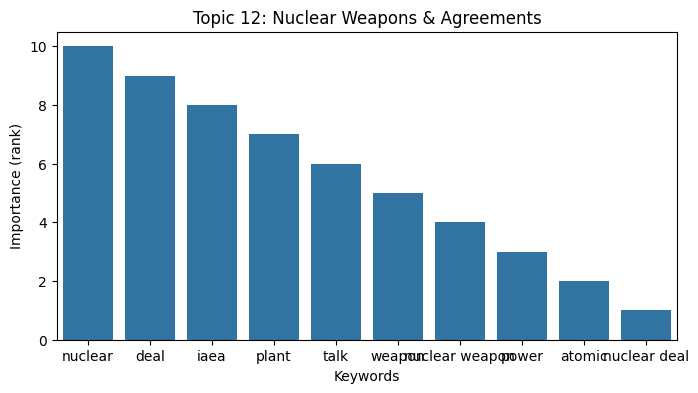

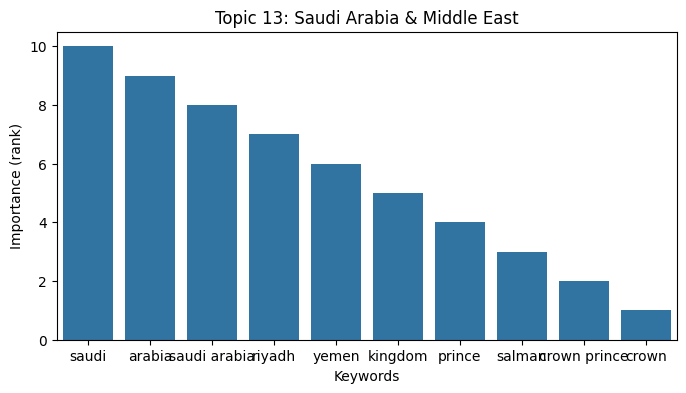

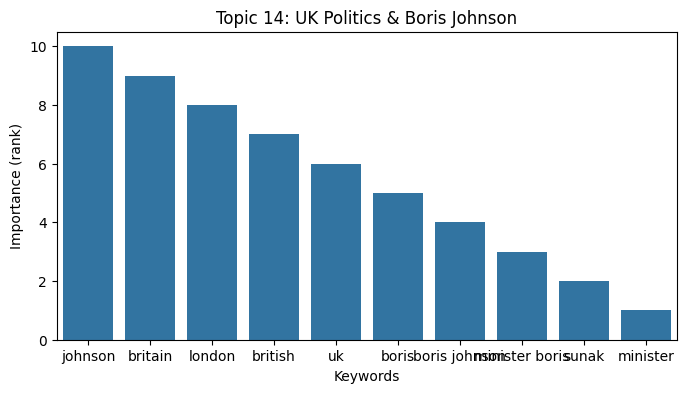

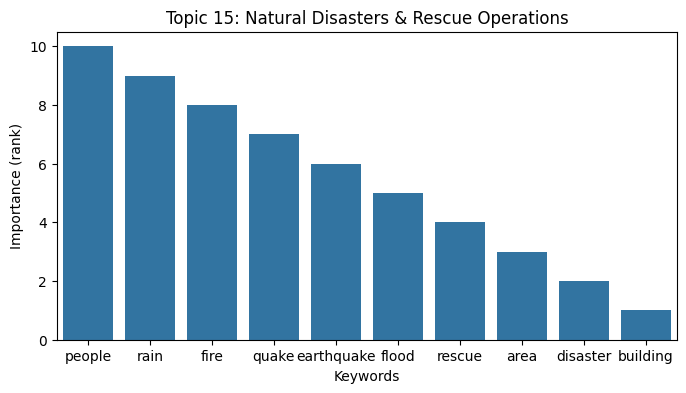

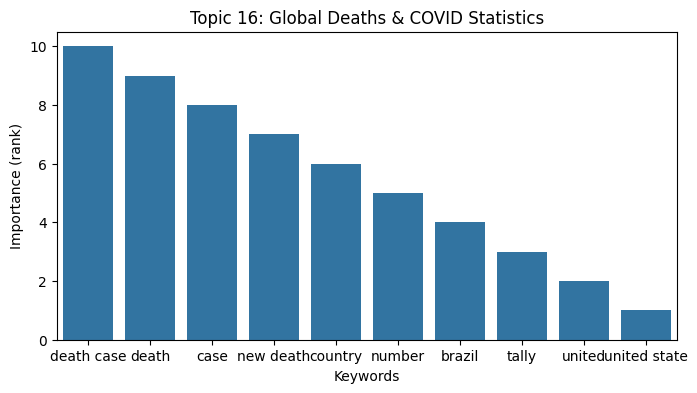

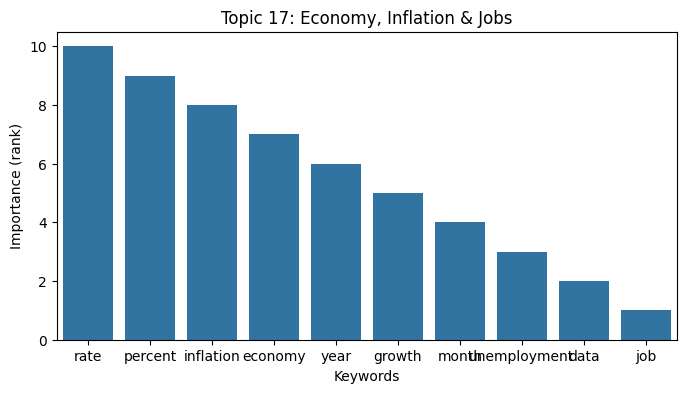

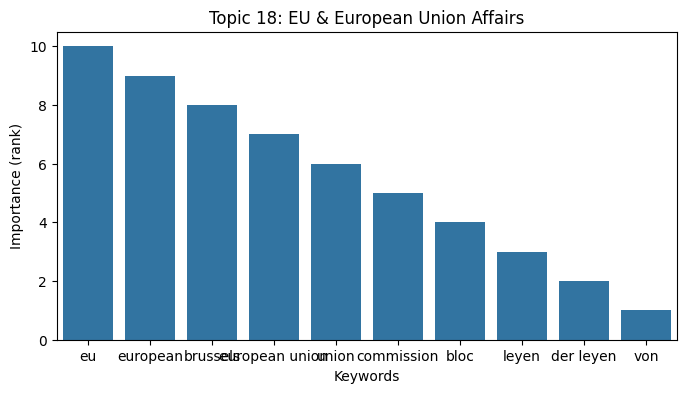

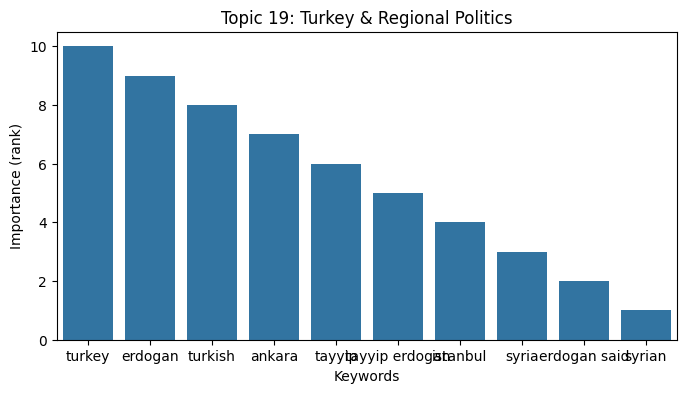

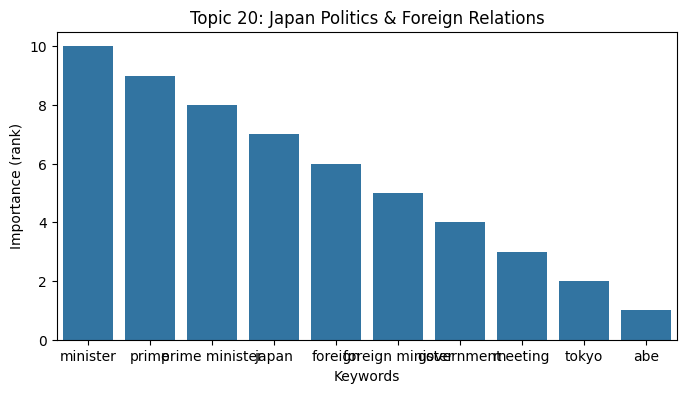

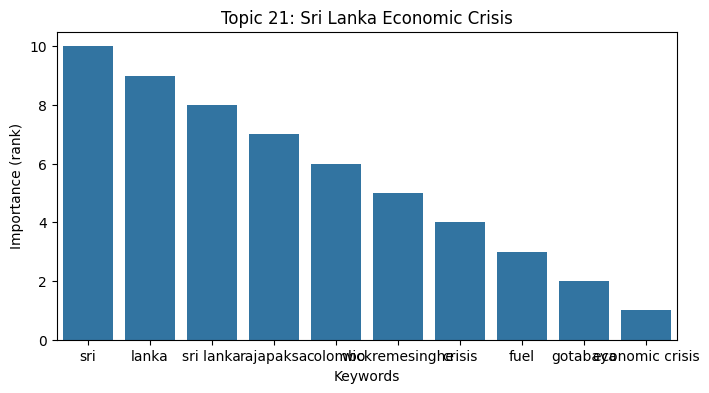

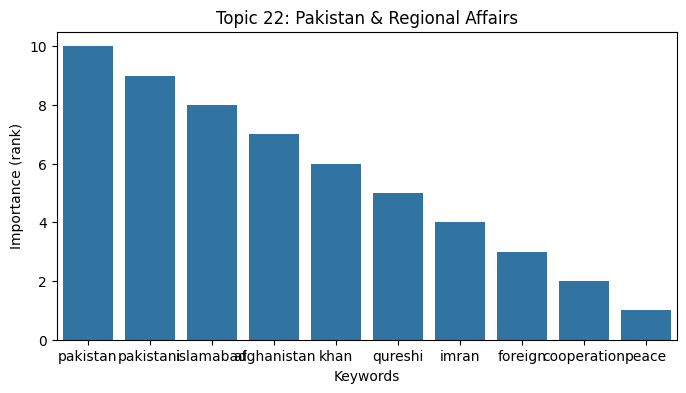

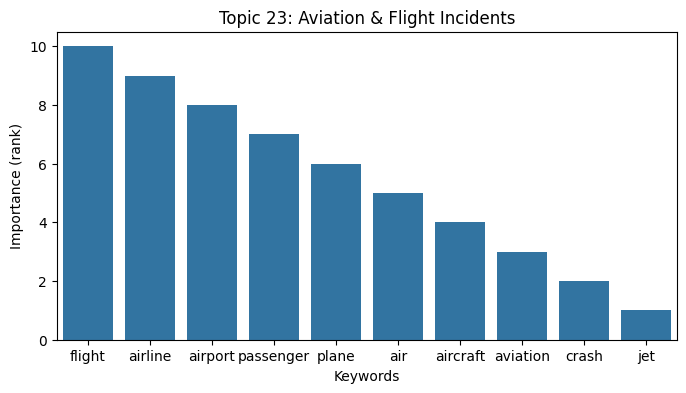

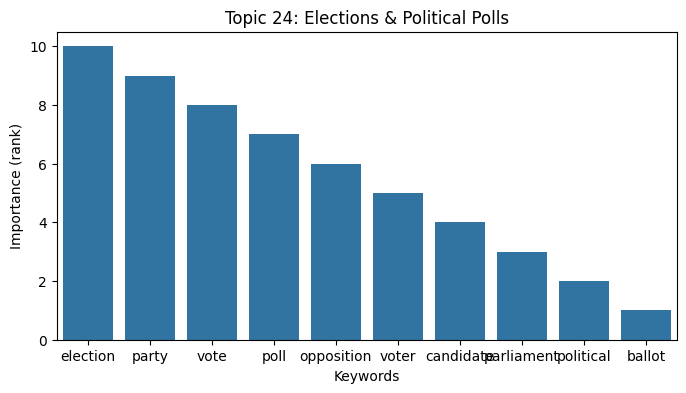

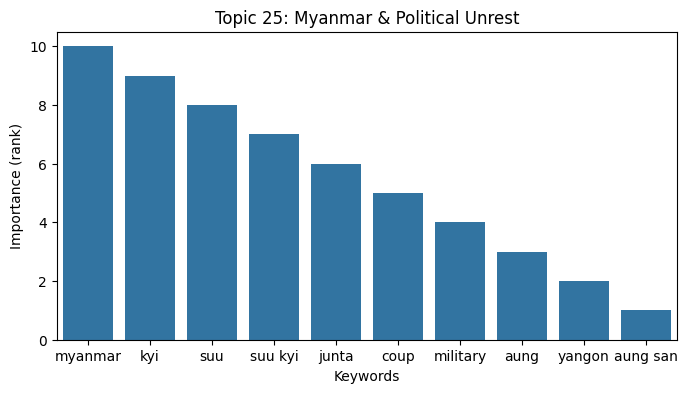

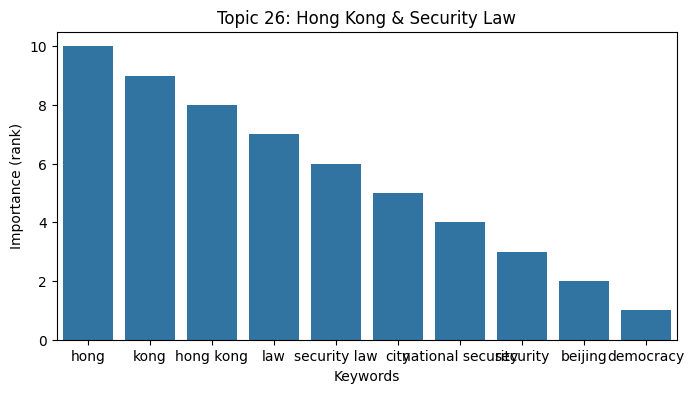

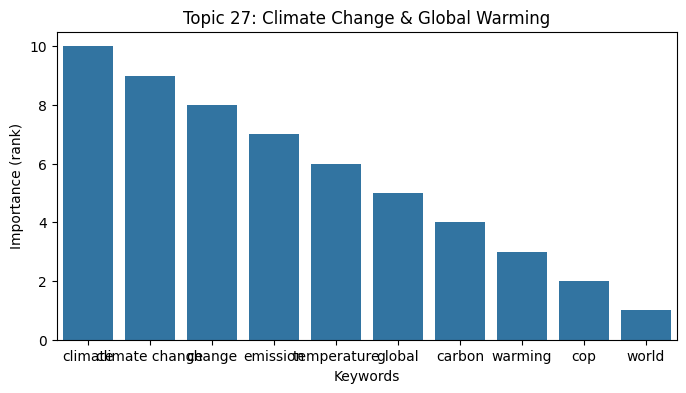

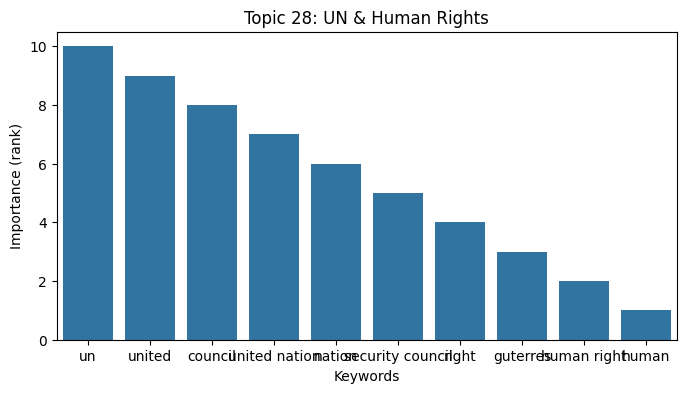

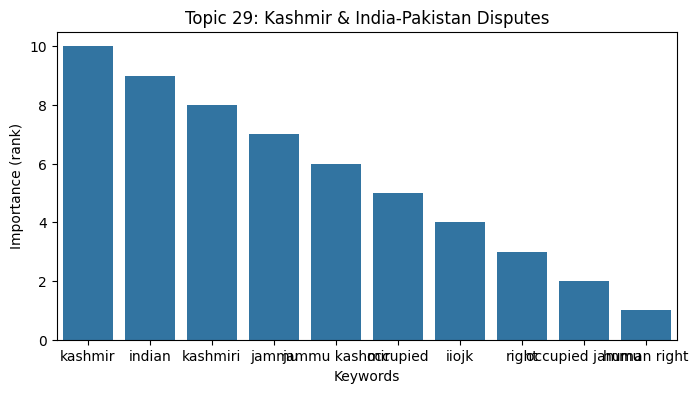

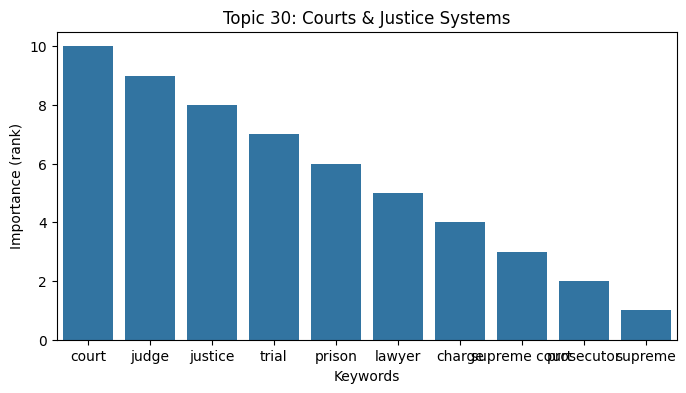

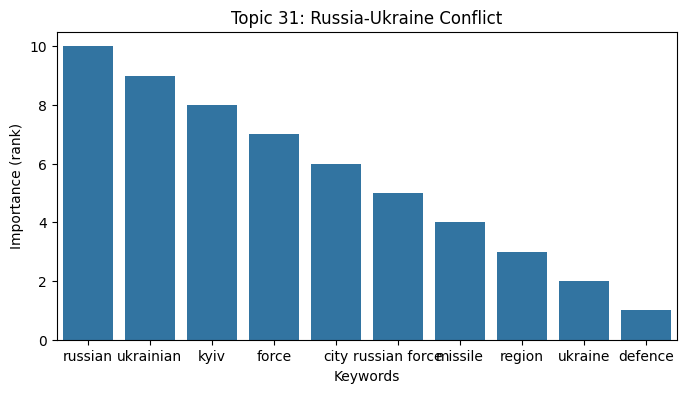

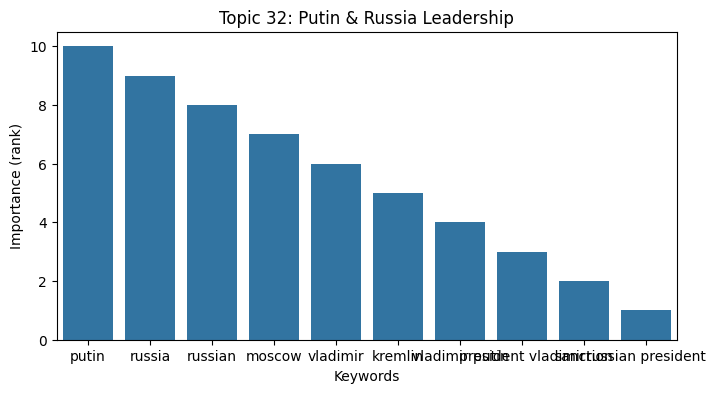

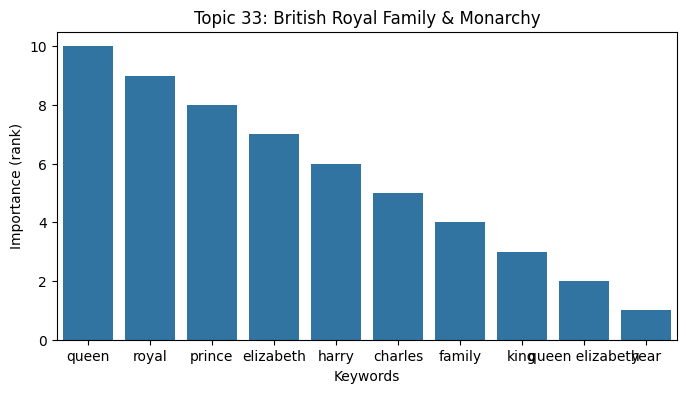

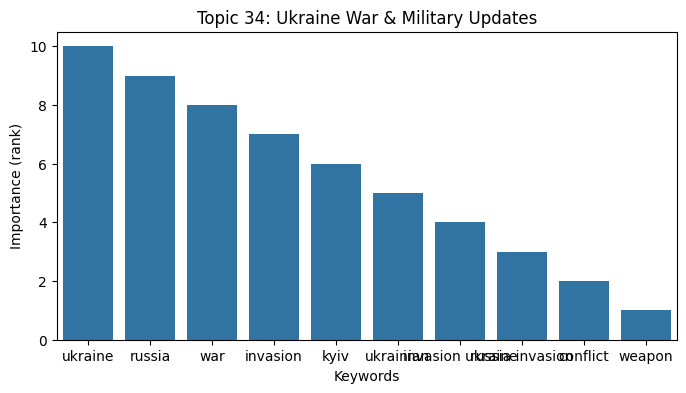

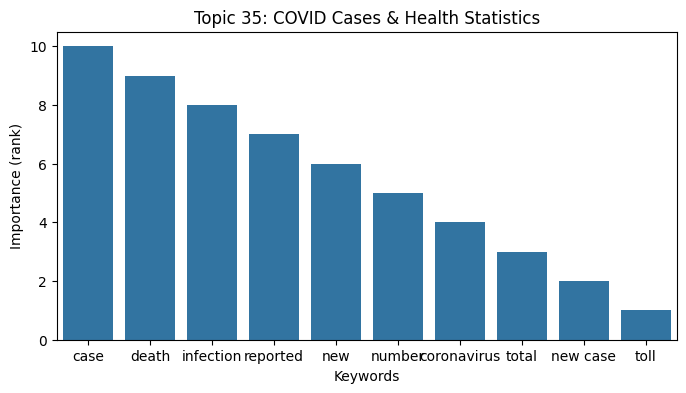

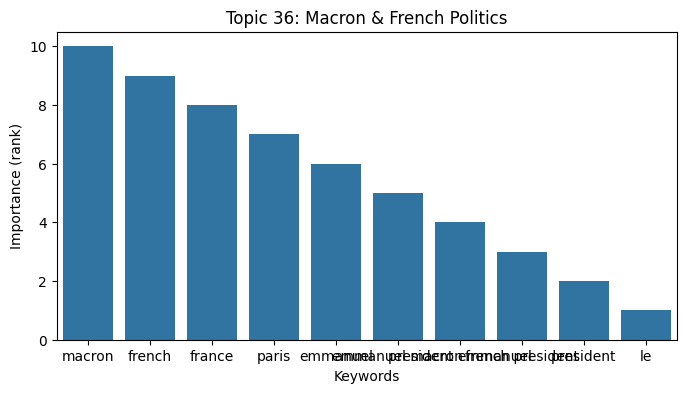

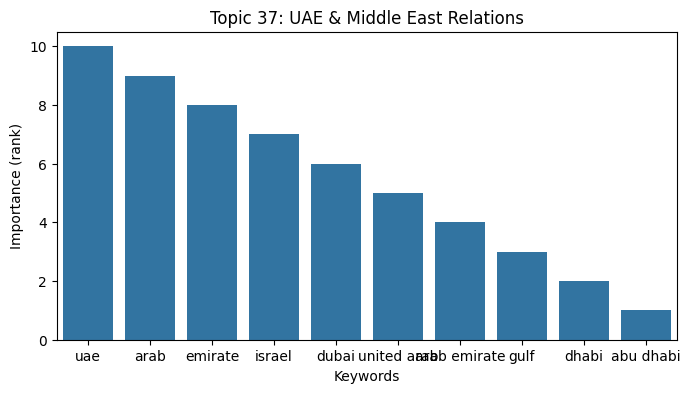

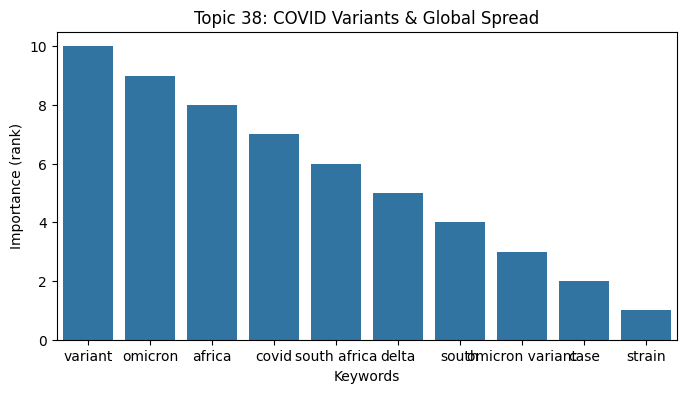

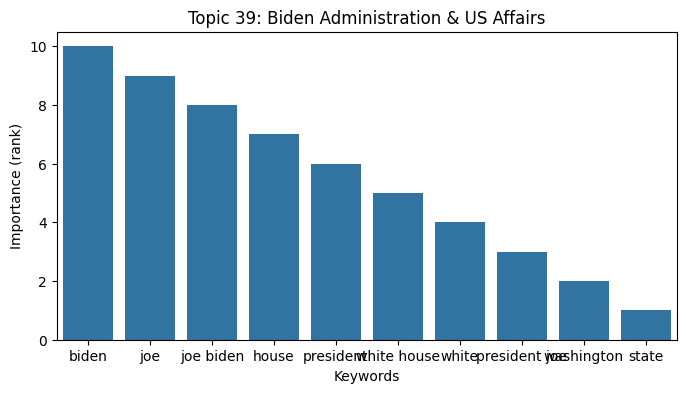

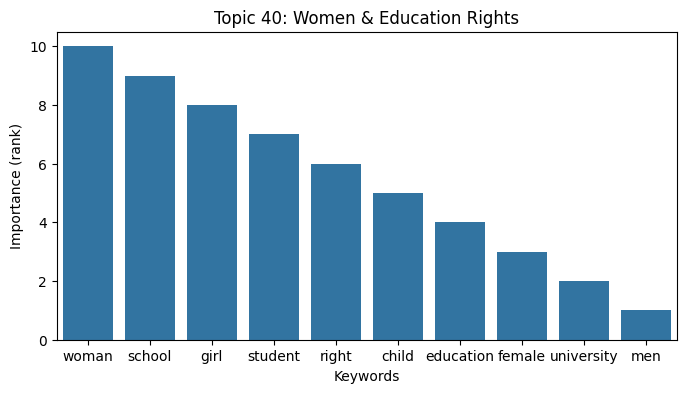

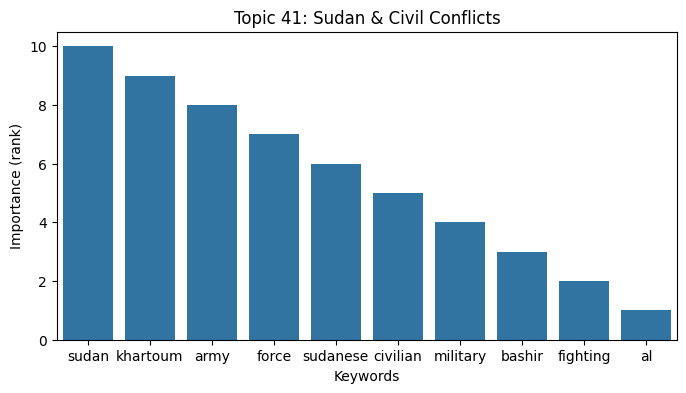

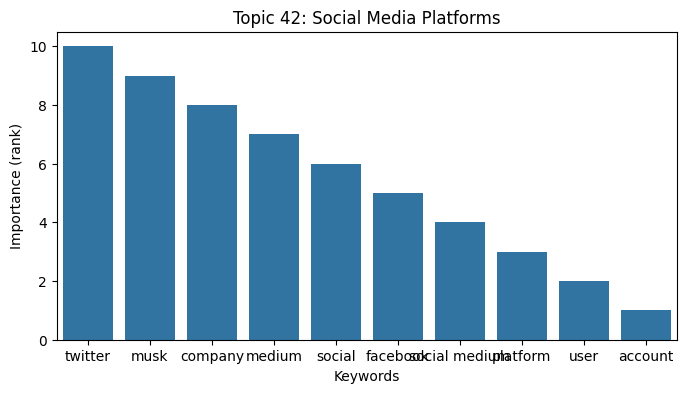

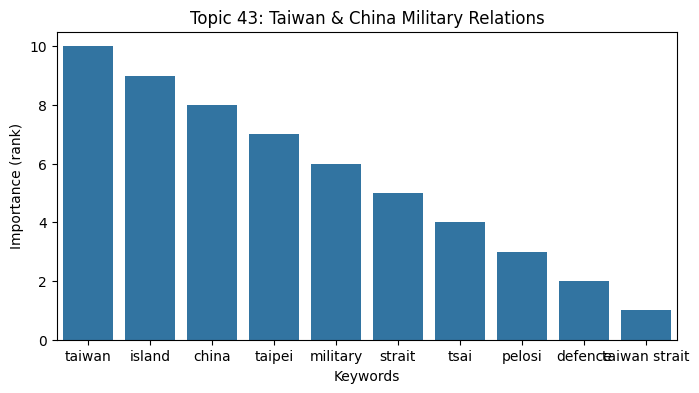

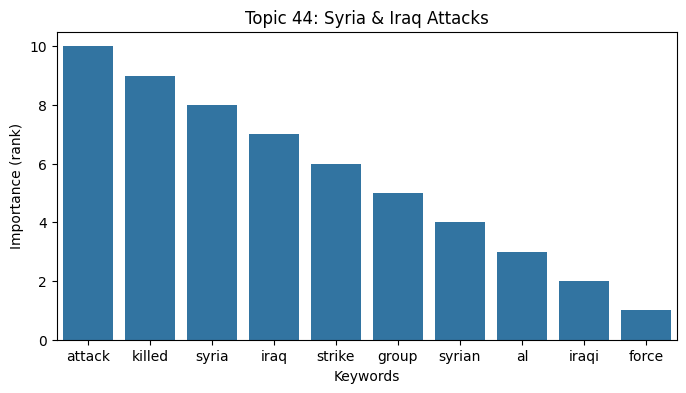

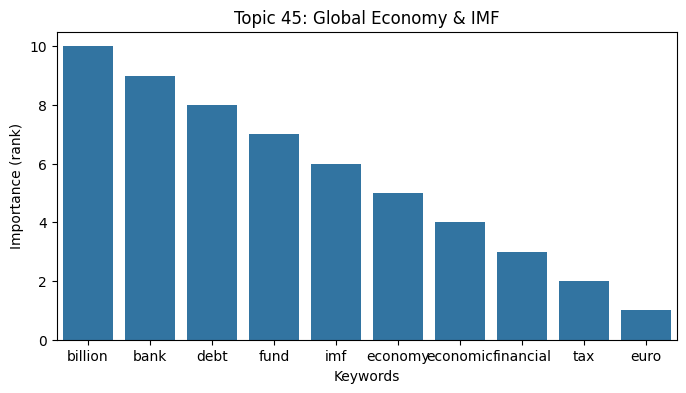

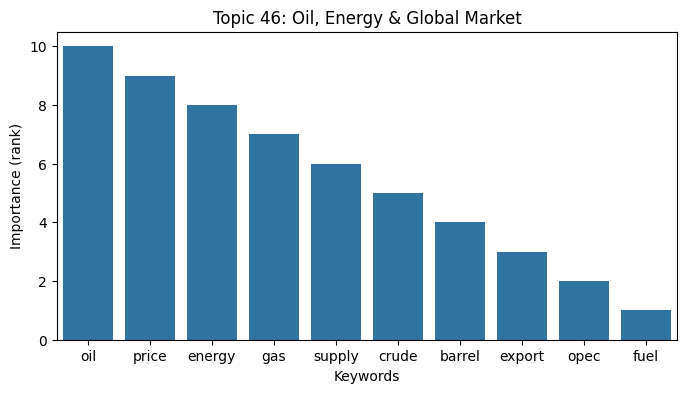

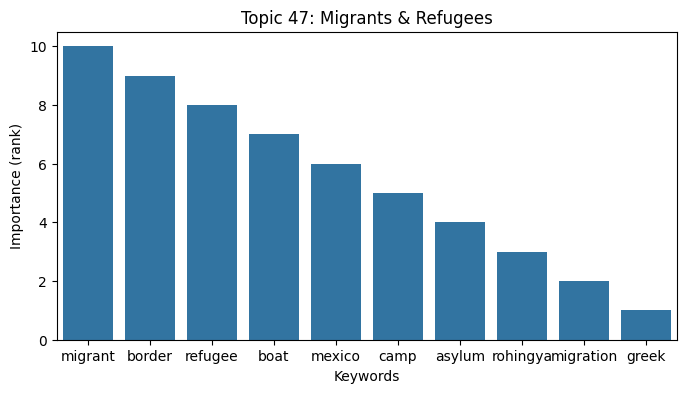

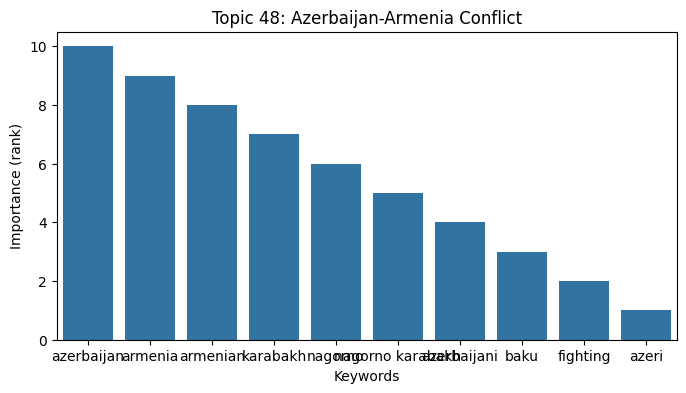

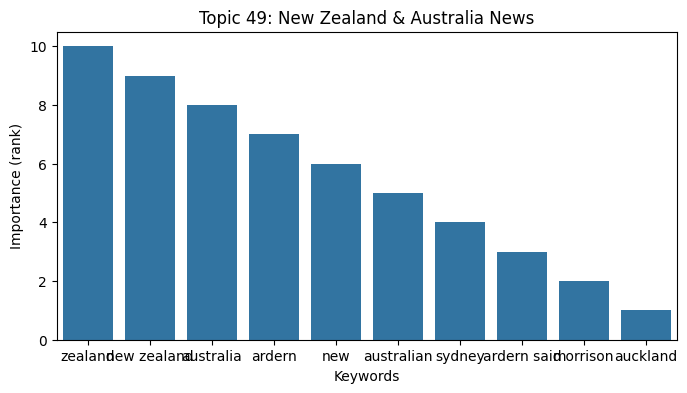

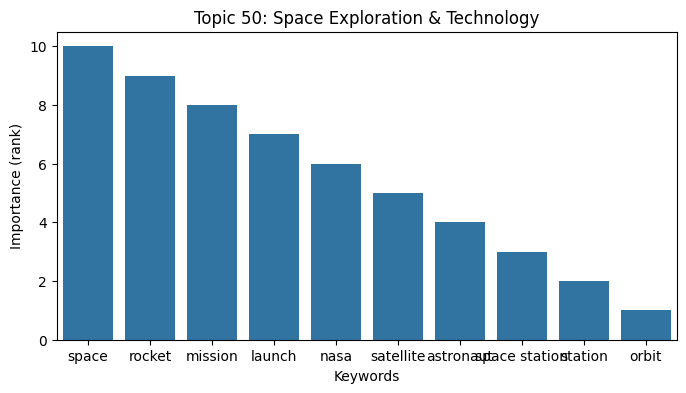

In [ ]:
def plot_top_keywords(topic_keywords, topic_labels):
    import seaborn as sns
    for topic_id, keywords in topic_keywords.items():
        plt.figure(figsize=(8,4))
        sns.barplot(x=keywords, y=np.arange(len(keywords),0,-1))
        plt.title(f"Topic {topic_id}: {topic_labels[topic_id]}")
        plt.xlabel("Keywords")
        plt.ylabel("Importance (rank)")
        plt.show()

# National
plot_top_keywords(national_top_keywords, national_topic_labels)

# World
plot_top_keywords(world_top_keywords, world_topic_labels)


**Topic Distribution**

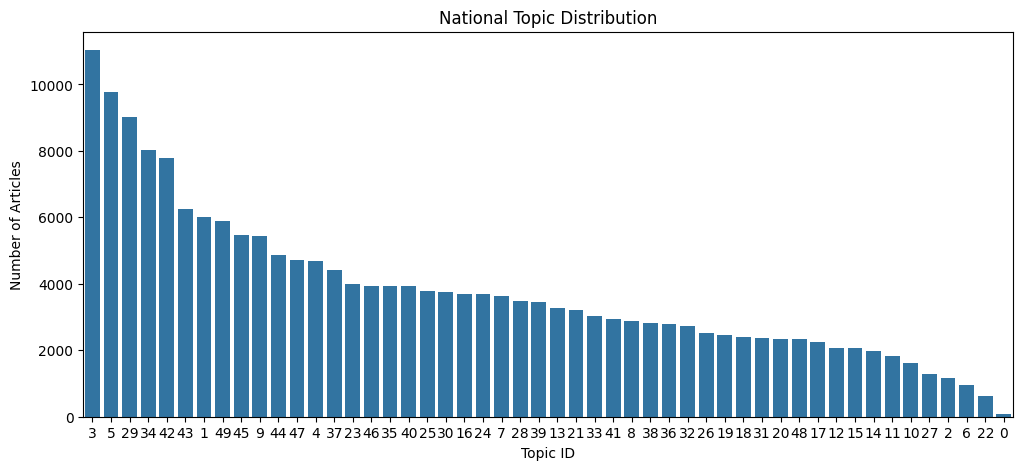

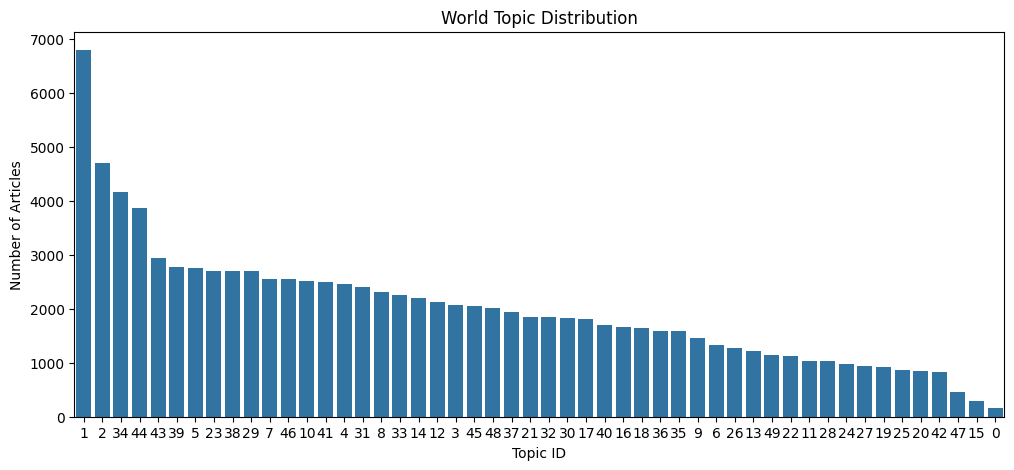

In [ ]:
def plot_topic_distribution(df, title="Topic Distribution"):
    plt.figure(figsize=(12,5))
    sns.countplot(x='dominant_topic', data=df, order=df['dominant_topic'].value_counts().index)
    plt.title(title)
    plt.xlabel("Topic ID")
    plt.ylabel("Number of Articles")
    plt.show()

plot_topic_distribution(df_national_topics, "National Topic Distribution")
plot_topic_distribution(df_world_topics, "World Topic Distribution")


**Top Keywords Heatmap**

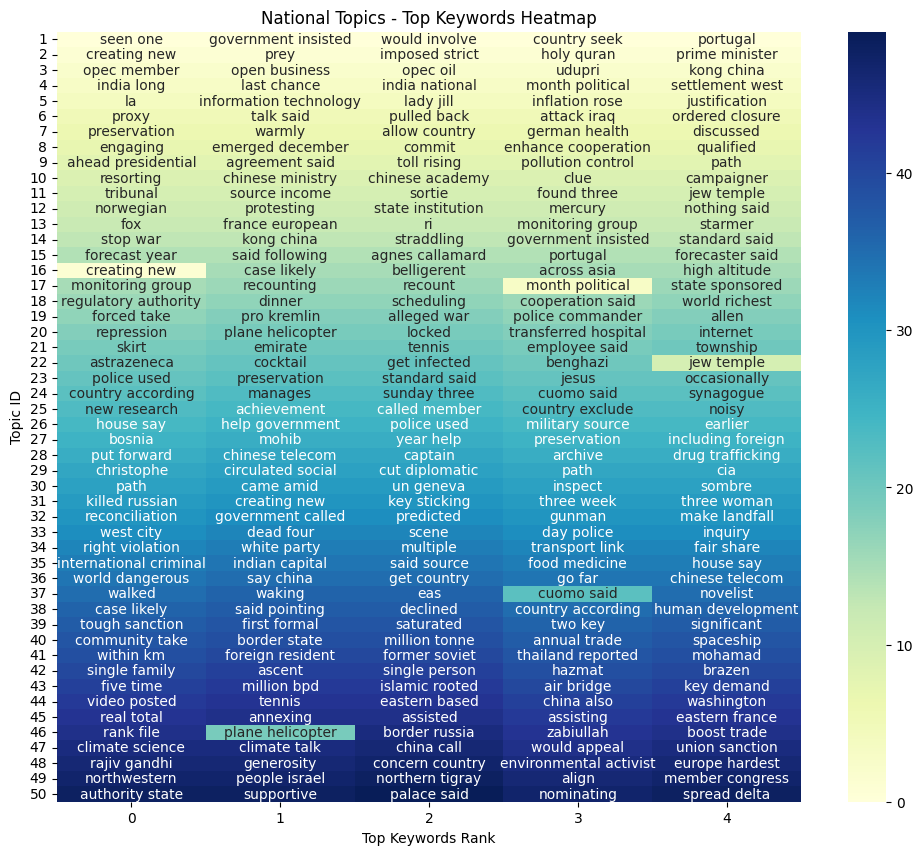

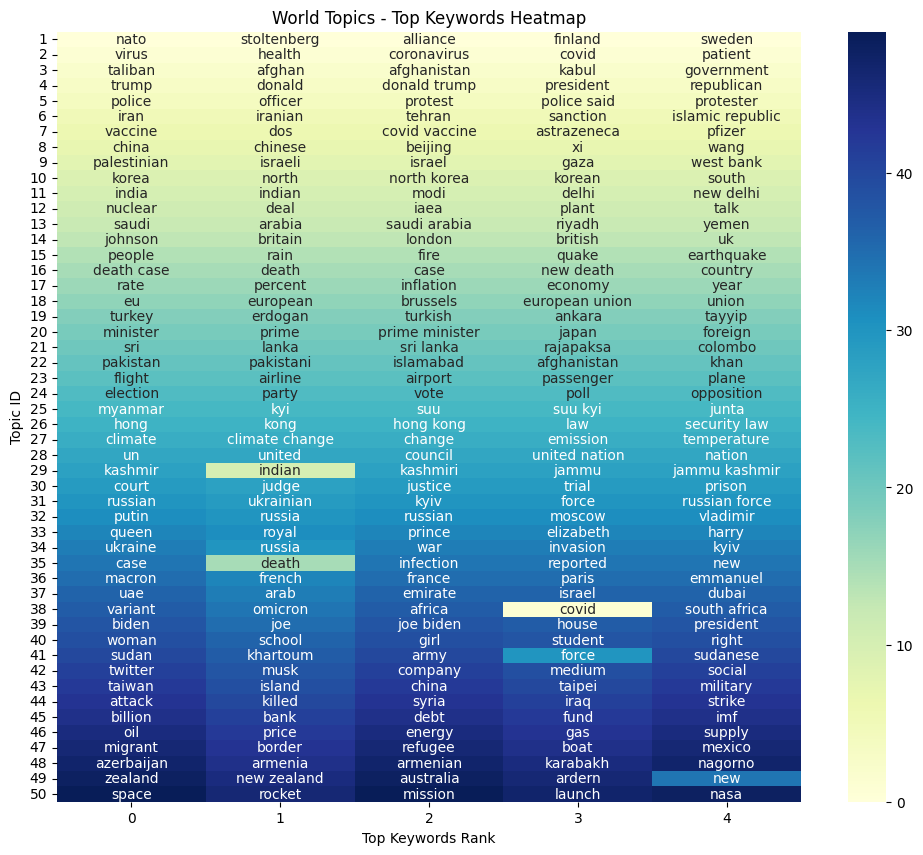

In [ ]:
def plot_keywords_heatmap(topic_keywords, title="Top Keywords Heatmap"):
    df = pd.DataFrame(topic_keywords).T
    df.fillna("", inplace=True)
    plt.figure(figsize=(12,10))
    sns.heatmap(df.apply(lambda x: pd.factorize(x)[0]), annot=df, fmt="", cmap="YlGnBu")
    plt.title(title)
    plt.xlabel("Top Keywords Rank")
    plt.ylabel("Topic ID")
    plt.show()

plot_keywords_heatmap(national_topic_keywords, title="National Topics - Top Keywords Heatmap")
plot_keywords_heatmap(world_topic_keywords, title="World Topics - Top Keywords Heatmap")


**Topic Similarity PCA**

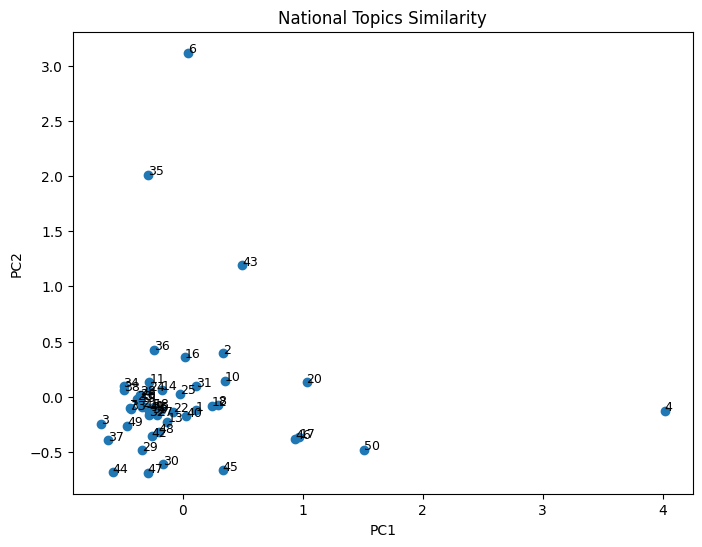

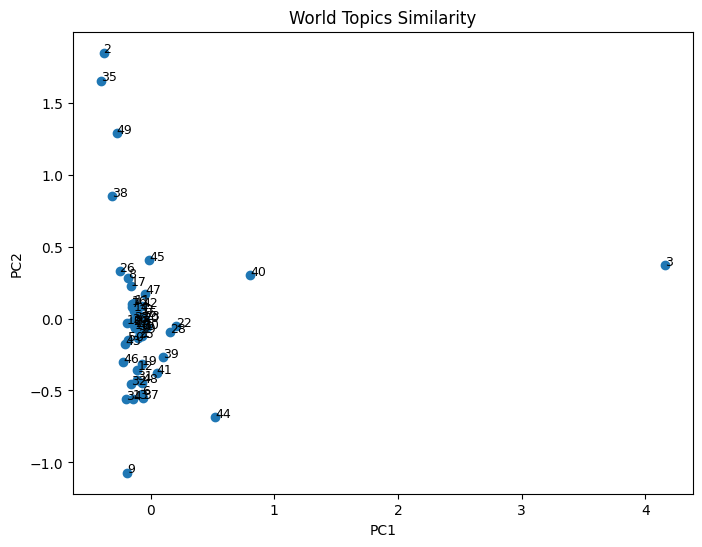

In [ ]:
def plot_topic_similarity(W, n_topics, title="Topic Similarity (PCA)"):
    pca = PCA(n_components=2)
    topic_vectors = W.T  # columns = topics
    pca_result = pca.fit_transform(topic_vectors)
    plt.figure(figsize=(8,6))
    plt.scatter(pca_result[:,0], pca_result[:,1])
    for i in range(n_topics):
        plt.text(pca_result[i,0], pca_result[i,1], f"{i+1}", fontsize=9)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

# National
plot_topic_similarity(W_national, n_topics, title="National Topics Similarity")
# World
plot_topic_similarity(W_world, n_topics, title="World Topics Similarity")

# **Topic assignmnet to new articles**

In [ ]:
def preprocess_new_article(text):
    text = clean_text(text)
    text = trim_description(text)
    text = fast_lemmatize(text)
    return text


In [ ]:
def predict_topic(article, category="National"):
    # 1. Preprocess
    clean = preprocess_new_article(article)

    # 2. TF-IDF transform
    tfidf_vec = tfidf_vectorizer.transform([clean])

    # 3. Choose NMF model
    if category.lower() == "national":
        nmf_model = nmf_national
        labels = national_topic_labels
        keywords_dict = national_topic_keywords
    else:
        nmf_model = nmf_world
        labels = world_topic_labels
        keywords_dict = world_topic_keywords

    # 4. NMF topic probabilities
    topic_scores = nmf_model.transform(tfidf_vec)

    # 5. Dominant topic index
    topic_id = int(topic_scores.argmax()) + 1  # convert 0-based → 1-based

    # 6. Topic metadata
    topic_label = labels.get(topic_id, "Unknown Topic")
    topic_keywords = keywords_dict.get(topic_id, [])

    return {
        "topic_id": topic_id,
        "topic_label": topic_label,
        "top_keywords": topic_keywords,
        "scores": topic_scores
    }


In [ ]:
article_text = """
The prime minister held a high-level meeting on economic reforms
and discussed inflation, energy policies, and foreign investments.
"""

result = predict_topic(article_text, category="National")
print(result)


{'topic_id': 7, 'topic_label': 'Preservation & Humanitarian News', 'top_keywords': ['preservation', 'warmly', 'allow country', 'german health', 'discussed'], 'scores': array([[0.        , 0.00375336, 0.        , 0.        , 0.        ,
        0.        , 0.0049918 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00314842,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00015539, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00224777,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])}


In [ ]:
article_text = """
NATO officials announced increased military support for Ukraine
as Russian forces intensified strikes near Kyiv.
"""

result = predict_topic(article_text, category="World")
print(result)


{'topic_id': 31, 'topic_label': 'Russia-Ukraine Conflict', 'top_keywords': ['russian', 'ukrainian', 'kyiv', 'force', 'russian force'], 'scores': array([[0.00718118, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00015271, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00124236,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.02665373, 0.        , 0.        , 0.01477494, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00268172, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]])}


In [ ]:
probs = result["scores"].flatten()
confidence = probs.max() / probs.sum()
print("Confidence:", round(confidence, 3))


Confidence: 0.506


# **Time series Analysis**

**Topic Evolution**

# **Preprocessing**

In [ ]:
national_rows = []
world_rows = []

csv_chunks = pd.read_csv(combined_file_path, chunksize=3000, encoding='latin-1')

for chunk in tqdm(csv_chunks):

    chunk['description'] = chunk['description'].fillna("")
    chunk['clean_text'] = chunk['description'].apply(clean_text)
    chunk['clean_text'] = chunk['clean_text'].apply(trim_description)
    chunk['clean_text'] = chunk['clean_text'].apply(fast_lemmatize)

    # Save full rows (NOT just clean_text)
    national_rows.append(
        chunk[chunk['mapped_categories'] == 'National']
    )
    world_rows.append(
        chunk[chunk['mapped_categories'] == 'World']
    )

# Combine them back
df_national = pd.concat(national_rows, ignore_index=True)
df_world = pd.concat(world_rows, ignore_index=True)


97it [06:40,  4.13s/it]


In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=50000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1,2)
)

print("Vectorizing National articles...")
tfidf_national = tfidf_vectorizer.fit_transform(df_national['clean_text'])

print("Vectorizing World articles...")
tfidf_world = tfidf_vectorizer.fit_transform(df_world['clean_text'])


Vectorizing National articles...
Vectorizing World articles...


In [ ]:
from sklearn.decomposition import NMF
n_topics = 50

def run_nmf(tfidf_matrix, n_topics=10):
    nmf_model = NMF(
        n_components=n_topics,
        random_state=42,
        init='nndsvd',
        max_iter=500
    )
    W = nmf_model.fit_transform(tfidf_matrix)
    H = nmf_model.components_
    return nmf_model, W, H

print("Fitting NMF for National...")
nmf_national, W_national, H_national = run_nmf(tfidf_national, n_topics)

print("Fitting NMF for World...")
nmf_world, W_world, H_world = run_nmf(tfidf_world, n_topics)


Fitting NMF for National...
Fitting NMF for World...


In [ ]:
df_national['dominant_topic'] = np.argmax(W_national, axis=1)
df_world['dominant_topic'] = np.argmax(W_world, axis=1)


In [ ]:
df_national['date'] = pd.to_datetime(df_national['date'], format='mixed')
df_world['date'] = pd.to_datetime(df_world['date'], format='mixed')

# **Monthly Trend**

**National Trend**

In [ ]:
df_national['month'] = df_national['date'].dt.to_period('M')
monthly_nat = df_national.groupby(['month','dominant_topic']).size().unstack(fill_value=0)
monthly_nat.index = monthly_nat.index.to_timestamp()


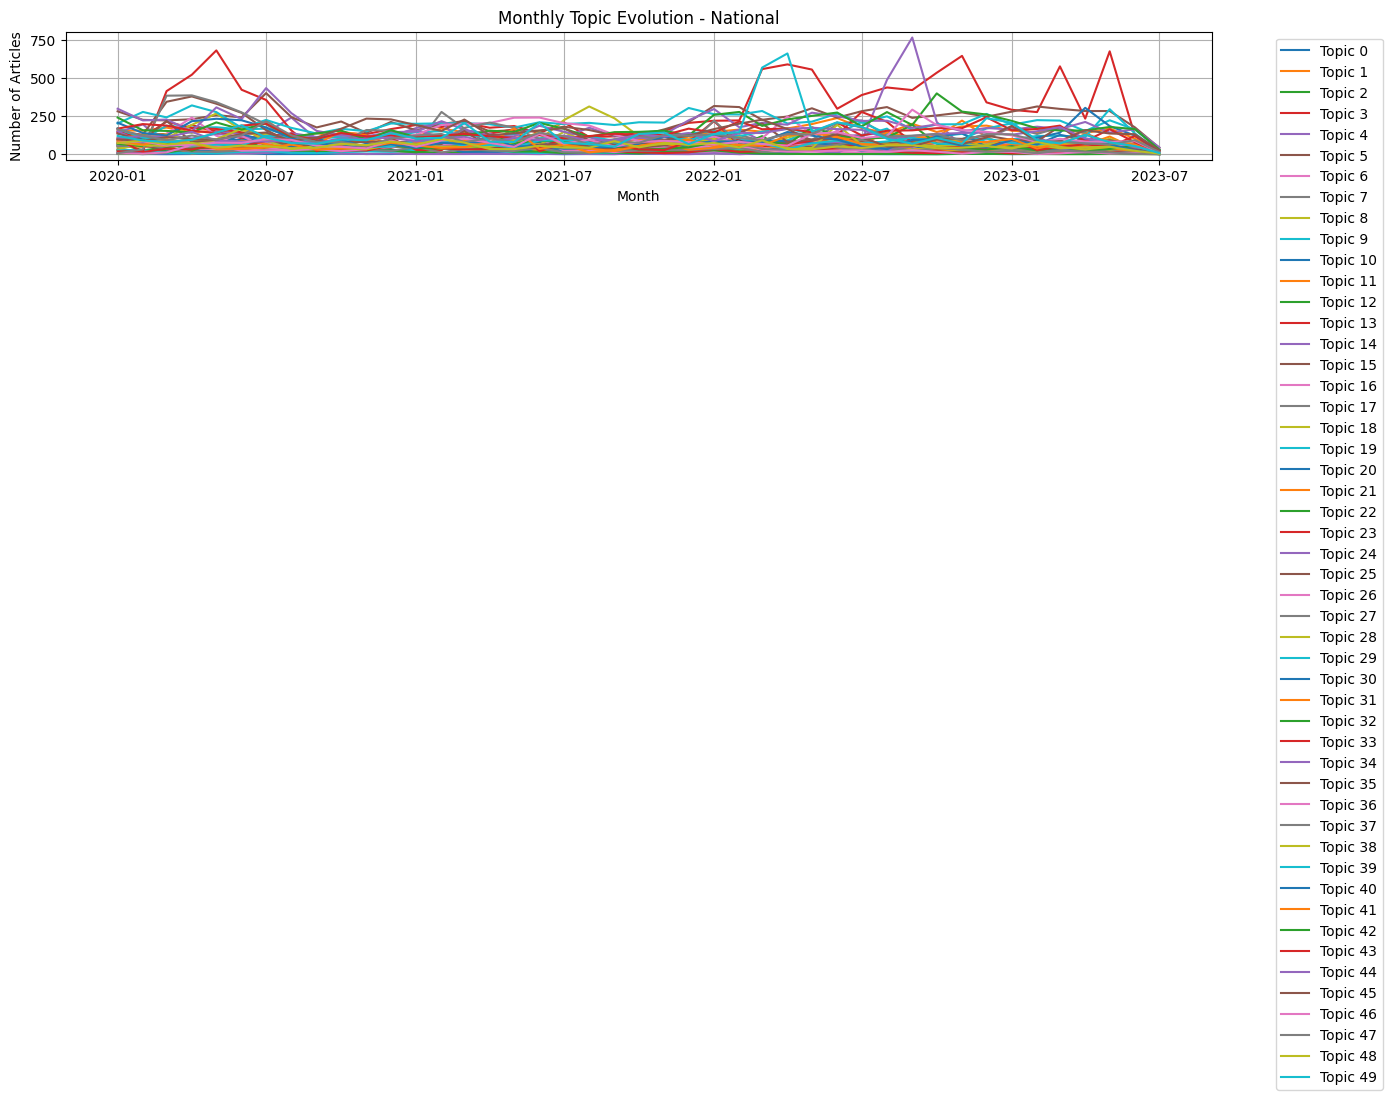

In [ ]:
# Plot
plt.figure(figsize=(14,7))
for col in monthly_nat.columns:
    plt.plot(monthly_nat.index, monthly_nat[col], label=f"Topic {col}")
plt.title("Monthly Topic Evolution - National")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Top 5 Topics: [3, 5, 29, 34, 42]


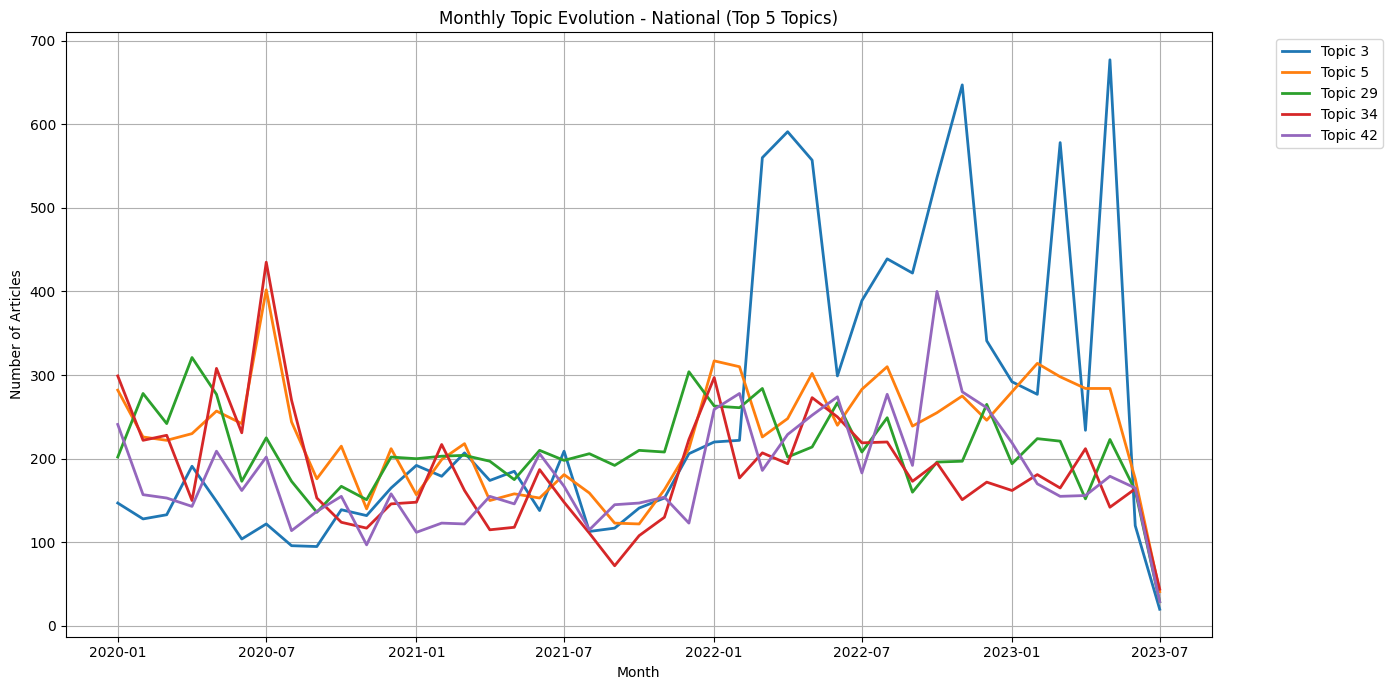

In [ ]:
# Get top 5 topics by total article count
top5_topics = monthly_nat.sum().nlargest(5).index.tolist()
print("Top 5 Topics:", top5_topics)

# Plot only top 5
plt.figure(figsize=(14,7))
for col in top5_topics:
    plt.plot(monthly_nat.index, monthly_nat[col], label=f"Topic {col}", linewidth=2)
plt.title("Monthly Topic Evolution - National (Top 5 Topics)")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

**International Trend**

In [ ]:
df_world['month'] = df_world['date'].dt.to_period('M')
monthly_nat = df_world.groupby(['month','dominant_topic']).size().unstack(fill_value=0)
monthly_nat.index = monthly_nat.index.to_timestamp()
# Get top 5 topics by total article count
top5_topics = monthly_nat.sum().nlargest(5).index.tolist()
print("Top 5 Topics:", top5_topics)

Top 5 Topics: [1, 2, 34, 44, 43]


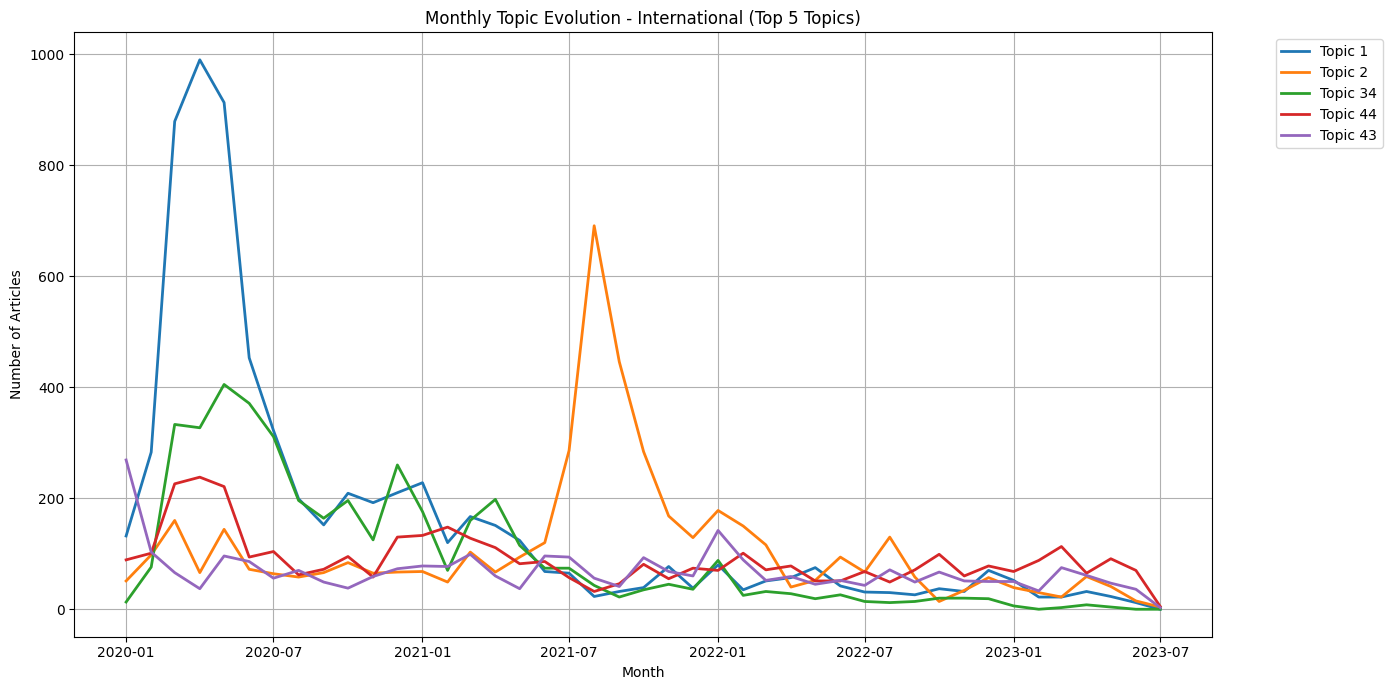

In [ ]:
# Plot only top 5
plt.figure(figsize=(14,7))
for col in top5_topics:
    plt.plot(monthly_nat.index, monthly_nat[col], label=f"Topic {col}", linewidth=2)
plt.title("Monthly Topic Evolution - International (Top 5 Topics)")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Yearly Trend**

**National Trend**

In [ ]:
df_national['year'] = df_national['date'].dt.year
yearly_nat = df_national.groupby(['year','dominant_topic']).size().unstack(fill_value=0)


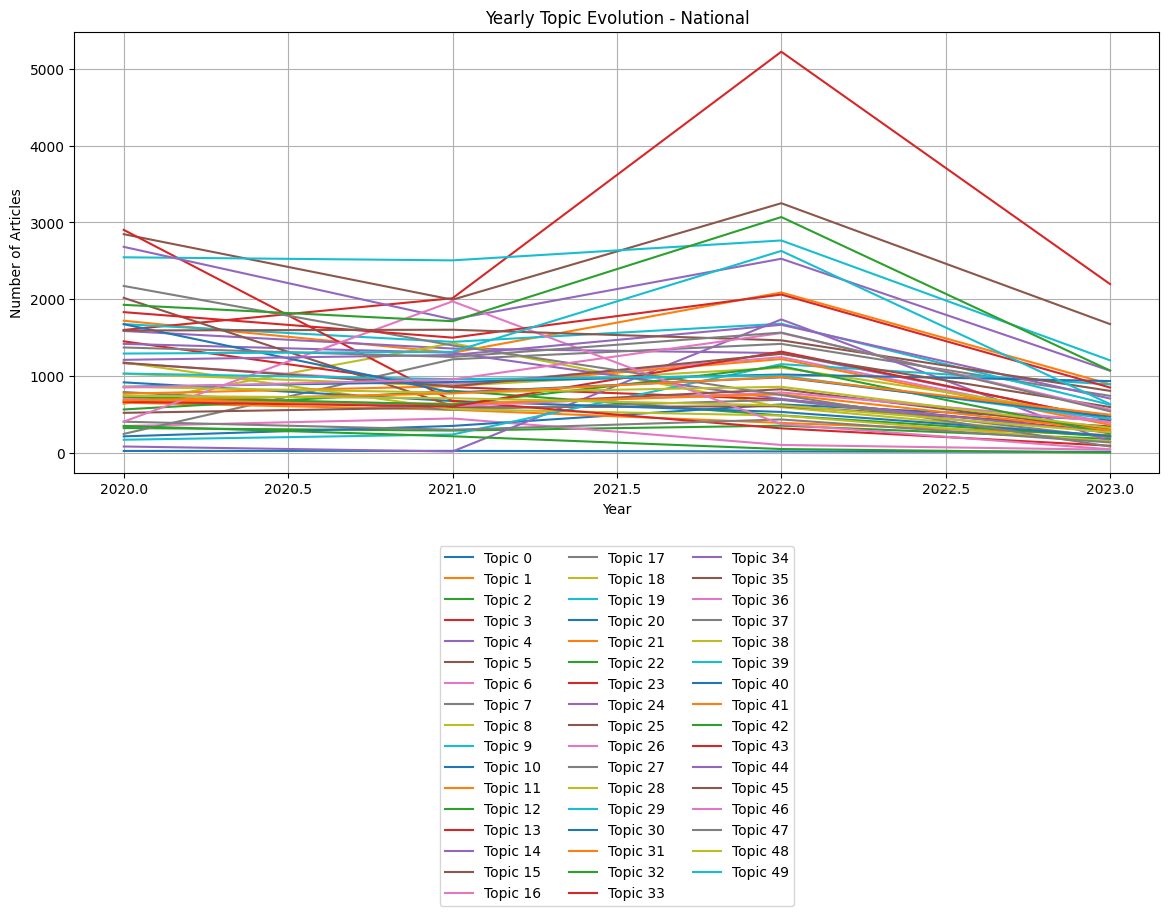

In [ ]:
plt.figure(figsize=(14,7))

for col in yearly_nat.columns:
    plt.plot(yearly_nat.index, yearly_nat[col], label=f"Topic {col}")

plt.title("Yearly Topic Evolution - National")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.grid(True)

plt.legend(
    ncol=3,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    frameon=True
)

# Use constrained_layout instead of tight_layout
plt.gcf().subplots_adjust(bottom=0.25)  # Add space for legend
plt.show()


Top 5 Topics: [3, 5, 29, 34, 42]


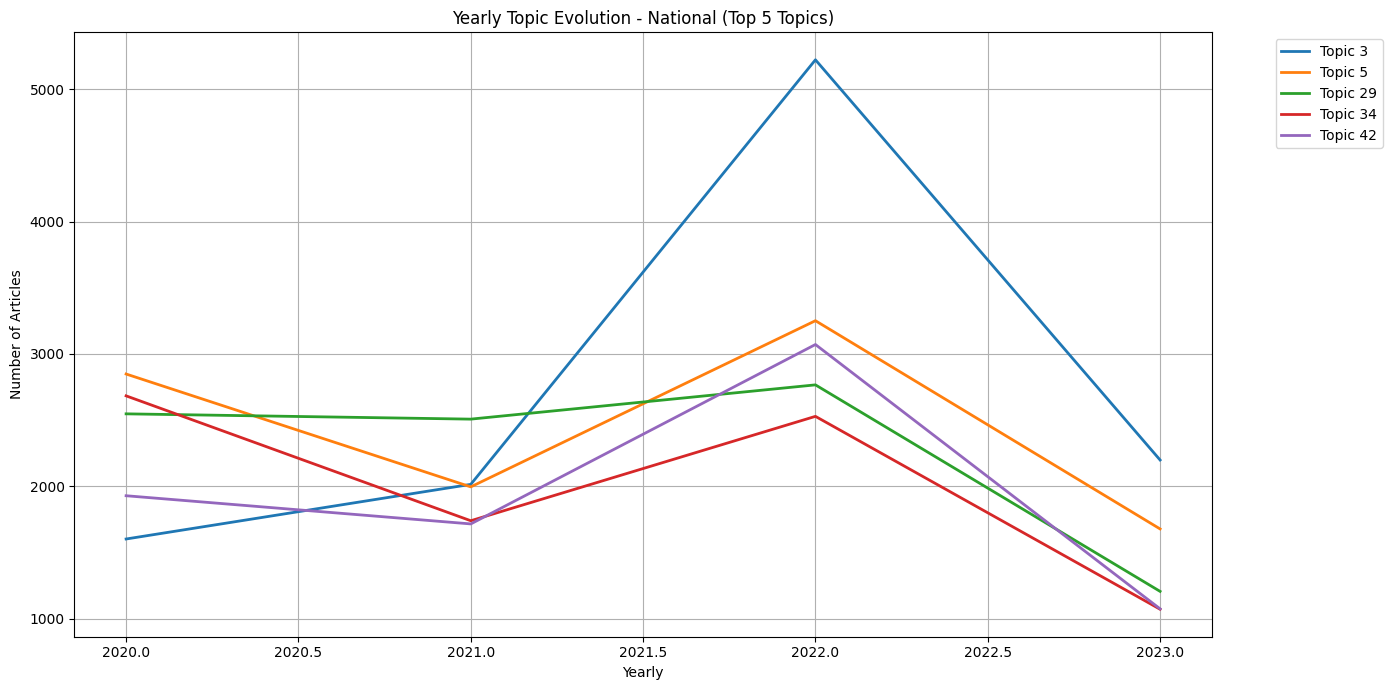

In [ ]:
# Get top 5 topics by total article count
top5_topics = yearly_nat.sum().nlargest(5).index.tolist()
print("Top 5 Topics:", top5_topics)

# Plot only top 5
plt.figure(figsize=(14,7))
for col in top5_topics:
    plt.plot(yearly_nat.index, yearly_nat[col], label=f"Topic {col}", linewidth=2)
plt.title("Yearly Topic Evolution - National (Top 5 Topics)")
plt.xlabel("Yearly")
plt.ylabel("Number of Articles")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

**International Trend**

In [ ]:
df_world['year'] = df_world['date'].dt.year
yearly_nat = df_world.groupby(['year','dominant_topic']).size().unstack(fill_value=0)
# Get top 5 topics by total article count
top5_topics = yearly_nat.sum().nlargest(5).index.tolist()
print("Top 5 Topics:", top5_topics)

Top 5 Topics: [1, 2, 34, 44, 43]


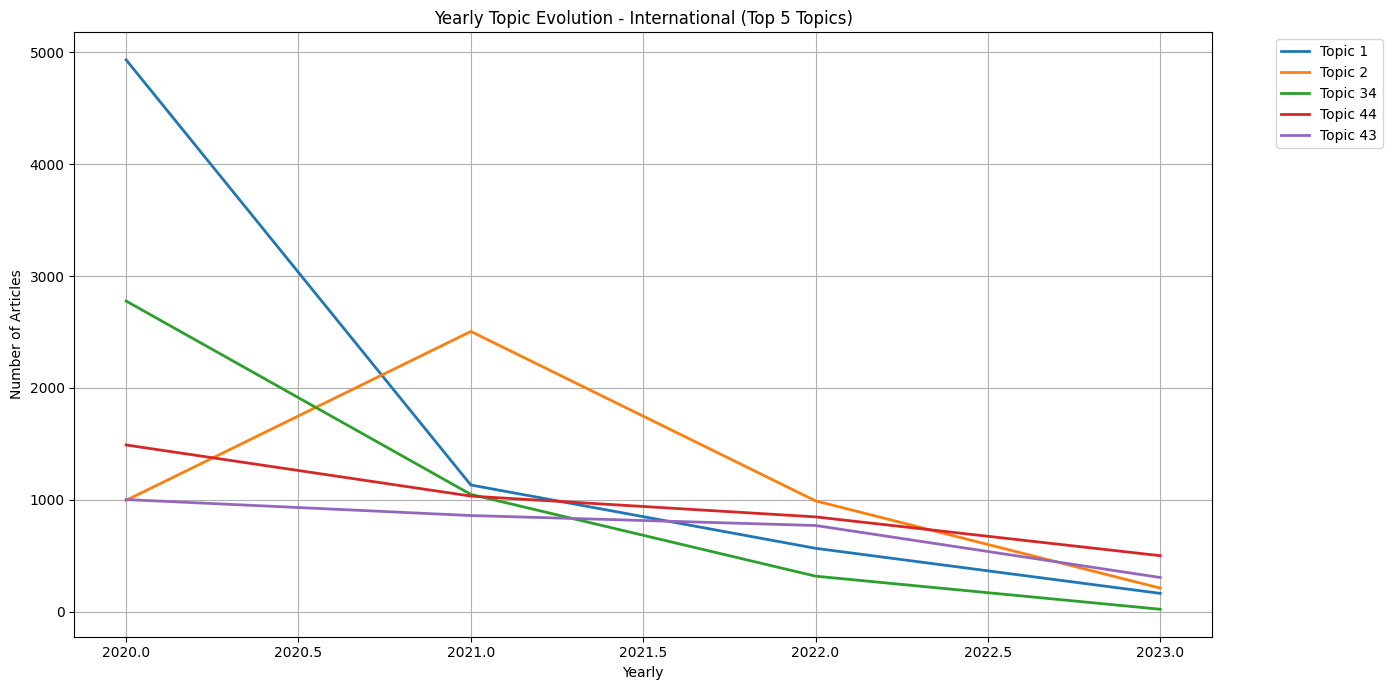

In [ ]:
# Plot only top 5
plt.figure(figsize=(14,7))
for col in top5_topics:
    plt.plot(yearly_nat.index, yearly_nat[col], label=f"Topic {col}", linewidth=2)
plt.title("Yearly Topic Evolution - International (Top 5 Topics)")
plt.xlabel("Yearly")
plt.ylabel("Number of Articles")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Daily Trend**

**National Trend**

In [ ]:
df_national['day'] = df_national['date'].dt.date
daily_nat = df_national.groupby(['day','dominant_topic']).size().unstack(fill_value=0)


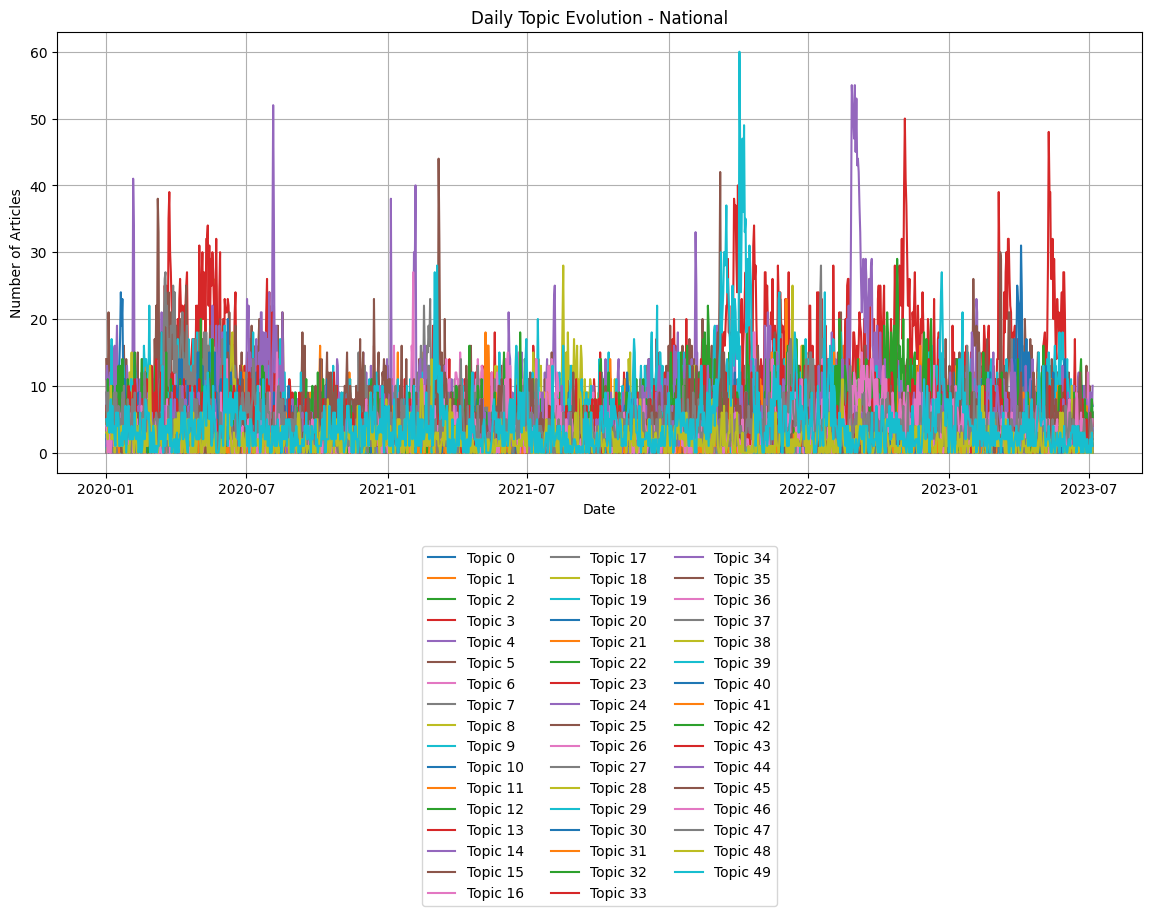

In [ ]:
plt.figure(figsize=(14,7))

for col in daily_nat.columns:
    plt.plot(daily_nat.index, daily_nat[col], label=f"Topic {col}")

plt.title("Daily Topic Evolution - National")
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.legend(
    ncol=3,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    frameon=True
)
plt.gcf().subplots_adjust(bottom=0.25)

plt.show()


Top 5 Topics: [3, 5, 29, 34, 42]


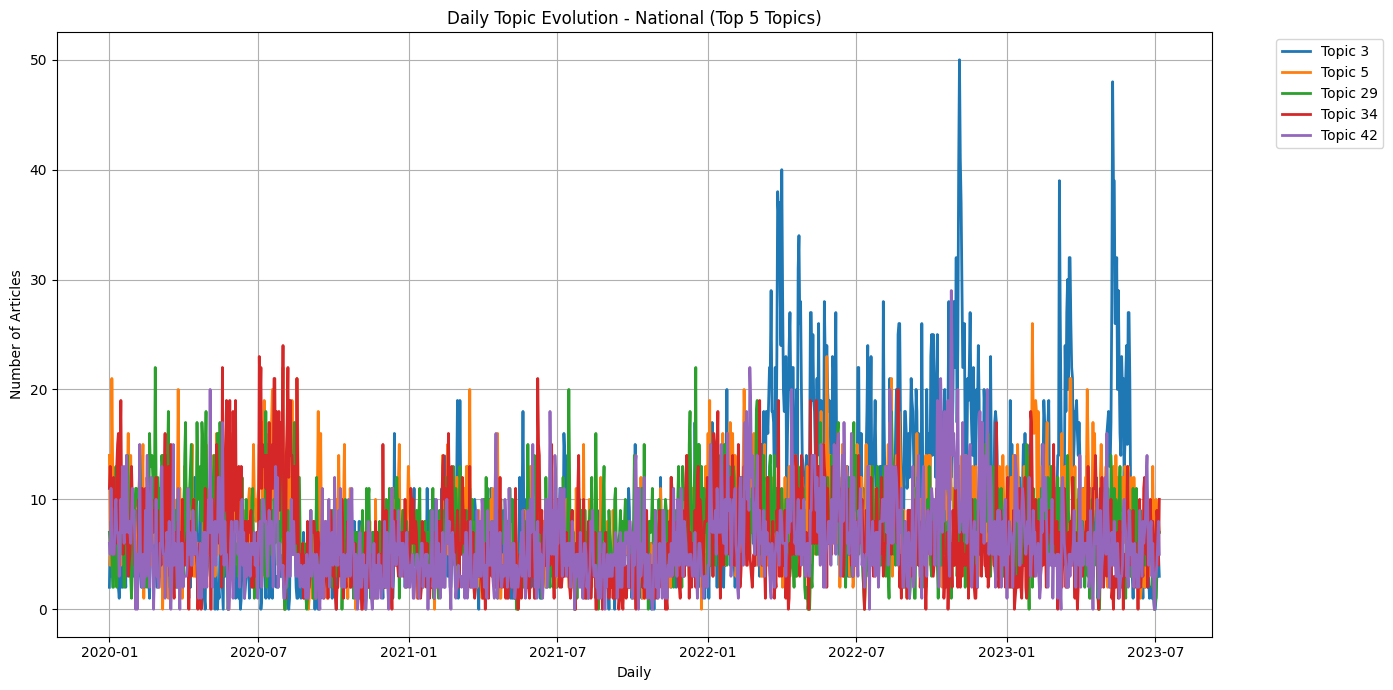

In [ ]:
# Get top 5 topics by total article count
top5_topics = daily_nat.sum().nlargest(5).index.tolist()
print("Top 5 Topics:", top5_topics)

# Plot only top 5
plt.figure(figsize=(14,7))
for col in top5_topics:
    plt.plot(daily_nat.index, daily_nat[col], label=f"Topic {col}", linewidth=2)
plt.title("Daily Topic Evolution - National (Top 5 Topics)")
plt.xlabel("Daily")
plt.ylabel("Number of Articles")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

**International Trend**

In [ ]:
df_world['day'] = df_world['date'].dt.date
daily_nat = df_national.groupby(['day','dominant_topic']).size().unstack(fill_value=0)
# Get top 5 topics by total article count
top5_topics = daily_nat.sum().nlargest(5).index.tolist()
print("Top 5 Topics:", top5_topics)

Top 5 Topics: [3, 5, 29, 34, 42]


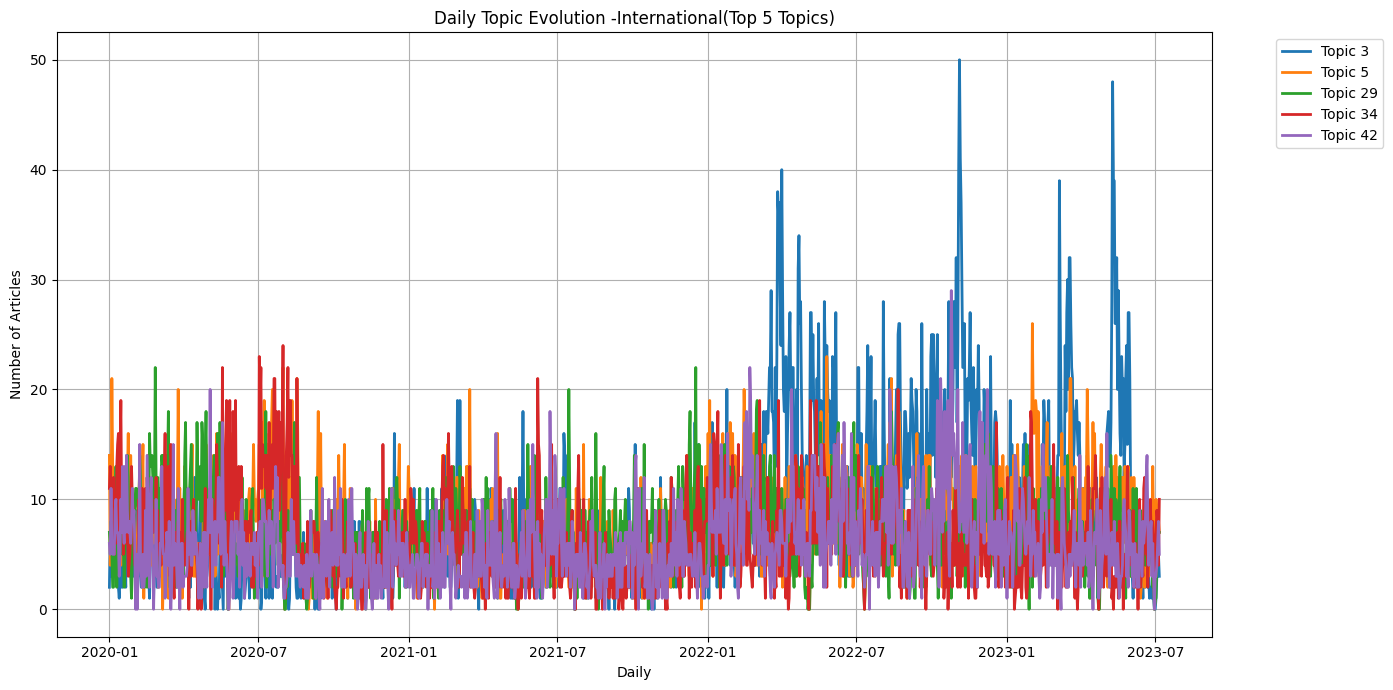

In [ ]:
# Plot only top 5
plt.figure(figsize=(14,7))
for col in top5_topics:
    plt.plot(daily_nat.index, daily_nat[col], label=f"Topic {col}", linewidth=2)
plt.title("Daily Topic Evolution -International(Top 5 Topics)")
plt.xlabel("Daily")
plt.ylabel("Number of Articles")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
top5_topics=daily_nat[top5_topics]

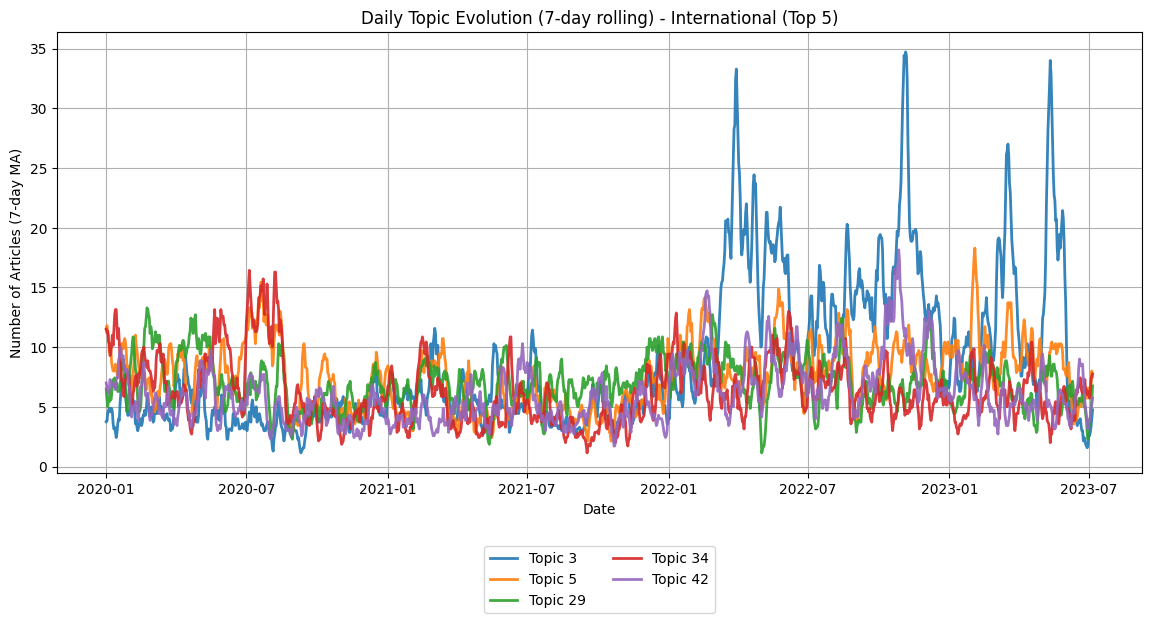

In [ ]:

daily_smoothed = top5_topics.rolling(window=7, min_periods=1, center=True).mean()
plt.figure(figsize=(14,7))
for col in daily_smoothed.columns:
    plt.plot(daily_smoothed.index, daily_smoothed[col], label=f"Topic {col}", linewidth=2, alpha=0.9)
plt.title("Daily Topic Evolution (7-day rolling) - International (Top 5)")
plt.xlabel("Date")
plt.ylabel("Number of Articles (7-day MA)")
plt.grid(True)
plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, -0.15))
plt.gcf().subplots_adjust(bottom=0.25)
plt.show()


# **Time series forecasting**

Category: National, Topic: 0, MAE: 6.51, RMSE: 8.23
Category: National, Topic: 1, MAE: 10.02, RMSE: 12.81
Category: National, Topic: 2, MAE: 4.07, RMSE: 4.98
Category: World, Topic: 0, MAE: 7.09, RMSE: 8.99
Category: World, Topic: 1, MAE: 2.56, RMSE: 3.16
Category: World, Topic: 2, MAE: 2.88, RMSE: 3.82

Forecast for National_topic_0:
           date  topic_count
7670 2023-07-07    34.985741
7670 2023-07-08    31.909592
7670 2023-07-09    27.944418
7670 2023-07-10    33.655739
7670 2023-07-11    33.432167
7670 2023-07-12    34.769421
7670 2023-07-13    38.467411


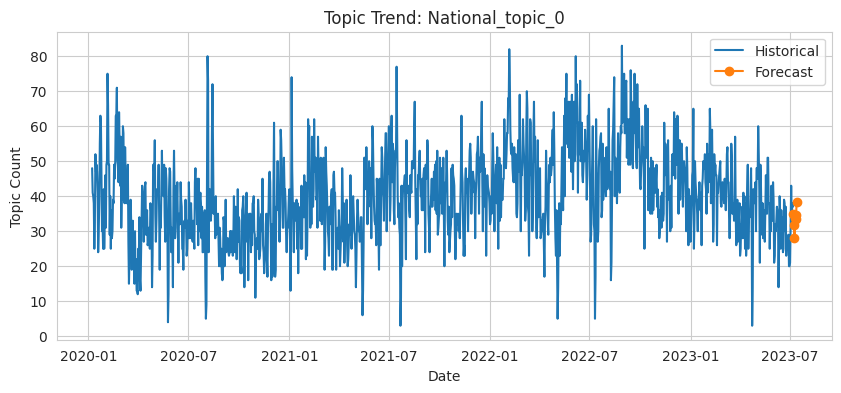


Forecast for National_topic_1:
           date  topic_count
7671 2023-07-07    55.980885
7671 2023-07-08    51.305920
7671 2023-07-09    44.381645
7671 2023-07-10    56.453255
7671 2023-07-11    63.461250
7671 2023-07-12    62.625534
7671 2023-07-13    60.359234


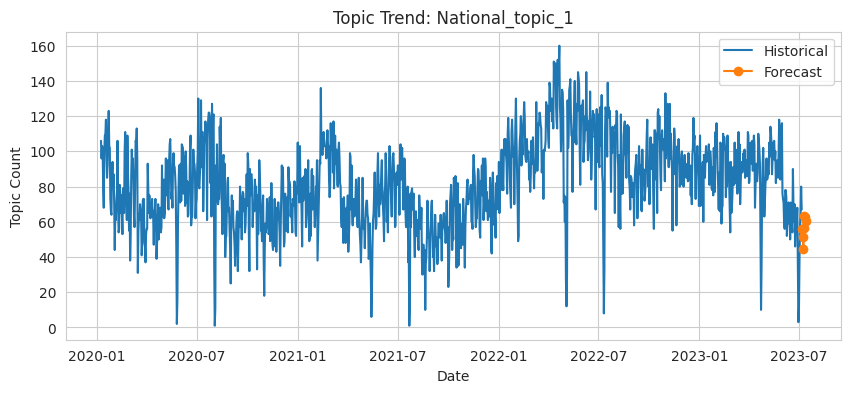


Forecast for National_topic_2:
           date  topic_count
7672 2023-07-07     8.249065
7672 2023-07-08    13.513921
7672 2023-07-09     8.977482
7672 2023-07-10    13.773029
7672 2023-07-11     9.725405
7672 2023-07-12     5.736122
7672 2023-07-13    11.564960


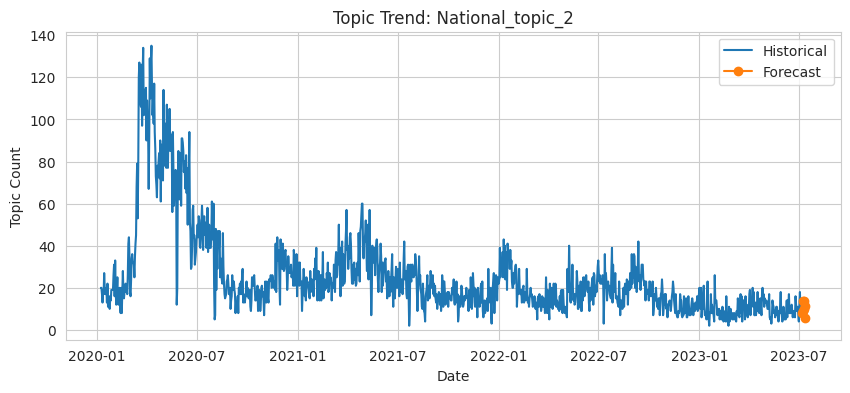


Forecast for World_topic_0:
           date  topic_count
7673 2023-07-07    34.890549
7673 2023-07-08    32.477997
7673 2023-07-09    33.470112
7673 2023-07-10    40.228828
7673 2023-07-11    35.849274
7673 2023-07-12    40.225616
7673 2023-07-13    36.478355


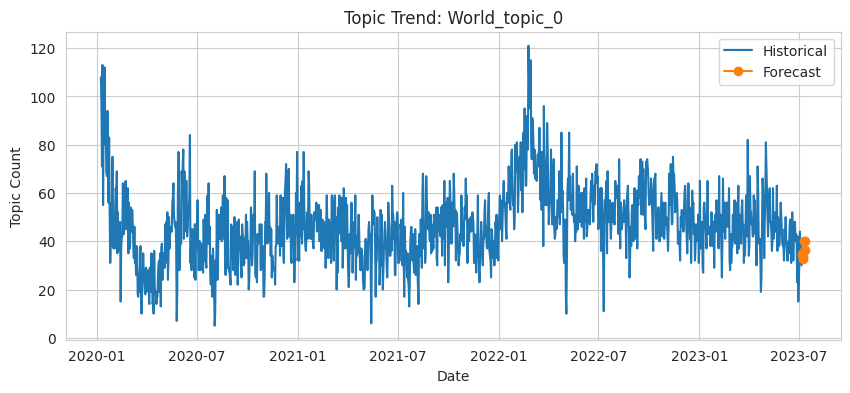


Forecast for World_topic_1:
           date  topic_count
7674 2023-07-07     7.080793
7674 2023-07-08     6.240939
7674 2023-07-09     4.656317
7674 2023-07-10     7.102333
7674 2023-07-11     5.612086
7674 2023-07-12     4.231372
7674 2023-07-13     5.445411


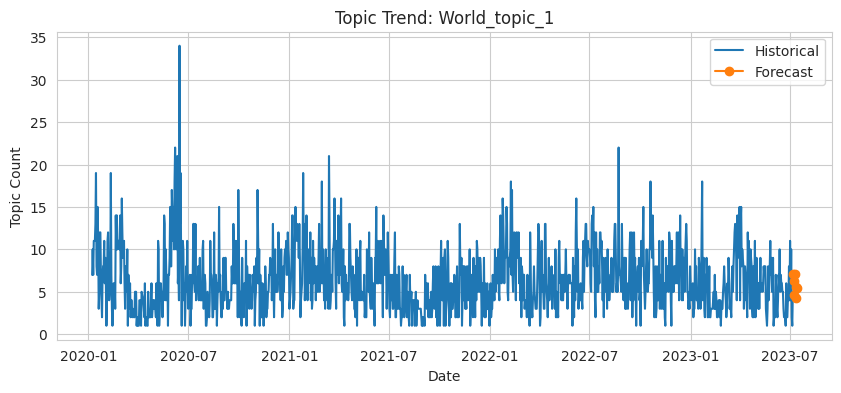


Forecast for World_topic_2:
           date  topic_count
7675 2023-07-07     4.574386
7675 2023-07-08     5.065863
7675 2023-07-09     4.412029
7675 2023-07-10     6.325052
7675 2023-07-11     5.889665
7675 2023-07-12     5.642374
7675 2023-07-13     6.315104


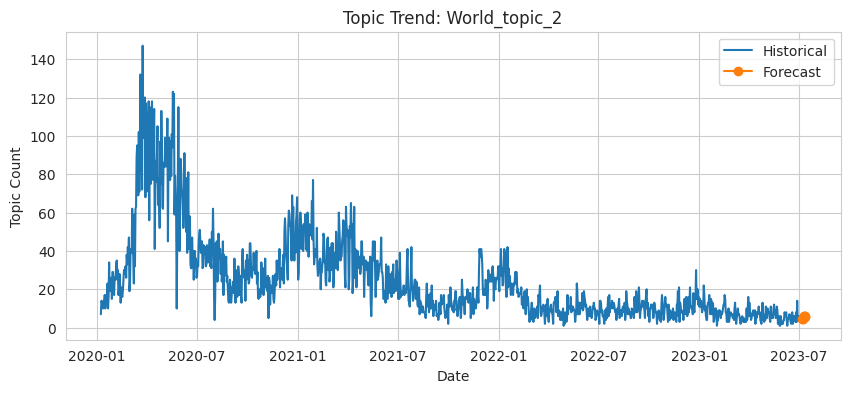


Metrics Summary:
     Category_Topic        MAE       RMSE
0  National_topic_0   6.512664   8.229613
1  National_topic_1  10.023707  12.812259
2  National_topic_2   4.073470   4.978426
3     World_topic_0   7.088161   8.992154
4     World_topic_1   2.562829   3.164667
5     World_topic_2   2.883768   3.824089


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import re
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# -----------------------
# Step 1: Load Data
# -----------------------
df = pd.read_csv(combined_file_path)
df["date"] = pd.to_datetime(df["date"], format='mixed')
df = df[["headline", "description", "mapped_categories", "date"]]

# -----------------------
# Step 2: Configurable Flags
# -----------------------
DO_CLEANING = True      # clean text
USE_NMF = True          # run NMF
NUM_TOPICS = 3          # number of topics
DO_TIME_FEATURES = True # include day/week/month features
USE_LAGS = True         # include lag features
USE_ROLLING = True      # include rolling mean
FORECAST_DAYS = 7       # predict next 7 days
TRAIN_SPLIT = 0.8       # train/test split

# -----------------------
# Step 3: Text Cleaning Function
# -----------------------
def clean_text(text):
    # Ensure text is string before applying string methods
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

if DO_CLEANING:
    # Fill NaN values in 'headline' and 'description' with empty strings before concatenation
    df["text"] = (df["headline"].fillna('') + " " + df["description"].fillna('')).apply(clean_text)
else:
    df["text"] = df["headline"].fillna('') + " " + df["description"].fillna('')

# -----------------------
# Step 4: TF-IDF Vectorization
# -----------------------
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(df["text"])

# -----------------------
# Step 5: NMF Topic Modeling
# -----------------------
if USE_NMF:
    nmf_model = NMF(n_components=NUM_TOPICS, random_state=42)
    topic_matrix = nmf_model.fit_transform(tfidf_matrix)
    df["dominant_topic"] = topic_matrix.argmax(axis=1)

# -----------------------
# Step 6: Aggregate to Time Series
# -----------------------
topic_ts = (
    df.groupby([df["date"].dt.date, "mapped_categories", "dominant_topic"])
      .size()
      .reset_index(name="topic_count")
)
topic_ts["date"] = pd.to_datetime(topic_ts["date"])
topic_ts = topic_ts.sort_values("date")

# -----------------------
# Step 7: Feature Engineering
# -----------------------
def create_features(df):
    df = df.copy()
    if DO_TIME_FEATURES:
        df["day"] = df["date"].dt.day
        df["dayofweek"] = df["date"].dt.dayofweek
        df["month"] = df["date"].dt.month
    if USE_LAGS:
        df["lag_1"] = df["topic_count"].shift(1)
        df["lag_7"] = df["topic_count"].shift(7)
    if USE_ROLLING:
        df["rolling_mean_7"] = df["topic_count"].rolling(7).mean()
    return df

# -----------------------
# Step 8: Train XGBoost Per Category & Topic
# -----------------------
def train_model(category, topic):
    df_cat_topic = topic_ts[(topic_ts["mapped_categories"] == category) &
                            (topic_ts["dominant_topic"] == topic)]
    df_cat_topic = create_features(df_cat_topic)
    df_cat_topic = df_cat_topic.dropna()

    X = df_cat_topic.drop(["date", "mapped_categories", "dominant_topic", "topic_count"], axis=1)
    y = df_cat_topic["topic_count"]

    split = int(len(df_cat_topic) * TRAIN_SPLIT)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds)) # Removed squared=False

    print(f"Category: {category}, Topic: {topic}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    return model, df_cat_topic, X_test, y_test, preds

# -----------------------
# Step 9: Train All Models
# -----------------------
models = {}
results = {}

for category in topic_ts["mapped_categories"].unique():
    for topic in range(NUM_TOPICS):
        key = f"{category}_topic_{topic}"
        model, df_cat_topic, X_test, y_test, preds = train_model(category, topic)
        models[key] = model
        results[key] = {"df": df_cat_topic, "X_test": X_test, "y_test": y_test, "preds": preds}

# -----------------------
# Step 10: Forecast Future Topic Counts
# -----------------------
def forecast_future(model, df, days):
    future = df.copy()
    for _ in range(days):
        last_row = future.iloc[-1:].copy()
        next_date = last_row["date"].values[0] + np.timedelta64(1, "D")
        last_row["date"] = next_date
        # Update lag/rolling
        if USE_LAGS:
            last_row["lag_1"] = future["topic_count"].iloc[-1]
            last_row["lag_7"] = future["topic_count"].iloc[-7]
        if USE_ROLLING:
            last_row["rolling_mean_7"] = future["topic_count"].tail(7).mean()
        if DO_TIME_FEATURES:
            last_row["day"] = pd.to_datetime(next_date).day
            last_row["dayofweek"] = pd.to_datetime(next_date).dayofweek
            last_row["month"] = pd.to_datetime(next_date).month

        X_new = last_row.drop(["date", "mapped_categories", "dominant_topic", "topic_count"], axis=1)
        pred = model.predict(X_new)[0]
        last_row["topic_count"] = pred
        future = pd.concat([future, last_row])
    return future.tail(days)

# -----------------------
# Step 11: Forecast & Plot
# -----------------------
for key, model in models.items():
    df_cat_topic = results[key]["df"]
    forecast = forecast_future(model, df_cat_topic, FORECAST_DAYS)

    print(f"\nForecast for {key}:")
    print(forecast[["date", "topic_count"]])

    # Plot historical + forecast
    plt.figure(figsize=(10,4))
    plt.plot(df_cat_topic["date"], df_cat_topic["topic_count"], label="Historical")
    plt.plot(forecast["date"], forecast["topic_count"], label="Forecast", marker="o")
    plt.title(f"Topic Trend: {key}")
    plt.xlabel("Date")
    plt.ylabel("Topic Count")
    plt.legend()
    plt.show()

# -----------------------
# Step 12: Summary Metrics Table
# -----------------------
metrics_summary = []
for key in results:
    y_test = results[key]["y_test"]
    preds = results[key]["preds"]
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds)) # Removed squared=False
    metrics_summary.append([key, mae, rmse])

metrics_df = pd.DataFrame(metrics_summary, columns=["Category_Topic", "MAE", "RMSE"])
print("\nMetrics Summary:")
print(metrics_df)